<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_LAMBDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

SAVE_PATH = "/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323"

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [2]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

170500096/170498071 [==============================] - 2s 0us/step
x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


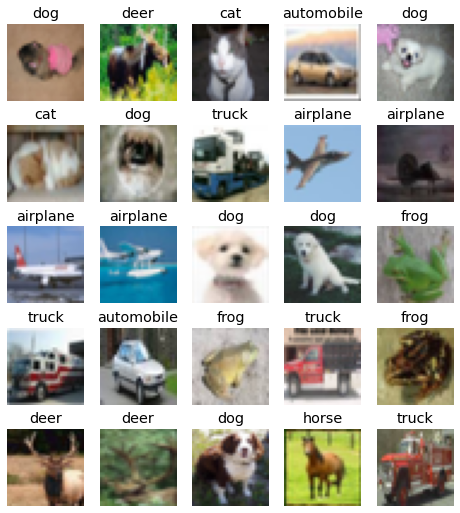

In [3]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [4]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


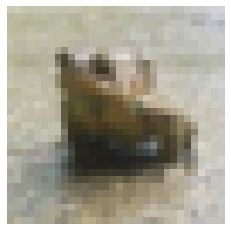

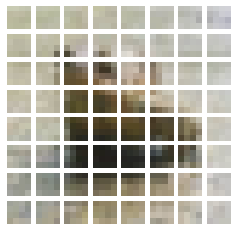

In [5]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

##CNN

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

##VIT

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) from the official keras website.

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

##LambdaNetworks

[LambdaNetworks](https://arxiv.org/abs/2102.08602) from Irwan Bello.  

The LambdaNets is based on [tfkeras.py](https://github.com/lucidrains/lambda-networks/blob/main/lambda_networks/tfkeras.py) from [lucidrains/lambda-networks](https://github.com/lucidrains/lambda-networks) and [lambda2d.py](https://github.com/g0lemXIV/LambdaNetworks/blob/main/lambda_layers/lambda2d.py) from [g0lemXIV/LambdaNetworks](https://github.com/g0lemXIV/LambdaNetworks) .  

**Good to know points from the paper**
*   The paper main introduces lambdalayer and uses it to replace the convs in ResNet to create LambdaResNet.
*   LambdaResNet achieves high accuracy but is very slow (~7x slower).
*   The main conclusion is that a hybrid model of conv + lambda has the best speed-accuracy tradeoff.
*   The best hybrid model replaces only some blocks in C4 and all the blocks in C5.




In [9]:
! pip install einops
from einops.layers.tensorflow import Rearrange

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  BatchNormalization, 
  Conv2D,
  Conv3D
)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)
from tensorflow import einsum, meshgrid


def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  

def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)


def calc_rel_pos(n: int):
  """Generates a relative position meshgrid.
  
  Args:
    n: Size of the original meshgrid. Size = Height = Width.

  Returns: 
    rel_pos: An array of [n*n, n*n, 2] with value range from [-n+1, n-1] to 
             [0, 2n-2].
  """
  # [2, n, n]
  pos = tf.stack(meshgrid(tf.range(n), tf.range(n), indexing = 'ij'))
  # [n*n, 2], pos[n] = (i, j)
  pos = Rearrange('n i j -> (i j) n')(pos)             
  # [n*n, n*n, 2], rel_pos[n, m] = (rel_i, rel_j)
  rel_pos = pos[None, :] - pos[:, None]                
  # shift value range from [-n+1, n-1] to [0, 2n-2]
  rel_pos += n - 1
  # [n*n, n*n, 2]                      
  return rel_pos


class Lambda(Layer):
  """Lambda Networks implementation."""

  def __init__(self,
               output_dim: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               batch_norm: bool = True,
               **kwargs):
    """Constructor

    Args:
      output_dim: Output dimension of the layer or v_dim * `num_heads`.
      k_dim: Dimension of key.
      u_dim: Intra depth for multiquery heads.
      num_heads: Number of heads for multiquery.
      n_r_size: If `local_contexts=True` n = height*width of query,
                else r = receptive field.
      local_contexts: If True lambdaconv is used, 
                      else relative position embeddings are used.
      batch_norm: Whether to apply batch norm to query and value after
                  the linear projection.

    """
    super().__init__(**kwargs)

    self.output_dim = output_dim
    self.u_dim = u_dim  # intra-depth dimension
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.batch_norm = batch_norm

    assert (self.output_dim % self.num_heads) == 0, \
      '`output_dim` must be divisible by `num_heads` for multi-head query.'
    self.v_dim = self.output_dim // self.num_heads
    self.k_dim = k_dim
    self.num_heads = num_heads

    self.to_q = Conv2D(self.k_dim * self.num_heads, 1, use_bias=self.batch_norm)
    self.to_k = Conv2D(self.k_dim * self.u_dim, 1, use_bias=self.batch_norm)
    self.to_v = Conv2D(self.v_dim * self.u_dim, 1, use_bias=self.batch_norm)

    self.norm_q = BatchNormalization() if self.batch_norm else None
    self.norm_v = BatchNormalization() if self.batch_norm else None

    if self.local_contexts:
      assert (self.n_r_size % 2) == 1, 'Receptive kernel size should be odd'
      self.pos_conv = Conv3D(self.k_dim, 
                             (1, self.n_r_size, self.n_r_size), 
                             padding='same')
    else:
      assert n is not None, 'You must specify the window length (n = h = w)'
      rel_length = 2 * self.n_r_size - 1
      self.rel_pos_emb = self.add_weight(name='pos_emb',
                                         shape=(rel_length, rel_length, 
                                                self.k_dim, self.u_dim),
                                         initializer=RandomNormal,
                                         trainable=True)
      self.rel_pos = calc_rel_pos(self.n_r_size)

  def call(self, x):
    """
    Info on the notations for reference:
    x = 2D Image data (Assumption)
    q = query
    k = key
    v = value
    h = number of heads for multiquery
    u = intradepth
    b = batch size
    hh = height of input data
    ww = width of input data
    m = height * width of key / value.
    n = height * width of query.
    """
    b, hh, ww, c, u, h = *x.get_shape().as_list(), self.u_dim, self.num_heads

    q = self.to_q(x)
    k = self.to_k(x)
    v = self.to_v(x)

    if self.batch_norm:
      q = self.norm_q(q)
      v = self.norm_v(v)

    q = Rearrange('b hh ww (h k) -> b h k (hh ww)', h=h)(q)
    k = Rearrange('b hh ww (u k) -> b u k (hh ww)', u=u)(k)
    v = Rearrange('b hh ww (u v) -> b u v (hh ww)', u=u)(v)

    k = tf.nn.softmax(k)

    Lc = einsum('b u k m, b u v m -> b k v', k, v)
    Yc = einsum('b h k n, b k v -> b n h v', q, Lc)

    if self.local_contexts:
      # lambda convs, embedding is represented by the conv kernels.
      v = Rearrange('b u v (hh ww) -> b v hh ww u', hh=hh, ww=ww)(v)
      Lp = self.pos_conv(v)
      Lp = Rearrange('b v h w k -> b v k (h w)')(Lp)
      Yp = einsum('b h k n, b v k n -> b n h v', q, Lp)
    else:
      # relative position embedding.
      rel_pos_emb = tf.gather_nd(self.rel_pos_emb, self.rel_pos)
      Lp = einsum('n m k u, b u v m -> b n k v', rel_pos_emb, v)
      Yp = einsum('b h k n, b n k v -> b n h v', q, Lp)

    Y = Yc + Yp
    out = Rearrange('b (hh ww) h v -> b hh ww (h v)', hh = hh, ww = ww)(Y)
    return out

  def get_config(self):
    return {"output_dim": self.output_dim,
            "k_dim": self.k_dim,
            "u_dim": self.u_dim,
            "num_heads": self.num_heads,
            "n_r_size": self.n_r_size,
            "local_contexts": self.local_contexts,
            "batch_norm": self.batch_norm}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class LambdaNetwork(Model):
  """LambdaNetworks implementation. """
  
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               preprocess: bool = False,
               **kwargs):
    super().__init__(**kwargs)
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.k_dim = k_dim
    self.u_dim = u_dim
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')

    # self.lamb3 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    # self.lamb4 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    self.lamb3 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb3')
    self.lamb4 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')

    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)

    x = self.pool4(self.lamb4(self.lamb3(x)))
    x = self.drop4(x, training=training)

    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.logits(x)

    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

# Train

Training configs.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [11]:
def train_and_eval(_model, _checkpoint_filepath, verbose=1):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.
      verbose: Option for logging output during train and eval.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    _checkpoint_filepath,
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
  )

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(_checkpoint_filepath, 'logs'), 
    histogram_freq=epochs//10,
    update_freq='epoch'
  )

  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[tensorboard_callback, checkpoint_callback],
      verbose=verbose
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  # Save history output, should be the same as the tensorboard logs.
  np.save(os.path.join(_checkpoint_filepath, 'history.npy'), history.history)
  
  return history

# Loss and accuracy plots

In [12]:
def plot(losses: list, 
         accuracies: list, 
         legend_labels: list, 
         subplot_title: list):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  
  for x, ll in zip(losses, legend_labels):
    c = ax1.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax1.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()   

  for x, ll in zip(accuracies, legend_labels):
    c = ax2.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax2.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()   

  plt.show()

#Experiments

In [13]:
history = dict()

##Exp 1
Model : CNN  
Preprocessing : False  
Batch size : 256

In [14]:
# model = SmallCNN(num_classes=num_classes, 
#                  image_height=image_height, 
#                  image_width=image_width,
#                  preprocess=False).model()
# model.summary()
# history['CNN'] = train_and_eval(model, SAVE_PATH + '_CNN', verbose=2)

##Exp 2
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2

In [ ]:
# # Saves a full copy of the model.
# model = VIT(num_classes=num_classes, 
#             image_height=image_height, 
#             image_width=image_width,
#             patch_size=4, 
#             projection_dim=32,
#             num_layers=4,
#             num_heads=2,
#             mlp_dims=[64, 32],
#             classifier_mlp_dims=[512],
#             preprocess=False).model()
# model.summary()
# history['VIT'] = train_and_eval(model, SAVE_PATH + '_VIT_4x4_2hds', verbose=2)

##Exp 3 - X Heads, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 1,2,4,8  
u dim : 1  
Heads : 1,2,4,8  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       =  1, 2, 4, 8| 2, 4, 8,16| 4, 8,16,32| 8,16,32,64|
K = k * u        =  1, 2, 4, 8| 1, 2, 4, 8| 1, 2, 4, 8| 1, 2, 4, 8|
V = 64 // hd * u = 64,64,64,64|32,32,32,32|16,16,16,16| 8, 8, 8, 8|
</pre>


In [17]:
u_dim = 1
for hds in [1,2,4,8]:
  for k_dim in [1,2,4,8]:
    model = LambdaNetwork(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          k_dim=k_dim,
                          u_dim=u_dim,
                          num_heads=hds,
                          n_r_size=14,
                          local_contexts=False,
                          preprocess=False).model()
    model.summary()
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5868 - sparse_categorical_accuracy: 0.4172 - val_loss: 1.6689 - val_sparse_categorical_accuracy: 0.3974


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4221 - sparse_categorical_accuracy: 0.4868 - val_loss: 1.3686 - val_sparse_categorical_accuracy: 0.5020


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.2993 - sparse_categorical_accuracy: 0.5353 - val_loss: 1.1767 - val_sparse_categorical_accuracy: 0.5772


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2333 - sparse_categorical_accuracy: 0.5603 - val_loss: 1.1457 - val_sparse_categorical_accuracy: 0.5905


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1679 - sparse_categorical_accuracy: 0.5847 - val_loss: 1.0926 - val_sparse_categorical_accuracy: 0.6123


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1320 - sparse_categorical_accuracy: 0.5989 - val_loss: 1.0642 - val_sparse_categorical_accuracy: 0.6249


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.0888 - sparse_categorical_accuracy: 0.6151 - val_loss: 1.0383 - val_sparse_categorical_accuracy: 0.6390


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0526 - sparse_categorical_accuracy: 0.6280 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.6592


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0115 - sparse_categorical_accuracy: 0.6414 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.6677


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 6s - loss: 0.9867 - sparse_categorical_accuracy: 0.6507 - val_loss: 0.8893 - val_sparse_categorical_accuracy: 0.6886


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9612 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.8468 - val_sparse_categorical_accuracy: 0.7054


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9381 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.8218 - val_sparse_categorical_accuracy: 0.7086


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 6s - loss: 0.9224 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.8330 - val_sparse_categorical_accuracy: 0.7104


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.8946 - sparse_categorical_accuracy: 0.6873 - val_loss: 0.8208 - val_sparse_categorical_accuracy: 0.7170


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.8794 - sparse_categorical_accuracy: 0.6926 - val_loss: 0.8367 - val_sparse_categorical_accuracy: 0.7128
Epoch 17/50
196/196 - 6s - loss: 0.8661 - sparse_categorical_accuracy: 0.6946 - val_loss: 0.8137 - val_sparse_categorical_accuracy: 0.7314


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.8550 - sparse_categorical_accuracy: 0.7002 - val_loss: 0.8145 - val_sparse_categorical_accuracy: 0.7280
Epoch 19/50
196/196 - 6s - loss: 0.8353 - sparse_categorical_accuracy: 0.7060 - val_loss: 0.7635 - val_sparse_categorical_accuracy: 0.7369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 6s - loss: 0.8219 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.7813 - val_sparse_categorical_accuracy: 0.7304
Epoch 21/50
196/196 - 6s - loss: 0.8123 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7551 - val_sparse_categorical_accuracy: 0.7400


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8028 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7654 - val_sparse_categorical_accuracy: 0.7368
Epoch 23/50
196/196 - 6s - loss: 0.7880 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7892 - val_sparse_categorical_accuracy: 0.7368
Epoch 24/50
196/196 - 6s - loss: 0.7871 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.7462


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.7725 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.7650 - val_sparse_categorical_accuracy: 0.7475


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 26/50
196/196 - 6s - loss: 0.7580 - sparse_categorical_accuracy: 0.7370 - val_loss: 0.7284 - val_sparse_categorical_accuracy: 0.7535


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.7561 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.7414 - val_sparse_categorical_accuracy: 0.7491
Epoch 28/50
196/196 - 6s - loss: 0.7495 - sparse_categorical_accuracy: 0.7374 - val_loss: 0.8656 - val_sparse_categorical_accuracy: 0.7420
Epoch 29/50
196/196 - 6s - loss: 0.7409 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.6980 - val_sparse_categorical_accuracy: 0.7606


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.7365 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.7667


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 6s - loss: 0.7273 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.6816 - val_sparse_categorical_accuracy: 0.7670


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.7275 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.7325 - val_sparse_categorical_accuracy: 0.7582
Epoch 33/50
196/196 - 6s - loss: 0.7147 - sparse_categorical_accuracy: 0.7492 - val_loss: 0.6857 - val_sparse_categorical_accuracy: 0.7645
Epoch 34/50
196/196 - 6s - loss: 0.7191 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.7280 - val_sparse_categorical_accuracy: 0.7611
Epoch 35/50
196/196 - 6s - loss: 0.6990 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.7056 - val_sparse_categorical_accuracy: 0.7697


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 36/50
196/196 - 6s - loss: 0.6923 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.6580 - val_sparse_categorical_accuracy: 0.7786


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 37/50
196/196 - 6s - loss: 0.6805 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.7548 - val_sparse_categorical_accuracy: 0.7690
Epoch 38/50
196/196 - 6s - loss: 0.6833 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7699
Epoch 39/50
196/196 - 6s - loss: 0.6757 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.7669
Epoch 40/50
196/196 - 6s - loss: 0.6770 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.7735
Epoch 41/50
196/196 - 6s - loss: 0.6701 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.7813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 6s - loss: 0.6608 - sparse_categorical_accuracy: 0.7704 - val_loss: 0.6881 - val_sparse_categorical_accuracy: 0.7738
Epoch 43/50
196/196 - 6s - loss: 0.6592 - sparse_categorical_accuracy: 0.7707 - val_loss: 0.6861 - val_sparse_categorical_accuracy: 0.7750
Epoch 44/50
196/196 - 6s - loss: 0.6532 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.6734 - val_sparse_categorical_accuracy: 0.7751
Epoch 45/50
196/196 - 6s - loss: 0.6416 - sparse_categorical_accuracy: 0.7748 - val_loss: 0.6353 - val_sparse_categorical_accuracy: 0.7788
Epoch 46/50
196/196 - 6s - loss: 0.6421 - sparse_categorical_accuracy: 0.7745 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.7741
Epoch 47/50
196/196 - 6s - loss: 0.6383 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.7802
Epoch 48/50
196/196 - 6s - loss: 0.6345 - sparse_categorical_accuracy: 0.7791 - val_loss: 0.6659 - val_sparse_categorical_accuracy: 0.7824


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 6s - loss: 0.6348 - sparse_categorical_accuracy: 0.7790 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.7796
Epoch 50/50
196/196 - 6s - loss: 0.6237 - sparse_categorical_accuracy: 0.7817 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.7848


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Total training time 422.78032183647156 seconds
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5289 - sparse_categorical_accuracy: 0.4455 - val_loss: 1.4613 - val_sparse_categorical_accuracy: 0.4542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3615 - sparse_categorical_accuracy: 0.5120 - val_loss: 1.4300 - val_sparse_categorical_accuracy: 0.4951


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2337 - sparse_categorical_accuracy: 0.5588 - val_loss: 1.4381 - val_sparse_categorical_accuracy: 0.5237


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.1641 - sparse_categorical_accuracy: 0.5885 - val_loss: 1.1083 - val_sparse_categorical_accuracy: 0.6191


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.0958 - sparse_categorical_accuracy: 0.6141 - val_loss: 1.0647 - val_sparse_categorical_accuracy: 0.6282


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.0590 - sparse_categorical_accuracy: 0.6269 - val_loss: 1.0518 - val_sparse_categorical_accuracy: 0.6397


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.0274 - sparse_categorical_accuracy: 0.6398 - val_loss: 0.9715 - val_sparse_categorical_accuracy: 0.6474


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 7s - loss: 0.9925 - sparse_categorical_accuracy: 0.6496 - val_loss: 0.9529 - val_sparse_categorical_accuracy: 0.6819


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 7s - loss: 0.9612 - sparse_categorical_accuracy: 0.6626 - val_loss: 0.9752 - val_sparse_categorical_accuracy: 0.6680
Epoch 11/50
196/196 - 7s - loss: 0.9479 - sparse_categorical_accuracy: 0.6684 - val_loss: 0.8578 - val_sparse_categorical_accuracy: 0.6940


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.9233 - sparse_categorical_accuracy: 0.6758 - val_loss: 1.0538 - val_sparse_categorical_accuracy: 0.6672
Epoch 13/50
196/196 - 7s - loss: 0.9150 - sparse_categorical_accuracy: 0.6806 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.7047


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.8838 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.8225 - val_sparse_categorical_accuracy: 0.7112


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.8771 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.8568 - val_sparse_categorical_accuracy: 0.6993
Epoch 16/50
196/196 - 7s - loss: 0.8557 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.8457 - val_sparse_categorical_accuracy: 0.7130


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8420 - sparse_categorical_accuracy: 0.7036 - val_loss: 0.8033 - val_sparse_categorical_accuracy: 0.7230


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.8309 - sparse_categorical_accuracy: 0.7081 - val_loss: 0.8007 - val_sparse_categorical_accuracy: 0.7278


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 7s - loss: 0.8199 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7983 - val_sparse_categorical_accuracy: 0.7338


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8040 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.7265
Epoch 21/50
196/196 - 7s - loss: 0.7916 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.8152 - val_sparse_categorical_accuracy: 0.7330
Epoch 22/50
196/196 - 7s - loss: 0.7954 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.7363


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.7793 - sparse_categorical_accuracy: 0.7274 - val_loss: 0.7258 - val_sparse_categorical_accuracy: 0.7495


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.7678 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.7396 - val_sparse_categorical_accuracy: 0.7470
Epoch 25/50
196/196 - 7s - loss: 0.7480 - sparse_categorical_accuracy: 0.7385 - val_loss: 0.8092 - val_sparse_categorical_accuracy: 0.7304
Epoch 26/50
196/196 - 7s - loss: 0.7394 - sparse_categorical_accuracy: 0.7425 - val_loss: 0.8421 - val_sparse_categorical_accuracy: 0.7547


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 7s - loss: 0.7444 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.7554


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 7s - loss: 0.7343 - sparse_categorical_accuracy: 0.7426 - val_loss: 0.7773 - val_sparse_categorical_accuracy: 0.7414
Epoch 29/50
196/196 - 7s - loss: 0.7259 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.7567 - val_sparse_categorical_accuracy: 0.7559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 30/50
196/196 - 7s - loss: 0.7160 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.6982 - val_sparse_categorical_accuracy: 0.7573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 7s - loss: 0.7158 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.7634


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.7067 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.7474
Epoch 33/50
196/196 - 7s - loss: 0.6963 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.6942 - val_sparse_categorical_accuracy: 0.7592
Epoch 34/50
196/196 - 7s - loss: 0.6886 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.6882 - val_sparse_categorical_accuracy: 0.7695


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 7s - loss: 0.6846 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.7624
Epoch 36/50
196/196 - 7s - loss: 0.6737 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.7044 - val_sparse_categorical_accuracy: 0.7579
Epoch 37/50
196/196 - 7s - loss: 0.6672 - sparse_categorical_accuracy: 0.7656 - val_loss: 0.6986 - val_sparse_categorical_accuracy: 0.7724


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 38/50
196/196 - 7s - loss: 0.6642 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.7757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 39/50
196/196 - 7s - loss: 0.6577 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.7577 - val_sparse_categorical_accuracy: 0.7710
Epoch 40/50
196/196 - 7s - loss: 0.6533 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.7697
Epoch 41/50
196/196 - 7s - loss: 0.6450 - sparse_categorical_accuracy: 0.7718 - val_loss: 0.7292 - val_sparse_categorical_accuracy: 0.7729
Epoch 42/50
196/196 - 7s - loss: 0.6411 - sparse_categorical_accuracy: 0.7759 - val_loss: 0.7134 - val_sparse_categorical_accuracy: 0.7776


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 43/50
196/196 - 7s - loss: 0.6436 - sparse_categorical_accuracy: 0.7766 - val_loss: 0.6722 - val_sparse_categorical_accuracy: 0.7692
Epoch 44/50
196/196 - 7s - loss: 0.6320 - sparse_categorical_accuracy: 0.7787 - val_loss: 0.7431 - val_sparse_categorical_accuracy: 0.7784


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 45/50
196/196 - 7s - loss: 0.6264 - sparse_categorical_accuracy: 0.7809 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.7696
Epoch 46/50
196/196 - 7s - loss: 0.6293 - sparse_categorical_accuracy: 0.7780 - val_loss: 0.6952 - val_sparse_categorical_accuracy: 0.7759
Epoch 47/50
196/196 - 7s - loss: 0.6185 - sparse_categorical_accuracy: 0.7817 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.7762
Epoch 48/50
196/196 - 7s - loss: 0.6176 - sparse_categorical_accuracy: 0.7825 - val_loss: 0.6875 - val_sparse_categorical_accuracy: 0.7786


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 7s - loss: 0.6080 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.7806 - val_sparse_categorical_accuracy: 0.7802


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 50/50
196/196 - 7s - loss: 0.6087 - sparse_categorical_accuracy: 0.7856 - val_loss: 0.6901 - val_sparse_categorical_accuracy: 0.7722
Total training time 453.823739528656 seconds
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.6306 - sparse_categorical_accuracy: 0.3962 - val_loss: 1.6429 - val_sparse_categorical_accuracy: 0.3919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.4918 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.5069 - val_sparse_categorical_accuracy: 0.4582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.3965 - sparse_categorical_accuracy: 0.4971 - val_loss: 1.3559 - val_sparse_categorical_accuracy: 0.5209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.3204 - sparse_categorical_accuracy: 0.5263 - val_loss: 1.2623 - val_sparse_categorical_accuracy: 0.5538


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.2538 - sparse_categorical_accuracy: 0.5507 - val_loss: 1.1396 - val_sparse_categorical_accuracy: 0.5957


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 9s - loss: 1.2056 - sparse_categorical_accuracy: 0.5702 - val_loss: 1.0935 - val_sparse_categorical_accuracy: 0.6107


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 9s - loss: 1.1658 - sparse_categorical_accuracy: 0.5843 - val_loss: 1.1232 - val_sparse_categorical_accuracy: 0.5988
Epoch 9/50
196/196 - 9s - loss: 1.1264 - sparse_categorical_accuracy: 0.6002 - val_loss: 1.0188 - val_sparse_categorical_accuracy: 0.6351


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 9s - loss: 1.1000 - sparse_categorical_accuracy: 0.6103 - val_loss: 1.0102 - val_sparse_categorical_accuracy: 0.6399


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 9s - loss: 1.0627 - sparse_categorical_accuracy: 0.6231 - val_loss: 0.9443 - val_sparse_categorical_accuracy: 0.6645


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 9s - loss: 1.0409 - sparse_categorical_accuracy: 0.6292 - val_loss: 0.9514 - val_sparse_categorical_accuracy: 0.6612
Epoch 13/50
196/196 - 9s - loss: 1.0138 - sparse_categorical_accuracy: 0.6392 - val_loss: 0.9127 - val_sparse_categorical_accuracy: 0.6816


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 9s - loss: 0.9970 - sparse_categorical_accuracy: 0.6473 - val_loss: 0.9017 - val_sparse_categorical_accuracy: 0.6792
Epoch 15/50
196/196 - 9s - loss: 0.9774 - sparse_categorical_accuracy: 0.6549 - val_loss: 0.9261 - val_sparse_categorical_accuracy: 0.6684
Epoch 16/50
196/196 - 9s - loss: 0.9602 - sparse_categorical_accuracy: 0.6606 - val_loss: 0.8860 - val_sparse_categorical_accuracy: 0.6903


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 9s - loss: 0.9534 - sparse_categorical_accuracy: 0.6631 - val_loss: 0.8511 - val_sparse_categorical_accuracy: 0.7053


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 9s - loss: 0.9321 - sparse_categorical_accuracy: 0.6675 - val_loss: 0.8554 - val_sparse_categorical_accuracy: 0.7052
Epoch 19/50
196/196 - 9s - loss: 0.9125 - sparse_categorical_accuracy: 0.6799 - val_loss: 0.8252 - val_sparse_categorical_accuracy: 0.7126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 9s - loss: 0.8975 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.8061 - val_sparse_categorical_accuracy: 0.7167


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.8919 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.7913 - val_sparse_categorical_accuracy: 0.7275


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 22/50
196/196 - 9s - loss: 0.8760 - sparse_categorical_accuracy: 0.6903 - val_loss: 0.8194 - val_sparse_categorical_accuracy: 0.7125
Epoch 23/50
196/196 - 9s - loss: 0.8696 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.7995 - val_sparse_categorical_accuracy: 0.7178
Epoch 24/50
196/196 - 9s - loss: 0.8562 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.8158 - val_sparse_categorical_accuracy: 0.7175
Epoch 25/50
196/196 - 9s - loss: 0.8582 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.7918 - val_sparse_categorical_accuracy: 0.7314


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 26/50
196/196 - 9s - loss: 0.8424 - sparse_categorical_accuracy: 0.7034 - val_loss: 0.7977 - val_sparse_categorical_accuracy: 0.7218
Epoch 27/50
196/196 - 9s - loss: 0.8245 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7780 - val_sparse_categorical_accuracy: 0.7328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 9s - loss: 0.8244 - sparse_categorical_accuracy: 0.7091 - val_loss: 0.7667 - val_sparse_categorical_accuracy: 0.7345


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 29/50
196/196 - 9s - loss: 0.8129 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7727 - val_sparse_categorical_accuracy: 0.7381


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 30/50
196/196 - 9s - loss: 0.8061 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7427 - val_sparse_categorical_accuracy: 0.7493


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.8018 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7518 - val_sparse_categorical_accuracy: 0.7478
Epoch 32/50
196/196 - 9s - loss: 0.7878 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.7322
Epoch 33/50
196/196 - 9s - loss: 0.7843 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7286 - val_sparse_categorical_accuracy: 0.7511


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 34/50
196/196 - 9s - loss: 0.7786 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.7531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 9s - loss: 0.7735 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.7536


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 36/50
196/196 - 9s - loss: 0.7671 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.7272 - val_sparse_categorical_accuracy: 0.7485
Epoch 37/50
196/196 - 9s - loss: 0.7600 - sparse_categorical_accuracy: 0.7301 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.7482
Epoch 38/50
196/196 - 9s - loss: 0.7522 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.7361 - val_sparse_categorical_accuracy: 0.7551


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 39/50
196/196 - 9s - loss: 0.7472 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.7006 - val_sparse_categorical_accuracy: 0.7584


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 9s - loss: 0.7482 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.7020 - val_sparse_categorical_accuracy: 0.7606


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 41/50
196/196 - 9s - loss: 0.7469 - sparse_categorical_accuracy: 0.7393 - val_loss: 0.6829 - val_sparse_categorical_accuracy: 0.7578
Epoch 42/50
196/196 - 9s - loss: 0.7285 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.7203 - val_sparse_categorical_accuracy: 0.7565
Epoch 43/50
196/196 - 9s - loss: 0.7275 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.7289 - val_sparse_categorical_accuracy: 0.7548
Epoch 44/50
196/196 - 9s - loss: 0.7263 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7605
Epoch 45/50
196/196 - 9s - loss: 0.7216 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.7067 - val_sparse_categorical_accuracy: 0.7627


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 46/50
196/196 - 9s - loss: 0.7200 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.7640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 47/50
196/196 - 9s - loss: 0.7112 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.7511 - val_sparse_categorical_accuracy: 0.7565
Epoch 48/50
196/196 - 9s - loss: 0.7132 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.7621
Epoch 49/50
196/196 - 9s - loss: 0.7095 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.7712


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 50/50
196/196 - 9s - loss: 0.6977 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.6865 - val_sparse_categorical_accuracy: 0.7666
Total training time 532.0076651573181 seconds
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 12s - loss: 1.5610 - sparse_categorical_accuracy: 0.4347 - val_loss: 1.4166 - val_sparse_categorical_accuracy: 0.4862


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 12s - loss: 1.3839 - sparse_categorical_accuracy: 0.5066 - val_loss: 1.2452 - val_sparse_categorical_accuracy: 0.5584


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 12s - loss: 1.2668 - sparse_categorical_accuracy: 0.5491 - val_loss: 1.1081 - val_sparse_categorical_accuracy: 0.6044


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 12s - loss: 1.1922 - sparse_categorical_accuracy: 0.5757 - val_loss: 1.1114 - val_sparse_categorical_accuracy: 0.6141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 12s - loss: 1.1366 - sparse_categorical_accuracy: 0.5987 - val_loss: 1.0676 - val_sparse_categorical_accuracy: 0.6257


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 12s - loss: 1.0889 - sparse_categorical_accuracy: 0.6122 - val_loss: 1.0057 - val_sparse_categorical_accuracy: 0.6438


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 12s - loss: 1.0611 - sparse_categorical_accuracy: 0.6246 - val_loss: 0.9536 - val_sparse_categorical_accuracy: 0.6679


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 12s - loss: 1.0389 - sparse_categorical_accuracy: 0.6338 - val_loss: 0.9855 - val_sparse_categorical_accuracy: 0.6512
Epoch 10/50
196/196 - 12s - loss: 1.0130 - sparse_categorical_accuracy: 0.6415 - val_loss: 1.0033 - val_sparse_categorical_accuracy: 0.6505
Epoch 11/50
196/196 - 12s - loss: 0.9966 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.9303 - val_sparse_categorical_accuracy: 0.6725


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 12s - loss: 0.9730 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.8736 - val_sparse_categorical_accuracy: 0.6951


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 12s - loss: 0.9585 - sparse_categorical_accuracy: 0.6617 - val_loss: 0.9164 - val_sparse_categorical_accuracy: 0.6814
Epoch 14/50
196/196 - 12s - loss: 0.9404 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.8682 - val_sparse_categorical_accuracy: 0.7014


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 12s - loss: 0.9221 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.8863 - val_sparse_categorical_accuracy: 0.6896
Epoch 16/50
196/196 - 12s - loss: 0.9132 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.8425 - val_sparse_categorical_accuracy: 0.7055


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 12s - loss: 0.8952 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.8535 - val_sparse_categorical_accuracy: 0.7077


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 12s - loss: 0.8775 - sparse_categorical_accuracy: 0.6906 - val_loss: 0.8146 - val_sparse_categorical_accuracy: 0.7123


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 12s - loss: 0.8716 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.7787 - val_sparse_categorical_accuracy: 0.7321


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 12s - loss: 0.8623 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.7856 - val_sparse_categorical_accuracy: 0.7260
Epoch 21/50
196/196 - 12s - loss: 0.8515 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.7227
Epoch 22/50
196/196 - 12s - loss: 0.8382 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.7709 - val_sparse_categorical_accuracy: 0.7308
Epoch 23/50
196/196 - 12s - loss: 0.8263 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.7604 - val_sparse_categorical_accuracy: 0.7384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 12s - loss: 0.8238 - sparse_categorical_accuracy: 0.7098 - val_loss: 0.7479 - val_sparse_categorical_accuracy: 0.7409


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 12s - loss: 0.8139 - sparse_categorical_accuracy: 0.7131 - val_loss: 0.7480 - val_sparse_categorical_accuracy: 0.7412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 26/50
196/196 - 12s - loss: 0.8046 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.7476 - val_sparse_categorical_accuracy: 0.7430


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 12s - loss: 0.7948 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.7418 - val_sparse_categorical_accuracy: 0.7477


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 12s - loss: 0.7923 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.7454
Epoch 29/50
196/196 - 12s - loss: 0.7785 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.7477 - val_sparse_categorical_accuracy: 0.7423
Epoch 30/50
196/196 - 12s - loss: 0.7746 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.7290 - val_sparse_categorical_accuracy: 0.7522


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 12s - loss: 0.7632 - sparse_categorical_accuracy: 0.7305 - val_loss: 0.7306 - val_sparse_categorical_accuracy: 0.7475
Epoch 32/50
196/196 - 12s - loss: 0.7632 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.7514
Epoch 33/50
196/196 - 12s - loss: 0.7551 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.7331 - val_sparse_categorical_accuracy: 0.7483
Epoch 34/50
196/196 - 12s - loss: 0.7429 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.7759 - val_sparse_categorical_accuracy: 0.7436
Epoch 35/50
196/196 - 12s - loss: 0.7435 - sparse_categorical_accuracy: 0.7379 - val_loss: 0.7278 - val_sparse_categorical_accuracy: 0.7542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 36/50
196/196 - 12s - loss: 0.7376 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.7493 - val_sparse_categorical_accuracy: 0.7549


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 37/50
196/196 - 12s - loss: 0.7296 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.7302 - val_sparse_categorical_accuracy: 0.7583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 38/50
196/196 - 12s - loss: 0.7254 - sparse_categorical_accuracy: 0.7445 - val_loss: 0.7003 - val_sparse_categorical_accuracy: 0.7573
Epoch 39/50
196/196 - 12s - loss: 0.7257 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.7591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 12s - loss: 0.7138 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.7537 - val_sparse_categorical_accuracy: 0.7565
Epoch 41/50
196/196 - 12s - loss: 0.7145 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.7630


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 12s - loss: 0.7073 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.6851 - val_sparse_categorical_accuracy: 0.7658


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 43/50
196/196 - 12s - loss: 0.7120 - sparse_categorical_accuracy: 0.7510 - val_loss: 0.7303 - val_sparse_categorical_accuracy: 0.7569
Epoch 44/50
196/196 - 12s - loss: 0.6956 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.7661


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 45/50
196/196 - 12s - loss: 0.6963 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.7700


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 46/50
196/196 - 12s - loss: 0.6895 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.7127 - val_sparse_categorical_accuracy: 0.7673
Epoch 47/50
196/196 - 12s - loss: 0.6820 - sparse_categorical_accuracy: 0.7601 - val_loss: 0.6858 - val_sparse_categorical_accuracy: 0.7707


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 48/50
196/196 - 12s - loss: 0.6855 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.7589 - val_sparse_categorical_accuracy: 0.7572
Epoch 49/50
196/196 - 12s - loss: 0.6846 - sparse_categorical_accuracy: 0.7592 - val_loss: 0.7247 - val_sparse_categorical_accuracy: 0.7692
Epoch 50/50
196/196 - 12s - loss: 0.6715 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.7735


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Total training time 700.6704387664795 seconds
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropou

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.5545 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.5173 - val_sparse_categorical_accuracy: 0.4606


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4040 - sparse_categorical_accuracy: 0.4960 - val_loss: 1.5181 - val_sparse_categorical_accuracy: 0.4681


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.3132 - sparse_categorical_accuracy: 0.5285 - val_loss: 1.2491 - val_sparse_categorical_accuracy: 0.5497


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2354 - sparse_categorical_accuracy: 0.5591 - val_loss: 1.2800 - val_sparse_categorical_accuracy: 0.5489
Epoch 6/50
196/196 - 5s - loss: 1.1821 - sparse_categorical_accuracy: 0.5804 - val_loss: 1.1105 - val_sparse_categorical_accuracy: 0.6087


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.1332 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.1108 - val_sparse_categorical_accuracy: 0.6141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.0989 - sparse_categorical_accuracy: 0.6124 - val_loss: 1.0447 - val_sparse_categorical_accuracy: 0.6318


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0656 - sparse_categorical_accuracy: 0.6234 - val_loss: 1.0577 - val_sparse_categorical_accuracy: 0.6361


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0408 - sparse_categorical_accuracy: 0.6350 - val_loss: 1.0399 - val_sparse_categorical_accuracy: 0.6360
Epoch 11/50
196/196 - 5s - loss: 1.0247 - sparse_categorical_accuracy: 0.6408 - val_loss: 0.9941 - val_sparse_categorical_accuracy: 0.6586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 5s - loss: 0.9985 - sparse_categorical_accuracy: 0.6480 - val_loss: 0.9405 - val_sparse_categorical_accuracy: 0.6673


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 5s - loss: 0.9728 - sparse_categorical_accuracy: 0.6561 - val_loss: 0.9888 - val_sparse_categorical_accuracy: 0.6638
Epoch 14/50
196/196 - 5s - loss: 0.9572 - sparse_categorical_accuracy: 0.6625 - val_loss: 0.8834 - val_sparse_categorical_accuracy: 0.6949


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9426 - sparse_categorical_accuracy: 0.6670 - val_loss: 1.0106 - val_sparse_categorical_accuracy: 0.6664
Epoch 16/50
196/196 - 5s - loss: 0.9281 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.8696 - val_sparse_categorical_accuracy: 0.6961


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 5s - loss: 0.9085 - sparse_categorical_accuracy: 0.6796 - val_loss: 0.9098 - val_sparse_categorical_accuracy: 0.6883
Epoch 18/50
196/196 - 5s - loss: 0.9015 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.8612 - val_sparse_categorical_accuracy: 0.7024


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.8902 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.8483 - val_sparse_categorical_accuracy: 0.7089


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.8724 - sparse_categorical_accuracy: 0.6931 - val_loss: 0.8462 - val_sparse_categorical_accuracy: 0.7085
Epoch 21/50
196/196 - 5s - loss: 0.8621 - sparse_categorical_accuracy: 0.6949 - val_loss: 0.8579 - val_sparse_categorical_accuracy: 0.7058
Epoch 22/50
196/196 - 5s - loss: 0.8459 - sparse_categorical_accuracy: 0.7019 - val_loss: 0.7901 - val_sparse_categorical_accuracy: 0.7239


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 5s - loss: 0.8470 - sparse_categorical_accuracy: 0.7018 - val_loss: 0.8293 - val_sparse_categorical_accuracy: 0.7111
Epoch 24/50
196/196 - 5s - loss: 0.8334 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.8277 - val_sparse_categorical_accuracy: 0.7158
Epoch 25/50
196/196 - 5s - loss: 0.8189 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.7818 - val_sparse_categorical_accuracy: 0.7294


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 26/50
196/196 - 5s - loss: 0.8100 - sparse_categorical_accuracy: 0.7145 - val_loss: 0.7769 - val_sparse_categorical_accuracy: 0.7309


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.8022 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.7310


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 28/50
196/196 - 5s - loss: 0.8024 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.8119 - val_sparse_categorical_accuracy: 0.7237
Epoch 29/50
196/196 - 5s - loss: 0.7834 - sparse_categorical_accuracy: 0.7249 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.7352


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.7821 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.7727 - val_sparse_categorical_accuracy: 0.7295
Epoch 31/50
196/196 - 5s - loss: 0.7636 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.7556 - val_sparse_categorical_accuracy: 0.7365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.7644 - sparse_categorical_accuracy: 0.7322 - val_loss: 0.7409 - val_sparse_categorical_accuracy: 0.7416


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 33/50
196/196 - 5s - loss: 0.7575 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.7718 - val_sparse_categorical_accuracy: 0.7369
Epoch 34/50
196/196 - 5s - loss: 0.7492 - sparse_categorical_accuracy: 0.7335 - val_loss: 0.7755 - val_sparse_categorical_accuracy: 0.7404
Epoch 35/50
196/196 - 5s - loss: 0.7436 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.7726 - val_sparse_categorical_accuracy: 0.7362
Epoch 36/50
196/196 - 5s - loss: 0.7351 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.7513 - val_sparse_categorical_accuracy: 0.7413
Epoch 37/50
196/196 - 5s - loss: 0.7362 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.7556 - val_sparse_categorical_accuracy: 0.7419


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 38/50
196/196 - 5s - loss: 0.7287 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.7239 - val_sparse_categorical_accuracy: 0.7471


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 39/50
196/196 - 5s - loss: 0.7178 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.7332 - val_sparse_categorical_accuracy: 0.7481


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 40/50
196/196 - 5s - loss: 0.7165 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.7516


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 41/50
196/196 - 5s - loss: 0.7122 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7495
Epoch 42/50
196/196 - 5s - loss: 0.7105 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.7328 - val_sparse_categorical_accuracy: 0.7509
Epoch 43/50
196/196 - 5s - loss: 0.6995 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.7253 - val_sparse_categorical_accuracy: 0.7483
Epoch 44/50
196/196 - 5s - loss: 0.6947 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.7559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 45/50
196/196 - 5s - loss: 0.6974 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.7447 - val_sparse_categorical_accuracy: 0.7477
Epoch 46/50
196/196 - 5s - loss: 0.6900 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.7548 - val_sparse_categorical_accuracy: 0.7391
Epoch 47/50
196/196 - 5s - loss: 0.6806 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.7556 - val_sparse_categorical_accuracy: 0.7496
Epoch 48/50
196/196 - 5s - loss: 0.6761 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.7621 - val_sparse_categorical_accuracy: 0.7449
Epoch 49/50
196/196 - 5s - loss: 0.6733 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.7565


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 50/50
196/196 - 5s - loss: 0.6647 - sparse_categorical_accuracy: 0.7641 - val_loss: 0.7306 - val_sparse_categorical_accuracy: 0.7566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Total training time 340.5862612724304 seconds
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropou

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5735 - sparse_categorical_accuracy: 0.4310 - val_loss: 1.5155 - val_sparse_categorical_accuracy: 0.4496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4286 - sparse_categorical_accuracy: 0.4872 - val_loss: 1.3944 - val_sparse_categorical_accuracy: 0.4950


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3221 - sparse_categorical_accuracy: 0.5296 - val_loss: 1.3497 - val_sparse_categorical_accuracy: 0.5154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2448 - sparse_categorical_accuracy: 0.5602 - val_loss: 1.1931 - val_sparse_categorical_accuracy: 0.5789


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1795 - sparse_categorical_accuracy: 0.5815 - val_loss: 1.1659 - val_sparse_categorical_accuracy: 0.5908


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1238 - sparse_categorical_accuracy: 0.6018 - val_loss: 1.0859 - val_sparse_categorical_accuracy: 0.6116


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.0814 - sparse_categorical_accuracy: 0.6183 - val_loss: 1.0746 - val_sparse_categorical_accuracy: 0.6318


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0555 - sparse_categorical_accuracy: 0.6266 - val_loss: 0.9812 - val_sparse_categorical_accuracy: 0.6563


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0129 - sparse_categorical_accuracy: 0.6421 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.6704


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 6s - loss: 0.9947 - sparse_categorical_accuracy: 0.6475 - val_loss: 0.9323 - val_sparse_categorical_accuracy: 0.6706


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9837 - sparse_categorical_accuracy: 0.6517 - val_loss: 0.9043 - val_sparse_categorical_accuracy: 0.6774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9530 - sparse_categorical_accuracy: 0.6616 - val_loss: 0.9193 - val_sparse_categorical_accuracy: 0.6730
Epoch 14/50
196/196 - 6s - loss: 0.9299 - sparse_categorical_accuracy: 0.6718 - val_loss: 0.8904 - val_sparse_categorical_accuracy: 0.6866


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9197 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.8374 - val_sparse_categorical_accuracy: 0.7019


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.9023 - sparse_categorical_accuracy: 0.6811 - val_loss: 0.8891 - val_sparse_categorical_accuracy: 0.7024


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.8772 - sparse_categorical_accuracy: 0.6888 - val_loss: 0.8196 - val_sparse_categorical_accuracy: 0.7123


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.8664 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.8140 - val_sparse_categorical_accuracy: 0.7082
Epoch 19/50
196/196 - 6s - loss: 0.8537 - sparse_categorical_accuracy: 0.6977 - val_loss: 0.8581 - val_sparse_categorical_accuracy: 0.7003
Epoch 20/50
196/196 - 6s - loss: 0.8384 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.8267 - val_sparse_categorical_accuracy: 0.7141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.8329 - sparse_categorical_accuracy: 0.7034 - val_loss: 0.7900 - val_sparse_categorical_accuracy: 0.7235


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8204 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.7670 - val_sparse_categorical_accuracy: 0.7286


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.8125 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7649 - val_sparse_categorical_accuracy: 0.7365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.7948 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.8128 - val_sparse_categorical_accuracy: 0.7232
Epoch 25/50
196/196 - 6s - loss: 0.7908 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.8155 - val_sparse_categorical_accuracy: 0.7231
Epoch 26/50
196/196 - 6s - loss: 0.7778 - sparse_categorical_accuracy: 0.7276 - val_loss: 0.7483 - val_sparse_categorical_accuracy: 0.7377


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 7s - loss: 0.7647 - sparse_categorical_accuracy: 0.7290 - val_loss: 0.7767 - val_sparse_categorical_accuracy: 0.7369
Epoch 28/50
196/196 - 6s - loss: 0.7679 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7442


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.7512 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.7806 - val_sparse_categorical_accuracy: 0.7330
Epoch 30/50
196/196 - 6s - loss: 0.7450 - sparse_categorical_accuracy: 0.7365 - val_loss: 0.7643 - val_sparse_categorical_accuracy: 0.7425
Epoch 31/50
196/196 - 6s - loss: 0.7371 - sparse_categorical_accuracy: 0.7390 - val_loss: 0.7432 - val_sparse_categorical_accuracy: 0.7501


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.7253 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.7359 - val_sparse_categorical_accuracy: 0.7451
Epoch 33/50
196/196 - 6s - loss: 0.7207 - sparse_categorical_accuracy: 0.7445 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.7517


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 34/50
196/196 - 6s - loss: 0.7137 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.8003 - val_sparse_categorical_accuracy: 0.7379
Epoch 35/50
196/196 - 6s - loss: 0.7124 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.7414 - val_sparse_categorical_accuracy: 0.7535


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 36/50
196/196 - 7s - loss: 0.7017 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.7256 - val_sparse_categorical_accuracy: 0.7553


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 37/50
196/196 - 6s - loss: 0.7025 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.7299 - val_sparse_categorical_accuracy: 0.7558


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 38/50
196/196 - 6s - loss: 0.6952 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.7821 - val_sparse_categorical_accuracy: 0.7530
Epoch 39/50
196/196 - 6s - loss: 0.6867 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.7829 - val_sparse_categorical_accuracy: 0.7371
Epoch 40/50
196/196 - 6s - loss: 0.6803 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.7607


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 41/50
196/196 - 6s - loss: 0.6829 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.7553
Epoch 42/50
196/196 - 6s - loss: 0.6831 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.6900 - val_sparse_categorical_accuracy: 0.7638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 43/50
196/196 - 6s - loss: 0.6685 - sparse_categorical_accuracy: 0.7629 - val_loss: 0.7311 - val_sparse_categorical_accuracy: 0.7529
Epoch 44/50
196/196 - 6s - loss: 0.6638 - sparse_categorical_accuracy: 0.7659 - val_loss: 0.7322 - val_sparse_categorical_accuracy: 0.7631
Epoch 45/50
196/196 - 6s - loss: 0.6618 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.7600 - val_sparse_categorical_accuracy: 0.7624
Epoch 46/50
196/196 - 6s - loss: 0.6532 - sparse_categorical_accuracy: 0.7691 - val_loss: 0.7493 - val_sparse_categorical_accuracy: 0.7562
Epoch 47/50
196/196 - 6s - loss: 0.6483 - sparse_categorical_accuracy: 0.7707 - val_loss: 0.7323 - val_sparse_categorical_accuracy: 0.7651


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 48/50
196/196 - 6s - loss: 0.6468 - sparse_categorical_accuracy: 0.7694 - val_loss: 0.7237 - val_sparse_categorical_accuracy: 0.7599
Epoch 49/50
196/196 - 6s - loss: 0.6397 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.7442 - val_sparse_categorical_accuracy: 0.7606
Epoch 50/50
196/196 - 6s - loss: 0.6430 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.7578
Total training time 410.96551871299744 seconds
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.6734 - sparse_categorical_accuracy: 0.3863 - val_loss: 1.5832 - val_sparse_categorical_accuracy: 0.4295


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.4839 - sparse_categorical_accuracy: 0.4635 - val_loss: 1.3634 - val_sparse_categorical_accuracy: 0.5053


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.3540 - sparse_categorical_accuracy: 0.5154 - val_loss: 1.2204 - val_sparse_categorical_accuracy: 0.5625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2592 - sparse_categorical_accuracy: 0.5510 - val_loss: 1.1669 - val_sparse_categorical_accuracy: 0.5895


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.2002 - sparse_categorical_accuracy: 0.5735 - val_loss: 1.1012 - val_sparse_categorical_accuracy: 0.6063


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1436 - sparse_categorical_accuracy: 0.5932 - val_loss: 1.0811 - val_sparse_categorical_accuracy: 0.6195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.1055 - sparse_categorical_accuracy: 0.6069 - val_loss: 1.0098 - val_sparse_categorical_accuracy: 0.6435


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0674 - sparse_categorical_accuracy: 0.6203 - val_loss: 1.0455 - val_sparse_categorical_accuracy: 0.6323
Epoch 10/50
196/196 - 7s - loss: 1.0333 - sparse_categorical_accuracy: 0.6314 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.6712


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 7s - loss: 1.0071 - sparse_categorical_accuracy: 0.6431 - val_loss: 0.9073 - val_sparse_categorical_accuracy: 0.6760


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.9856 - sparse_categorical_accuracy: 0.6537 - val_loss: 0.9392 - val_sparse_categorical_accuracy: 0.6695
Epoch 13/50
196/196 - 7s - loss: 0.9636 - sparse_categorical_accuracy: 0.6595 - val_loss: 0.8697 - val_sparse_categorical_accuracy: 0.6916


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.9467 - sparse_categorical_accuracy: 0.6645 - val_loss: 0.8399 - val_sparse_categorical_accuracy: 0.7040


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.9242 - sparse_categorical_accuracy: 0.6730 - val_loss: 0.8332 - val_sparse_categorical_accuracy: 0.7074


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.9169 - sparse_categorical_accuracy: 0.6743 - val_loss: 0.8481 - val_sparse_categorical_accuracy: 0.7020
Epoch 17/50
196/196 - 7s - loss: 0.9048 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.8213 - val_sparse_categorical_accuracy: 0.7143


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.8840 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7141
Epoch 19/50
196/196 - 7s - loss: 0.8781 - sparse_categorical_accuracy: 0.6902 - val_loss: 0.7978 - val_sparse_categorical_accuracy: 0.7208


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8545 - sparse_categorical_accuracy: 0.6980 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.7213


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.8559 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.7873 - val_sparse_categorical_accuracy: 0.7234


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 22/50
196/196 - 7s - loss: 0.8388 - sparse_categorical_accuracy: 0.7050 - val_loss: 0.7854 - val_sparse_categorical_accuracy: 0.7277


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.8274 - sparse_categorical_accuracy: 0.7067 - val_loss: 0.7910 - val_sparse_categorical_accuracy: 0.7263
Epoch 24/50
196/196 - 7s - loss: 0.8177 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.7641 - val_sparse_categorical_accuracy: 0.7308


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 25/50
196/196 - 7s - loss: 0.8089 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.7467 - val_sparse_categorical_accuracy: 0.7355


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 26/50
196/196 - 7s - loss: 0.8070 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.7810 - val_sparse_categorical_accuracy: 0.7206
Epoch 27/50
196/196 - 7s - loss: 0.8056 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.7377


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 28/50
196/196 - 7s - loss: 0.7995 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.7306 - val_sparse_categorical_accuracy: 0.7409


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 29/50
196/196 - 7s - loss: 0.7801 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.7571 - val_sparse_categorical_accuracy: 0.7431


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 30/50
196/196 - 7s - loss: 0.7791 - sparse_categorical_accuracy: 0.7254 - val_loss: 0.7604 - val_sparse_categorical_accuracy: 0.7340
Epoch 31/50
196/196 - 7s - loss: 0.7786 - sparse_categorical_accuracy: 0.7254 - val_loss: 0.7437 - val_sparse_categorical_accuracy: 0.7417
Epoch 32/50
196/196 - 7s - loss: 0.7637 - sparse_categorical_accuracy: 0.7289 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.7517


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 33/50
196/196 - 7s - loss: 0.7600 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.7661 - val_sparse_categorical_accuracy: 0.7325
Epoch 34/50
196/196 - 7s - loss: 0.7505 - sparse_categorical_accuracy: 0.7355 - val_loss: 0.7533 - val_sparse_categorical_accuracy: 0.7417
Epoch 35/50
196/196 - 7s - loss: 0.7478 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.7530


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 36/50
196/196 - 7s - loss: 0.7434 - sparse_categorical_accuracy: 0.7353 - val_loss: 0.7292 - val_sparse_categorical_accuracy: 0.7550


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 37/50
196/196 - 7s - loss: 0.7386 - sparse_categorical_accuracy: 0.7370 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.7525
Epoch 38/50
196/196 - 7s - loss: 0.7329 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.7504
Epoch 39/50
196/196 - 7s - loss: 0.7235 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.7024 - val_sparse_categorical_accuracy: 0.7641


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 40/50
196/196 - 7s - loss: 0.7268 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7635
Epoch 41/50
196/196 - 7s - loss: 0.7148 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.7490
Epoch 42/50
196/196 - 7s - loss: 0.7149 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7565
Epoch 43/50
196/196 - 7s - loss: 0.7077 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.7010 - val_sparse_categorical_accuracy: 0.7610
Epoch 44/50
196/196 - 7s - loss: 0.7097 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.7367 - val_sparse_categorical_accuracy: 0.7625
Epoch 45/50
196/196 - 7s - loss: 0.6955 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.7566
Epoch 46/50
196/196 - 7s - loss: 0.6991 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.7006 - val_sparse_categorical_accuracy: 0.7583
Epoch 47/50
196/196 - 7s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 49/50
196/196 - 7s - loss: 0.6830 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7602
Epoch 50/50
196/196 - 7s - loss: 0.6848 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.6967 - val_sparse_categorical_accuracy: 0.7583
Total training time 450.9121718406677 seconds
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5207 - sparse_categorical_accuracy: 0.4481 - val_loss: 1.4589 - val_sparse_categorical_accuracy: 0.4689


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.3669 - sparse_categorical_accuracy: 0.5095 - val_loss: 1.3190 - val_sparse_categorical_accuracy: 0.5348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.2580 - sparse_categorical_accuracy: 0.5526 - val_loss: 1.2189 - val_sparse_categorical_accuracy: 0.5721


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1932 - sparse_categorical_accuracy: 0.5774 - val_loss: 1.1889 - val_sparse_categorical_accuracy: 0.5927


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.1285 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.0732 - val_sparse_categorical_accuracy: 0.6277


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 9s - loss: 1.0856 - sparse_categorical_accuracy: 0.6162 - val_loss: 1.0445 - val_sparse_categorical_accuracy: 0.6411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 1.0536 - sparse_categorical_accuracy: 0.6256 - val_loss: 0.9892 - val_sparse_categorical_accuracy: 0.6501


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 9s - loss: 1.0100 - sparse_categorical_accuracy: 0.6401 - val_loss: 0.9691 - val_sparse_categorical_accuracy: 0.6567


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 9s - loss: 0.9942 - sparse_categorical_accuracy: 0.6478 - val_loss: 0.9191 - val_sparse_categorical_accuracy: 0.6806


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 9s - loss: 0.9715 - sparse_categorical_accuracy: 0.6572 - val_loss: 0.9256 - val_sparse_categorical_accuracy: 0.6725
Epoch 12/50
196/196 - 9s - loss: 0.9461 - sparse_categorical_accuracy: 0.6646 - val_loss: 0.9368 - val_sparse_categorical_accuracy: 0.6711
Epoch 13/50
196/196 - 9s - loss: 0.9334 - sparse_categorical_accuracy: 0.6670 - val_loss: 0.8633 - val_sparse_categorical_accuracy: 0.6957


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 14/50
196/196 - 9s - loss: 0.9230 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.8572 - val_sparse_categorical_accuracy: 0.7072


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 9s - loss: 0.9065 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.8406 - val_sparse_categorical_accuracy: 0.7069
Epoch 16/50
196/196 - 9s - loss: 0.8774 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.8799 - val_sparse_categorical_accuracy: 0.6897
Epoch 17/50
196/196 - 9s - loss: 0.8746 - sparse_categorical_accuracy: 0.6906 - val_loss: 0.8428 - val_sparse_categorical_accuracy: 0.7036
Epoch 18/50
196/196 - 9s - loss: 0.8593 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.8163 - val_sparse_categorical_accuracy: 0.7108


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 19/50
196/196 - 9s - loss: 0.8502 - sparse_categorical_accuracy: 0.7005 - val_loss: 0.8323 - val_sparse_categorical_accuracy: 0.7036
Epoch 20/50
196/196 - 9s - loss: 0.8337 - sparse_categorical_accuracy: 0.7072 - val_loss: 0.8030 - val_sparse_categorical_accuracy: 0.7185


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.8355 - sparse_categorical_accuracy: 0.7045 - val_loss: 0.7837 - val_sparse_categorical_accuracy: 0.7216


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 22/50
196/196 - 9s - loss: 0.8109 - sparse_categorical_accuracy: 0.7136 - val_loss: 0.8058 - val_sparse_categorical_accuracy: 0.7185
Epoch 23/50
196/196 - 9s - loss: 0.8041 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.7552 - val_sparse_categorical_accuracy: 0.7346


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 24/50
196/196 - 9s - loss: 0.8025 - sparse_categorical_accuracy: 0.7147 - val_loss: 0.7929 - val_sparse_categorical_accuracy: 0.7255
Epoch 25/50
196/196 - 9s - loss: 0.7908 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.7811 - val_sparse_categorical_accuracy: 0.7313
Epoch 26/50
196/196 - 9s - loss: 0.7795 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7631 - val_sparse_categorical_accuracy: 0.7336
Epoch 27/50
196/196 - 9s - loss: 0.7782 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7683 - val_sparse_categorical_accuracy: 0.7297
Epoch 28/50
196/196 - 9s - loss: 0.7740 - sparse_categorical_accuracy: 0.7282 - val_loss: 0.7633 - val_sparse_categorical_accuracy: 0.7329
Epoch 29/50
196/196 - 9s - loss: 0.7637 - sparse_categorical_accuracy: 0.7308 - val_loss: 0.7916 - val_sparse_categorical_accuracy: 0.7278
Epoch 30/50
196/196 - 9s - loss: 0.7619 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.7565 - val_sparse_categorical_accuracy: 0.7358


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.7505 - sparse_categorical_accuracy: 0.7345 - val_loss: 0.7717 - val_sparse_categorical_accuracy: 0.7320
Epoch 32/50
196/196 - 9s - loss: 0.7472 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.7246 - val_sparse_categorical_accuracy: 0.7461


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 33/50
196/196 - 9s - loss: 0.7365 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.7464 - val_sparse_categorical_accuracy: 0.7421
Epoch 34/50
196/196 - 9s - loss: 0.7361 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.7758 - val_sparse_categorical_accuracy: 0.7325
Epoch 35/50
196/196 - 9s - loss: 0.7354 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.7475


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 36/50
196/196 - 9s - loss: 0.7231 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.7369 - val_sparse_categorical_accuracy: 0.7427
Epoch 37/50
196/196 - 9s - loss: 0.7133 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.7238 - val_sparse_categorical_accuracy: 0.7424
Epoch 38/50
196/196 - 9s - loss: 0.7200 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.7336 - val_sparse_categorical_accuracy: 0.7476


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 39/50
196/196 - 9s - loss: 0.7141 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.7437 - val_sparse_categorical_accuracy: 0.7482


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 40/50
196/196 - 9s - loss: 0.7084 - sparse_categorical_accuracy: 0.7499 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.7506


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 41/50
196/196 - 9s - loss: 0.7031 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.7407 - val_sparse_categorical_accuracy: 0.7479
Epoch 42/50
196/196 - 9s - loss: 0.6949 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.7934 - val_sparse_categorical_accuracy: 0.7347
Epoch 43/50
196/196 - 9s - loss: 0.6926 - sparse_categorical_accuracy: 0.7549 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.7582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 44/50
196/196 - 9s - loss: 0.6851 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.6878 - val_sparse_categorical_accuracy: 0.7589


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 45/50
196/196 - 9s - loss: 0.6893 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.7631 - val_sparse_categorical_accuracy: 0.7466
Epoch 46/50
196/196 - 9s - loss: 0.6803 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.7311 - val_sparse_categorical_accuracy: 0.7504
Epoch 47/50
196/196 - 9s - loss: 0.6805 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.7586
Epoch 48/50
196/196 - 9s - loss: 0.6666 - sparse_categorical_accuracy: 0.7626 - val_loss: 0.7518 - val_sparse_categorical_accuracy: 0.7476
Epoch 49/50
196/196 - 9s - loss: 0.6680 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.7509
Epoch 50/50
196/196 - 9s - loss: 0.6619 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.6907 - val_sparse_categorical_accuracy: 0.7627


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Total training time 524.1374092102051 seconds
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropou

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.5975 - sparse_categorical_accuracy: 0.4213 - val_loss: 1.4222 - val_sparse_categorical_accuracy: 0.4762


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4088 - sparse_categorical_accuracy: 0.4937 - val_loss: 1.2864 - val_sparse_categorical_accuracy: 0.5226


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.3116 - sparse_categorical_accuracy: 0.5307 - val_loss: 1.1938 - val_sparse_categorical_accuracy: 0.5722


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2253 - sparse_categorical_accuracy: 0.5641 - val_loss: 1.1722 - val_sparse_categorical_accuracy: 0.5751


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.1692 - sparse_categorical_accuracy: 0.5828 - val_loss: 1.1277 - val_sparse_categorical_accuracy: 0.5993


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.1313 - sparse_categorical_accuracy: 0.6003 - val_loss: 1.2320 - val_sparse_categorical_accuracy: 0.5730
Epoch 8/50
196/196 - 5s - loss: 1.0960 - sparse_categorical_accuracy: 0.6118 - val_loss: 0.9998 - val_sparse_categorical_accuracy: 0.6471


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0673 - sparse_categorical_accuracy: 0.6234 - val_loss: 0.9745 - val_sparse_categorical_accuracy: 0.6624


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0418 - sparse_categorical_accuracy: 0.6324 - val_loss: 1.0310 - val_sparse_categorical_accuracy: 0.6339
Epoch 11/50
196/196 - 5s - loss: 1.0092 - sparse_categorical_accuracy: 0.6415 - val_loss: 0.9685 - val_sparse_categorical_accuracy: 0.6588
Epoch 12/50
196/196 - 5s - loss: 0.9899 - sparse_categorical_accuracy: 0.6481 - val_loss: 0.9396 - val_sparse_categorical_accuracy: 0.6703


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 5s - loss: 0.9686 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.9617 - val_sparse_categorical_accuracy: 0.6580
Epoch 14/50
196/196 - 5s - loss: 0.9515 - sparse_categorical_accuracy: 0.6630 - val_loss: 0.8802 - val_sparse_categorical_accuracy: 0.6892


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9357 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.8907 - val_sparse_categorical_accuracy: 0.6883
Epoch 16/50
196/196 - 5s - loss: 0.9266 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.9272 - val_sparse_categorical_accuracy: 0.6733
Epoch 17/50
196/196 - 5s - loss: 0.9042 - sparse_categorical_accuracy: 0.6811 - val_loss: 0.8962 - val_sparse_categorical_accuracy: 0.6870
Epoch 18/50
196/196 - 5s - loss: 0.8924 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.8590 - val_sparse_categorical_accuracy: 0.6986


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.8808 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.8548 - val_sparse_categorical_accuracy: 0.7002


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.8695 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.8294 - val_sparse_categorical_accuracy: 0.7129


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.8478 - sparse_categorical_accuracy: 0.7001 - val_loss: 0.8152 - val_sparse_categorical_accuracy: 0.7161


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 22/50
196/196 - 5s - loss: 0.8458 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.8215 - val_sparse_categorical_accuracy: 0.7152
Epoch 23/50
196/196 - 5s - loss: 0.8348 - sparse_categorical_accuracy: 0.7062 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.7172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 24/50
196/196 - 5s - loss: 0.8203 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.8377 - val_sparse_categorical_accuracy: 0.7098
Epoch 25/50
196/196 - 5s - loss: 0.8158 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.8341 - val_sparse_categorical_accuracy: 0.7077
Epoch 26/50
196/196 - 5s - loss: 0.8008 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7830 - val_sparse_categorical_accuracy: 0.7234


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.7963 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7866 - val_sparse_categorical_accuracy: 0.7223
Epoch 28/50
196/196 - 5s - loss: 0.7862 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7838 - val_sparse_categorical_accuracy: 0.7280


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 5s - loss: 0.7843 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7688 - val_sparse_categorical_accuracy: 0.7328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.7678 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.7675 - val_sparse_categorical_accuracy: 0.7341


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 31/50
196/196 - 5s - loss: 0.7664 - sparse_categorical_accuracy: 0.7292 - val_loss: 0.7512 - val_sparse_categorical_accuracy: 0.7376


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.7630 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.7871 - val_sparse_categorical_accuracy: 0.7356
Epoch 33/50
196/196 - 5s - loss: 0.7488 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.7637 - val_sparse_categorical_accuracy: 0.7404


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 34/50
196/196 - 5s - loss: 0.7527 - sparse_categorical_accuracy: 0.7338 - val_loss: 0.8107 - val_sparse_categorical_accuracy: 0.7237
Epoch 35/50
196/196 - 5s - loss: 0.7388 - sparse_categorical_accuracy: 0.7384 - val_loss: 0.7483 - val_sparse_categorical_accuracy: 0.7447


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 36/50
196/196 - 5s - loss: 0.7296 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.7334 - val_sparse_categorical_accuracy: 0.7474


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 37/50
196/196 - 5s - loss: 0.7294 - sparse_categorical_accuracy: 0.7408 - val_loss: 0.7782 - val_sparse_categorical_accuracy: 0.7372
Epoch 38/50
196/196 - 5s - loss: 0.7166 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.7493 - val_sparse_categorical_accuracy: 0.7425
Epoch 39/50
196/196 - 5s - loss: 0.7146 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.7485


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 40/50
196/196 - 5s - loss: 0.7078 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.7856 - val_sparse_categorical_accuracy: 0.7364
Epoch 41/50
196/196 - 5s - loss: 0.7041 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.7410 - val_sparse_categorical_accuracy: 0.7487


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 42/50
196/196 - 5s - loss: 0.6986 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.7281 - val_sparse_categorical_accuracy: 0.7470
Epoch 43/50
196/196 - 5s - loss: 0.6929 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.7322 - val_sparse_categorical_accuracy: 0.7471
Epoch 44/50
196/196 - 5s - loss: 0.6860 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.7529


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 45/50
196/196 - 5s - loss: 0.6840 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.7566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 46/50
196/196 - 5s - loss: 0.6742 - sparse_categorical_accuracy: 0.7613 - val_loss: 0.7262 - val_sparse_categorical_accuracy: 0.7572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 47/50
196/196 - 5s - loss: 0.6740 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.7556
Epoch 48/50
196/196 - 5s - loss: 0.6740 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.7619


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 49/50
196/196 - 5s - loss: 0.6742 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.7325 - val_sparse_categorical_accuracy: 0.7540
Epoch 50/50
196/196 - 5s - loss: 0.6655 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.7349 - val_sparse_categorical_accuracy: 0.7583
Total training time 319.4093186855316 seconds
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5622 - sparse_categorical_accuracy: 0.4346 - val_loss: 1.6204 - val_sparse_categorical_accuracy: 0.4145


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4114 - sparse_categorical_accuracy: 0.4916 - val_loss: 1.4651 - val_sparse_categorical_accuracy: 0.4727


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3297 - sparse_categorical_accuracy: 0.5228 - val_loss: 1.5072 - val_sparse_categorical_accuracy: 0.4866


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2490 - sparse_categorical_accuracy: 0.5546 - val_loss: 1.4935 - val_sparse_categorical_accuracy: 0.4902


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1968 - sparse_categorical_accuracy: 0.5731 - val_loss: 1.4489 - val_sparse_categorical_accuracy: 0.5060


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1444 - sparse_categorical_accuracy: 0.5904 - val_loss: 1.3446 - val_sparse_categorical_accuracy: 0.5424


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1161 - sparse_categorical_accuracy: 0.6042 - val_loss: 1.2627 - val_sparse_categorical_accuracy: 0.5647


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0797 - sparse_categorical_accuracy: 0.6153 - val_loss: 1.1122 - val_sparse_categorical_accuracy: 0.6105


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0414 - sparse_categorical_accuracy: 0.6301 - val_loss: 1.1800 - val_sparse_categorical_accuracy: 0.5924
Epoch 11/50
196/196 - 6s - loss: 1.0311 - sparse_categorical_accuracy: 0.6328 - val_loss: 1.2421 - val_sparse_categorical_accuracy: 0.5925
Epoch 12/50
196/196 - 6s - loss: 1.0117 - sparse_categorical_accuracy: 0.6412 - val_loss: 1.0211 - val_sparse_categorical_accuracy: 0.6490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9860 - sparse_categorical_accuracy: 0.6497 - val_loss: 1.0310 - val_sparse_categorical_accuracy: 0.6422
Epoch 14/50
196/196 - 6s - loss: 0.9620 - sparse_categorical_accuracy: 0.6594 - val_loss: 1.0611 - val_sparse_categorical_accuracy: 0.6271
Epoch 15/50
196/196 - 6s - loss: 0.9466 - sparse_categorical_accuracy: 0.6625 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.6555


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.9285 - sparse_categorical_accuracy: 0.6737 - val_loss: 1.0043 - val_sparse_categorical_accuracy: 0.6500
Epoch 17/50
196/196 - 6s - loss: 0.9223 - sparse_categorical_accuracy: 0.6719 - val_loss: 1.0913 - val_sparse_categorical_accuracy: 0.6327
Epoch 18/50
196/196 - 6s - loss: 0.9041 - sparse_categorical_accuracy: 0.6767 - val_loss: 1.0145 - val_sparse_categorical_accuracy: 0.6600


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 6s - loss: 0.8990 - sparse_categorical_accuracy: 0.6828 - val_loss: 0.9308 - val_sparse_categorical_accuracy: 0.6784


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 6s - loss: 0.8799 - sparse_categorical_accuracy: 0.6868 - val_loss: 1.0229 - val_sparse_categorical_accuracy: 0.6612
Epoch 21/50
196/196 - 6s - loss: 0.8666 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.9309 - val_sparse_categorical_accuracy: 0.6806


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8627 - sparse_categorical_accuracy: 0.6962 - val_loss: 1.0257 - val_sparse_categorical_accuracy: 0.6558
Epoch 23/50
196/196 - 6s - loss: 0.8505 - sparse_categorical_accuracy: 0.6995 - val_loss: 0.9787 - val_sparse_categorical_accuracy: 0.6696
Epoch 24/50
196/196 - 6s - loss: 0.8481 - sparse_categorical_accuracy: 0.6979 - val_loss: 0.9601 - val_sparse_categorical_accuracy: 0.6780
Epoch 25/50
196/196 - 6s - loss: 0.8301 - sparse_categorical_accuracy: 0.7036 - val_loss: 0.9838 - val_sparse_categorical_accuracy: 0.6831


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 26/50
196/196 - 6s - loss: 0.8235 - sparse_categorical_accuracy: 0.7081 - val_loss: 0.9190 - val_sparse_categorical_accuracy: 0.6908


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.8117 - sparse_categorical_accuracy: 0.7108 - val_loss: 0.9208 - val_sparse_categorical_accuracy: 0.6874
Epoch 28/50
196/196 - 6s - loss: 0.8110 - sparse_categorical_accuracy: 0.7132 - val_loss: 0.9045 - val_sparse_categorical_accuracy: 0.6933


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.8024 - sparse_categorical_accuracy: 0.7161 - val_loss: 0.8155 - val_sparse_categorical_accuracy: 0.7220


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.7911 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.9856 - val_sparse_categorical_accuracy: 0.6934
Epoch 31/50
196/196 - 6s - loss: 0.7914 - sparse_categorical_accuracy: 0.7176 - val_loss: 0.8060 - val_sparse_categorical_accuracy: 0.7246


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.7796 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.8838 - val_sparse_categorical_accuracy: 0.6952
Epoch 33/50
196/196 - 6s - loss: 0.7708 - sparse_categorical_accuracy: 0.7279 - val_loss: 0.8558 - val_sparse_categorical_accuracy: 0.7093
Epoch 34/50
196/196 - 6s - loss: 0.7682 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.8285 - val_sparse_categorical_accuracy: 0.7239
Epoch 35/50
196/196 - 6s - loss: 0.7610 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.9126 - val_sparse_categorical_accuracy: 0.7053
Epoch 36/50
196/196 - 6s - loss: 0.7500 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.8210 - val_sparse_categorical_accuracy: 0.7271


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 37/50
196/196 - 6s - loss: 0.7441 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.8713 - val_sparse_categorical_accuracy: 0.7165
Epoch 38/50
196/196 - 6s - loss: 0.7469 - sparse_categorical_accuracy: 0.7348 - val_loss: 0.8634 - val_sparse_categorical_accuracy: 0.7168
Epoch 39/50
196/196 - 6s - loss: 0.7349 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.8125 - val_sparse_categorical_accuracy: 0.7276


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 40/50
196/196 - 6s - loss: 0.7373 - sparse_categorical_accuracy: 0.7387 - val_loss: 0.8753 - val_sparse_categorical_accuracy: 0.7191
Epoch 41/50
196/196 - 6s - loss: 0.7299 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.8009 - val_sparse_categorical_accuracy: 0.7296


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 42/50
196/196 - 6s - loss: 0.7177 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.8949 - val_sparse_categorical_accuracy: 0.7031
Epoch 43/50
196/196 - 6s - loss: 0.7165 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.7371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 44/50
196/196 - 6s - loss: 0.7131 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.7597 - val_sparse_categorical_accuracy: 0.7380


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 45/50
196/196 - 6s - loss: 0.7080 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.8182 - val_sparse_categorical_accuracy: 0.7422


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 46/50
196/196 - 6s - loss: 0.7043 - sparse_categorical_accuracy: 0.7492 - val_loss: 0.8603 - val_sparse_categorical_accuracy: 0.7314
Epoch 47/50
196/196 - 6s - loss: 0.6915 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7387
Epoch 48/50
196/196 - 6s - loss: 0.7023 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.7398
Epoch 49/50
196/196 - 6s - loss: 0.6851 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.7850 - val_sparse_categorical_accuracy: 0.7411
Epoch 50/50
196/196 - 6s - loss: 0.6849 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.7627 - val_sparse_categorical_accuracy: 0.7459


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Total training time 383.4678649902344 seconds
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.6099 - sparse_categorical_accuracy: 0.4170 - val_loss: 1.9565 - val_sparse_categorical_accuracy: 0.2892
Epoch 3/50
196/196 - 7s - loss: 1.4504 - sparse_categorical_accuracy: 0.4757 - val_loss: 1.6502 - val_sparse_categorical_accuracy: 0.3983


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.3350 - sparse_categorical_accuracy: 0.5218 - val_loss: 1.4074 - val_sparse_categorical_accuracy: 0.4871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2593 - sparse_categorical_accuracy: 0.5525 - val_loss: 1.7325 - val_sparse_categorical_accuracy: 0.4565
Epoch 6/50
196/196 - 7s - loss: 1.1865 - sparse_categorical_accuracy: 0.5751 - val_loss: 1.3340 - val_sparse_categorical_accuracy: 0.5342


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1482 - sparse_categorical_accuracy: 0.5913 - val_loss: 1.4069 - val_sparse_categorical_accuracy: 0.5331
Epoch 8/50
196/196 - 7s - loss: 1.1040 - sparse_categorical_accuracy: 0.6100 - val_loss: 1.4089 - val_sparse_categorical_accuracy: 0.5577


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0682 - sparse_categorical_accuracy: 0.6220 - val_loss: 1.2476 - val_sparse_categorical_accuracy: 0.5737


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 7s - loss: 1.0474 - sparse_categorical_accuracy: 0.6273 - val_loss: 1.1512 - val_sparse_categorical_accuracy: 0.6066


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 7s - loss: 1.0215 - sparse_categorical_accuracy: 0.6400 - val_loss: 1.1216 - val_sparse_categorical_accuracy: 0.6202


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.9977 - sparse_categorical_accuracy: 0.6450 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.6275


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.9819 - sparse_categorical_accuracy: 0.6527 - val_loss: 1.0559 - val_sparse_categorical_accuracy: 0.6331


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.9624 - sparse_categorical_accuracy: 0.6616 - val_loss: 1.0287 - val_sparse_categorical_accuracy: 0.6474


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.9349 - sparse_categorical_accuracy: 0.6700 - val_loss: 1.1134 - val_sparse_categorical_accuracy: 0.6253
Epoch 16/50
196/196 - 7s - loss: 0.9254 - sparse_categorical_accuracy: 0.6740 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.6586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.9120 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.9461 - val_sparse_categorical_accuracy: 0.6695


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.8979 - sparse_categorical_accuracy: 0.6836 - val_loss: 1.0025 - val_sparse_categorical_accuracy: 0.6707


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 7s - loss: 0.8846 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.9537 - val_sparse_categorical_accuracy: 0.6789


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8678 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.9246 - val_sparse_categorical_accuracy: 0.6855


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.8610 - sparse_categorical_accuracy: 0.6963 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 0.6850
Epoch 22/50
196/196 - 7s - loss: 0.8553 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.9342 - val_sparse_categorical_accuracy: 0.6923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.8387 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.9629 - val_sparse_categorical_accuracy: 0.6759
Epoch 24/50
196/196 - 7s - loss: 0.8189 - sparse_categorical_accuracy: 0.7107 - val_loss: 0.9564 - val_sparse_categorical_accuracy: 0.6846
Epoch 25/50
196/196 - 7s - loss: 0.8168 - sparse_categorical_accuracy: 0.7114 - val_loss: 0.9998 - val_sparse_categorical_accuracy: 0.6816
Epoch 26/50
196/196 - 7s - loss: 0.8083 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.8898 - val_sparse_categorical_accuracy: 0.6991


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 7s - loss: 0.8052 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.8774 - val_sparse_categorical_accuracy: 0.7013


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 28/50
196/196 - 7s - loss: 0.7893 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.8700 - val_sparse_categorical_accuracy: 0.7167


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 7s - loss: 0.7845 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.8867 - val_sparse_categorical_accuracy: 0.7158
Epoch 30/50
196/196 - 7s - loss: 0.7714 - sparse_categorical_accuracy: 0.7271 - val_loss: 0.9296 - val_sparse_categorical_accuracy: 0.7042
Epoch 31/50
196/196 - 7s - loss: 0.7663 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.8401 - val_sparse_categorical_accuracy: 0.7175


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.7596 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.8293 - val_sparse_categorical_accuracy: 0.7184


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 33/50
196/196 - 7s - loss: 0.7591 - sparse_categorical_accuracy: 0.7315 - val_loss: 0.8990 - val_sparse_categorical_accuracy: 0.7065
Epoch 34/50
196/196 - 7s - loss: 0.7549 - sparse_categorical_accuracy: 0.7336 - val_loss: 0.8682 - val_sparse_categorical_accuracy: 0.7141
Epoch 35/50
196/196 - 7s - loss: 0.7388 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.9560 - val_sparse_categorical_accuracy: 0.6954
Epoch 36/50
196/196 - 7s - loss: 0.7305 - sparse_categorical_accuracy: 0.7411 - val_loss: 1.0233 - val_sparse_categorical_accuracy: 0.6907
Epoch 37/50
196/196 - 7s - loss: 0.7321 - sparse_categorical_accuracy: 0.7421 - val_loss: 0.9018 - val_sparse_categorical_accuracy: 0.7195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 38/50
196/196 - 7s - loss: 0.7234 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.8473 - val_sparse_categorical_accuracy: 0.7189
Epoch 39/50
196/196 - 7s - loss: 0.7195 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.7985 - val_sparse_categorical_accuracy: 0.7336


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 40/50
196/196 - 7s - loss: 0.7076 - sparse_categorical_accuracy: 0.7494 - val_loss: 1.1507 - val_sparse_categorical_accuracy: 0.7007
Epoch 41/50
196/196 - 7s - loss: 0.7052 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.8907 - val_sparse_categorical_accuracy: 0.7258
Epoch 42/50
196/196 - 7s - loss: 0.6982 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.9135 - val_sparse_categorical_accuracy: 0.7297
Epoch 43/50
196/196 - 7s - loss: 0.6922 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.9639 - val_sparse_categorical_accuracy: 0.7334
Epoch 44/50
196/196 - 7s - loss: 0.6912 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.8788 - val_sparse_categorical_accuracy: 0.7370


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 45/50
196/196 - 7s - loss: 0.6874 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.8393 - val_sparse_categorical_accuracy: 0.7294
Epoch 46/50
196/196 - 7s - loss: 0.6826 - sparse_categorical_accuracy: 0.7567 - val_loss: 0.8095 - val_sparse_categorical_accuracy: 0.7405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 47/50
196/196 - 7s - loss: 0.6815 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.8497 - val_sparse_categorical_accuracy: 0.7418


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 48/50
196/196 - 7s - loss: 0.6721 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.8926 - val_sparse_categorical_accuracy: 0.7415
Epoch 49/50
196/196 - 7s - loss: 0.6759 - sparse_categorical_accuracy: 0.7627 - val_loss: 0.7780 - val_sparse_categorical_accuracy: 0.7476


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 50/50
196/196 - 7s - loss: 0.6670 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.8360 - val_sparse_categorical_accuracy: 0.7418
Total training time 418.73418283462524 seconds
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 8s - loss: 1.5782 - sparse_categorical_accuracy: 0.4311 - val_loss: 1.4998 - val_sparse_categorical_accuracy: 0.4723


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.3834 - sparse_categorical_accuracy: 0.5067 - val_loss: 1.2865 - val_sparse_categorical_accuracy: 0.5360


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.2593 - sparse_categorical_accuracy: 0.5528 - val_loss: 1.2195 - val_sparse_categorical_accuracy: 0.5697


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 8s - loss: 1.1997 - sparse_categorical_accuracy: 0.5748 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.5915


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 8s - loss: 1.1335 - sparse_categorical_accuracy: 0.6006 - val_loss: 1.0321 - val_sparse_categorical_accuracy: 0.6330


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 8s - loss: 1.0878 - sparse_categorical_accuracy: 0.6145 - val_loss: 1.0628 - val_sparse_categorical_accuracy: 0.6222
Epoch 8/50
196/196 - 8s - loss: 1.0508 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.0622 - val_sparse_categorical_accuracy: 0.6255
Epoch 9/50
196/196 - 8s - loss: 1.0261 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.0417 - val_sparse_categorical_accuracy: 0.6365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 8s - loss: 1.0016 - sparse_categorical_accuracy: 0.6465 - val_loss: 1.0063 - val_sparse_categorical_accuracy: 0.6494


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 8s - loss: 0.9831 - sparse_categorical_accuracy: 0.6536 - val_loss: 0.9665 - val_sparse_categorical_accuracy: 0.6732


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 8s - loss: 0.9521 - sparse_categorical_accuracy: 0.6653 - val_loss: 0.9661 - val_sparse_categorical_accuracy: 0.6600
Epoch 13/50
196/196 - 8s - loss: 0.9377 - sparse_categorical_accuracy: 0.6673 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.6769


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 14/50
196/196 - 8s - loss: 0.9288 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.9065 - val_sparse_categorical_accuracy: 0.6808


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 8s - loss: 0.9094 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.9122 - val_sparse_categorical_accuracy: 0.6789
Epoch 16/50
196/196 - 8s - loss: 0.8992 - sparse_categorical_accuracy: 0.6810 - val_loss: 0.8715 - val_sparse_categorical_accuracy: 0.7000


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 17/50
196/196 - 8s - loss: 0.8767 - sparse_categorical_accuracy: 0.6904 - val_loss: 0.8852 - val_sparse_categorical_accuracy: 0.6861
Epoch 18/50
196/196 - 8s - loss: 0.8722 - sparse_categorical_accuracy: 0.6904 - val_loss: 0.8356 - val_sparse_categorical_accuracy: 0.7113


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 8s - loss: 0.8570 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.8942 - val_sparse_categorical_accuracy: 0.6924
Epoch 20/50
196/196 - 8s - loss: 0.8451 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.8813 - val_sparse_categorical_accuracy: 0.7037
Epoch 21/50
196/196 - 8s - loss: 0.8342 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.8774 - val_sparse_categorical_accuracy: 0.7100
Epoch 22/50
196/196 - 8s - loss: 0.8134 - sparse_categorical_accuracy: 0.7132 - val_loss: 0.8748 - val_sparse_categorical_accuracy: 0.7126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 23/50
196/196 - 8s - loss: 0.8083 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.8498 - val_sparse_categorical_accuracy: 0.7166


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 24/50
196/196 - 8s - loss: 0.8020 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.8684 - val_sparse_categorical_accuracy: 0.7119
Epoch 25/50
196/196 - 8s - loss: 0.7825 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.8370 - val_sparse_categorical_accuracy: 0.7271


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 26/50
196/196 - 8s - loss: 0.7824 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.7312


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 8s - loss: 0.7661 - sparse_categorical_accuracy: 0.7288 - val_loss: 0.7900 - val_sparse_categorical_accuracy: 0.7312
Epoch 28/50
196/196 - 8s - loss: 0.7639 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.7863 - val_sparse_categorical_accuracy: 0.7332


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 8s - loss: 0.7550 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.7942 - val_sparse_categorical_accuracy: 0.7333


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 8s - loss: 0.7391 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.8548 - val_sparse_categorical_accuracy: 0.7261
Epoch 31/50
196/196 - 8s - loss: 0.7388 - sparse_categorical_accuracy: 0.7385 - val_loss: 0.8171 - val_sparse_categorical_accuracy: 0.7287
Epoch 32/50
196/196 - 8s - loss: 0.7263 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.8250 - val_sparse_categorical_accuracy: 0.7343


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 33/50
196/196 - 8s - loss: 0.7148 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.8122 - val_sparse_categorical_accuracy: 0.7353


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 34/50
196/196 - 8s - loss: 0.7224 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.7309
Epoch 35/50
196/196 - 8s - loss: 0.7114 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.8417 - val_sparse_categorical_accuracy: 0.7318
Epoch 36/50
196/196 - 8s - loss: 0.7028 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.8099 - val_sparse_categorical_accuracy: 0.7393


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 37/50
196/196 - 8s - loss: 0.6954 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.8805 - val_sparse_categorical_accuracy: 0.7444


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 38/50
196/196 - 8s - loss: 0.6836 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.8349 - val_sparse_categorical_accuracy: 0.7442
Epoch 39/50
196/196 - 8s - loss: 0.6755 - sparse_categorical_accuracy: 0.7622 - val_loss: 0.8070 - val_sparse_categorical_accuracy: 0.7489


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 40/50
196/196 - 8s - loss: 0.6696 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.7700 - val_sparse_categorical_accuracy: 0.7518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 41/50
196/196 - 8s - loss: 0.6671 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.7610 - val_sparse_categorical_accuracy: 0.7506
Epoch 42/50
196/196 - 8s - loss: 0.6594 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.8329 - val_sparse_categorical_accuracy: 0.7462
Epoch 43/50
196/196 - 8s - loss: 0.6546 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.8850 - val_sparse_categorical_accuracy: 0.7449
Epoch 44/50
196/196 - 8s - loss: 0.6490 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.8697 - val_sparse_categorical_accuracy: 0.7350
Epoch 45/50
196/196 - 8s - loss: 0.6445 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.8336 - val_sparse_categorical_accuracy: 0.7429
Epoch 46/50
196/196 - 8s - loss: 0.6350 - sparse_categorical_accuracy: 0.7759 - val_loss: 0.8318 - val_sparse_categorical_accuracy: 0.7536


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 47/50
196/196 - 8s - loss: 0.6265 - sparse_categorical_accuracy: 0.7765 - val_loss: 0.7787 - val_sparse_categorical_accuracy: 0.7596


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 48/50
196/196 - 8s - loss: 0.6304 - sparse_categorical_accuracy: 0.7779 - val_loss: 0.7878 - val_sparse_categorical_accuracy: 0.7529
Epoch 49/50
196/196 - 8s - loss: 0.6193 - sparse_categorical_accuracy: 0.7797 - val_loss: 0.8114 - val_sparse_categorical_accuracy: 0.7501
Epoch 50/50
196/196 - 8s - loss: 0.6138 - sparse_categorical_accuracy: 0.7810 - val_loss: 0.8894 - val_sparse_categorical_accuracy: 0.7551
Total training time 474.61591696739197 seconds
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.6270 - sparse_categorical_accuracy: 0.4147 - val_loss: 1.5823 - val_sparse_categorical_accuracy: 0.4122


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4663 - sparse_categorical_accuracy: 0.4758 - val_loss: 1.5001 - val_sparse_categorical_accuracy: 0.4511


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.3783 - sparse_categorical_accuracy: 0.5101 - val_loss: 1.4647 - val_sparse_categorical_accuracy: 0.4643


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.3120 - sparse_categorical_accuracy: 0.5325 - val_loss: 1.2447 - val_sparse_categorical_accuracy: 0.5603


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.2570 - sparse_categorical_accuracy: 0.5565 - val_loss: 1.2865 - val_sparse_categorical_accuracy: 0.5360
Epoch 7/50
196/196 - 5s - loss: 1.2038 - sparse_categorical_accuracy: 0.5767 - val_loss: 1.2259 - val_sparse_categorical_accuracy: 0.5621


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.1562 - sparse_categorical_accuracy: 0.5902 - val_loss: 1.1374 - val_sparse_categorical_accuracy: 0.5934


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.1236 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.1506 - val_sparse_categorical_accuracy: 0.5882
Epoch 10/50
196/196 - 4s - loss: 1.0896 - sparse_categorical_accuracy: 0.6148 - val_loss: 1.1754 - val_sparse_categorical_accuracy: 0.5859
Epoch 11/50
196/196 - 4s - loss: 1.0646 - sparse_categorical_accuracy: 0.6228 - val_loss: 1.0802 - val_sparse_categorical_accuracy: 0.6158


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 5s - loss: 1.0345 - sparse_categorical_accuracy: 0.6354 - val_loss: 1.1656 - val_sparse_categorical_accuracy: 0.5952
Epoch 13/50
196/196 - 4s - loss: 1.0155 - sparse_categorical_accuracy: 0.6417 - val_loss: 1.0195 - val_sparse_categorical_accuracy: 0.6455


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 14/50
196/196 - 5s - loss: 0.9934 - sparse_categorical_accuracy: 0.6483 - val_loss: 1.0403 - val_sparse_categorical_accuracy: 0.6313
Epoch 15/50
196/196 - 5s - loss: 0.9743 - sparse_categorical_accuracy: 0.6556 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.6273
Epoch 16/50
196/196 - 5s - loss: 0.9629 - sparse_categorical_accuracy: 0.6581 - val_loss: 1.0022 - val_sparse_categorical_accuracy: 0.6462


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 17/50
196/196 - 5s - loss: 0.9427 - sparse_categorical_accuracy: 0.6657 - val_loss: 1.0364 - val_sparse_categorical_accuracy: 0.6439
Epoch 18/50
196/196 - 5s - loss: 0.9312 - sparse_categorical_accuracy: 0.6717 - val_loss: 1.0117 - val_sparse_categorical_accuracy: 0.6415
Epoch 19/50
196/196 - 5s - loss: 0.9143 - sparse_categorical_accuracy: 0.6754 - val_loss: 0.9587 - val_sparse_categorical_accuracy: 0.6673


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.9067 - sparse_categorical_accuracy: 0.6804 - val_loss: 0.9570 - val_sparse_categorical_accuracy: 0.6683


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.8905 - sparse_categorical_accuracy: 0.6846 - val_loss: 0.9743 - val_sparse_categorical_accuracy: 0.6629
Epoch 22/50
196/196 - 5s - loss: 0.8829 - sparse_categorical_accuracy: 0.6869 - val_loss: 0.9550 - val_sparse_categorical_accuracy: 0.6766


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 23/50
196/196 - 5s - loss: 0.8729 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.8886 - val_sparse_categorical_accuracy: 0.6881


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 24/50
196/196 - 5s - loss: 0.8636 - sparse_categorical_accuracy: 0.6931 - val_loss: 0.9133 - val_sparse_categorical_accuracy: 0.6841
Epoch 25/50
196/196 - 5s - loss: 0.8544 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.8961 - val_sparse_categorical_accuracy: 0.6923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 26/50
196/196 - 5s - loss: 0.8383 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.9104 - val_sparse_categorical_accuracy: 0.6858
Epoch 27/50
196/196 - 5s - loss: 0.8341 - sparse_categorical_accuracy: 0.7066 - val_loss: 0.9055 - val_sparse_categorical_accuracy: 0.6885
Epoch 28/50
196/196 - 5s - loss: 0.8176 - sparse_categorical_accuracy: 0.7092 - val_loss: 0.8768 - val_sparse_categorical_accuracy: 0.6958


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 29/50
196/196 - 5s - loss: 0.8151 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.6982


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.8017 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.8517 - val_sparse_categorical_accuracy: 0.7089


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 31/50
196/196 - 5s - loss: 0.8077 - sparse_categorical_accuracy: 0.7126 - val_loss: 0.8570 - val_sparse_categorical_accuracy: 0.7155


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.7916 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.8367 - val_sparse_categorical_accuracy: 0.7127
Epoch 33/50
196/196 - 5s - loss: 0.7858 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.8854 - val_sparse_categorical_accuracy: 0.6945
Epoch 34/50
196/196 - 5s - loss: 0.7754 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.8325 - val_sparse_categorical_accuracy: 0.7199


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 35/50
196/196 - 5s - loss: 0.7642 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.7248


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 36/50
196/196 - 5s - loss: 0.7614 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.8018 - val_sparse_categorical_accuracy: 0.7258


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 37/50
196/196 - 5s - loss: 0.7542 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.8133 - val_sparse_categorical_accuracy: 0.7209
Epoch 38/50
196/196 - 5s - loss: 0.7530 - sparse_categorical_accuracy: 0.7335 - val_loss: 0.8117 - val_sparse_categorical_accuracy: 0.7254
Epoch 39/50
196/196 - 5s - loss: 0.7388 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.8445 - val_sparse_categorical_accuracy: 0.7103
Epoch 40/50
196/196 - 5s - loss: 0.7351 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.8474 - val_sparse_categorical_accuracy: 0.7170
Epoch 41/50
196/196 - 5s - loss: 0.7340 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.8379 - val_sparse_categorical_accuracy: 0.7157
Epoch 42/50
196/196 - 5s - loss: 0.7367 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7245
Epoch 43/50
196/196 - 5s - loss: 0.7233 - sparse_categorical_accuracy: 0.7408 - val_loss: 0.8432 - val_sparse_categorical_accuracy: 0.7170
Epoch 44/50
196/196 - 5s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 46/50
196/196 - 5s - loss: 0.7034 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.7984 - val_sparse_categorical_accuracy: 0.7356


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 47/50
196/196 - 5s - loss: 0.7046 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.7877 - val_sparse_categorical_accuracy: 0.7276
Epoch 48/50
196/196 - 5s - loss: 0.7057 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.8175 - val_sparse_categorical_accuracy: 0.7264
Epoch 49/50
196/196 - 5s - loss: 0.6983 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.8467 - val_sparse_categorical_accuracy: 0.7256
Epoch 50/50
196/196 - 5s - loss: 0.6937 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.8025 - val_sparse_categorical_accuracy: 0.7314
Total training time 300.4632797241211 seconds
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
__________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5912 - sparse_categorical_accuracy: 0.4235 - val_loss: 1.5996 - val_sparse_categorical_accuracy: 0.4278


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4418 - sparse_categorical_accuracy: 0.4806 - val_loss: 1.5122 - val_sparse_categorical_accuracy: 0.4576


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3509 - sparse_categorical_accuracy: 0.5175 - val_loss: 1.4120 - val_sparse_categorical_accuracy: 0.5041


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2903 - sparse_categorical_accuracy: 0.5383 - val_loss: 1.6166 - val_sparse_categorical_accuracy: 0.4605
Epoch 6/50
196/196 - 6s - loss: 1.2436 - sparse_categorical_accuracy: 0.5594 - val_loss: 1.2510 - val_sparse_categorical_accuracy: 0.5520


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1902 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.2711 - val_sparse_categorical_accuracy: 0.5524


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1623 - sparse_categorical_accuracy: 0.5880 - val_loss: 1.1906 - val_sparse_categorical_accuracy: 0.5846


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.1212 - sparse_categorical_accuracy: 0.6045 - val_loss: 1.1637 - val_sparse_categorical_accuracy: 0.5905


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0827 - sparse_categorical_accuracy: 0.6190 - val_loss: 1.2579 - val_sparse_categorical_accuracy: 0.5778
Epoch 11/50
196/196 - 6s - loss: 1.0682 - sparse_categorical_accuracy: 0.6231 - val_loss: 1.1530 - val_sparse_categorical_accuracy: 0.5921


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 6s - loss: 1.0400 - sparse_categorical_accuracy: 0.6326 - val_loss: 1.0957 - val_sparse_categorical_accuracy: 0.6202


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 6s - loss: 1.0197 - sparse_categorical_accuracy: 0.6405 - val_loss: 1.0179 - val_sparse_categorical_accuracy: 0.6408


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 14/50
196/196 - 6s - loss: 0.9923 - sparse_categorical_accuracy: 0.6510 - val_loss: 1.0486 - val_sparse_categorical_accuracy: 0.6333
Epoch 15/50
196/196 - 6s - loss: 0.9791 - sparse_categorical_accuracy: 0.6548 - val_loss: 0.9817 - val_sparse_categorical_accuracy: 0.6530


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.9611 - sparse_categorical_accuracy: 0.6599 - val_loss: 1.2123 - val_sparse_categorical_accuracy: 0.5953
Epoch 17/50
196/196 - 6s - loss: 0.9540 - sparse_categorical_accuracy: 0.6655 - val_loss: 1.0330 - val_sparse_categorical_accuracy: 0.6370
Epoch 18/50
196/196 - 6s - loss: 0.9352 - sparse_categorical_accuracy: 0.6701 - val_loss: 1.0352 - val_sparse_categorical_accuracy: 0.6512
Epoch 19/50
196/196 - 6s - loss: 0.9087 - sparse_categorical_accuracy: 0.6794 - val_loss: 1.0717 - val_sparse_categorical_accuracy: 0.6331
Epoch 20/50
196/196 - 6s - loss: 0.9004 - sparse_categorical_accuracy: 0.6797 - val_loss: 0.9226 - val_sparse_categorical_accuracy: 0.6741


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.8835 - sparse_categorical_accuracy: 0.6872 - val_loss: 0.9887 - val_sparse_categorical_accuracy: 0.6668
Epoch 22/50
196/196 - 6s - loss: 0.8786 - sparse_categorical_accuracy: 0.6883 - val_loss: 1.0150 - val_sparse_categorical_accuracy: 0.6569
Epoch 23/50
196/196 - 6s - loss: 0.8712 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.9632 - val_sparse_categorical_accuracy: 0.6715
Epoch 24/50
196/196 - 6s - loss: 0.8543 - sparse_categorical_accuracy: 0.6986 - val_loss: 0.8830 - val_sparse_categorical_accuracy: 0.6949


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.8401 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.6890
Epoch 26/50
196/196 - 6s - loss: 0.8352 - sparse_categorical_accuracy: 0.7051 - val_loss: 0.8783 - val_sparse_categorical_accuracy: 0.7022


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.8241 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.9163 - val_sparse_categorical_accuracy: 0.6882
Epoch 28/50
196/196 - 6s - loss: 0.8150 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.9507 - val_sparse_categorical_accuracy: 0.6762
Epoch 29/50
196/196 - 6s - loss: 0.8092 - sparse_categorical_accuracy: 0.7161 - val_loss: 0.9291 - val_sparse_categorical_accuracy: 0.6900
Epoch 30/50
196/196 - 6s - loss: 0.8015 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.8625 - val_sparse_categorical_accuracy: 0.7024


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 31/50
196/196 - 6s - loss: 0.7899 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.9635 - val_sparse_categorical_accuracy: 0.6807
Epoch 32/50
196/196 - 6s - loss: 0.7845 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.8907 - val_sparse_categorical_accuracy: 0.7046


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.7700 - sparse_categorical_accuracy: 0.7271 - val_loss: 1.0094 - val_sparse_categorical_accuracy: 0.6816
Epoch 34/50
196/196 - 6s - loss: 0.7719 - sparse_categorical_accuracy: 0.7272 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.7004
Epoch 35/50
196/196 - 6s - loss: 0.7628 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.8308 - val_sparse_categorical_accuracy: 0.7260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 36/50
196/196 - 6s - loss: 0.7585 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.8851 - val_sparse_categorical_accuracy: 0.7103
Epoch 37/50
196/196 - 6s - loss: 0.7520 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.7003
Epoch 38/50
196/196 - 6s - loss: 0.7434 - sparse_categorical_accuracy: 0.7385 - val_loss: 0.8225 - val_sparse_categorical_accuracy: 0.7230
Epoch 39/50
196/196 - 6s - loss: 0.7445 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.8560 - val_sparse_categorical_accuracy: 0.7245
Epoch 40/50
196/196 - 6s - loss: 0.7418 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.8892 - val_sparse_categorical_accuracy: 0.7138
Epoch 41/50
196/196 - 6s - loss: 0.7283 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.8670 - val_sparse_categorical_accuracy: 0.7210
Epoch 42/50
196/196 - 6s - loss: 0.7278 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.8245 - val_sparse_categorical_accuracy: 0.7308


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 43/50
196/196 - 6s - loss: 0.7158 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.7999 - val_sparse_categorical_accuracy: 0.7323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 44/50
196/196 - 6s - loss: 0.7155 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.8862 - val_sparse_categorical_accuracy: 0.7316
Epoch 45/50
196/196 - 6s - loss: 0.7082 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.8787 - val_sparse_categorical_accuracy: 0.7173
Epoch 46/50
196/196 - 6s - loss: 0.7080 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.8670 - val_sparse_categorical_accuracy: 0.7269
Epoch 47/50
196/196 - 6s - loss: 0.7038 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.8257 - val_sparse_categorical_accuracy: 0.7255
Epoch 48/50
196/196 - 6s - loss: 0.7012 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.8045 - val_sparse_categorical_accuracy: 0.7348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 49/50
196/196 - 6s - loss: 0.6918 - sparse_categorical_accuracy: 0.7549 - val_loss: 0.8597 - val_sparse_categorical_accuracy: 0.7287
Epoch 50/50
196/196 - 6s - loss: 0.6850 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.8473 - val_sparse_categorical_accuracy: 0.7379


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Total training time 381.4183394908905 seconds
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5584 - sparse_categorical_accuracy: 0.4386 - val_loss: 1.5465 - val_sparse_categorical_accuracy: 0.4367


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3975 - sparse_categorical_accuracy: 0.5025 - val_loss: 1.4168 - val_sparse_categorical_accuracy: 0.4839


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2898 - sparse_categorical_accuracy: 0.5398 - val_loss: 1.3188 - val_sparse_categorical_accuracy: 0.5263


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2143 - sparse_categorical_accuracy: 0.5697 - val_loss: 1.2256 - val_sparse_categorical_accuracy: 0.5632


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.1536 - sparse_categorical_accuracy: 0.5924 - val_loss: 1.2056 - val_sparse_categorical_accuracy: 0.5755


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1131 - sparse_categorical_accuracy: 0.6047 - val_loss: 1.3259 - val_sparse_categorical_accuracy: 0.5577
Epoch 8/50
196/196 - 7s - loss: 1.0671 - sparse_categorical_accuracy: 0.6244 - val_loss: 1.1826 - val_sparse_categorical_accuracy: 0.5856


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0378 - sparse_categorical_accuracy: 0.6336 - val_loss: 1.0997 - val_sparse_categorical_accuracy: 0.6200


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 10/50
196/196 - 7s - loss: 1.0063 - sparse_categorical_accuracy: 0.6445 - val_loss: 1.1746 - val_sparse_categorical_accuracy: 0.6047
Epoch 11/50
196/196 - 7s - loss: 0.9761 - sparse_categorical_accuracy: 0.6533 - val_loss: 1.2334 - val_sparse_categorical_accuracy: 0.6061
Epoch 12/50
196/196 - 7s - loss: 0.9573 - sparse_categorical_accuracy: 0.6633 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.6384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.9362 - sparse_categorical_accuracy: 0.6698 - val_loss: 1.0180 - val_sparse_categorical_accuracy: 0.6571


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.9177 - sparse_categorical_accuracy: 0.6745 - val_loss: 1.0844 - val_sparse_categorical_accuracy: 0.6565
Epoch 15/50
196/196 - 7s - loss: 0.9036 - sparse_categorical_accuracy: 0.6803 - val_loss: 1.1284 - val_sparse_categorical_accuracy: 0.6427
Epoch 16/50
196/196 - 7s - loss: 0.8882 - sparse_categorical_accuracy: 0.6876 - val_loss: 1.0115 - val_sparse_categorical_accuracy: 0.6666


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8678 - sparse_categorical_accuracy: 0.6938 - val_loss: 1.2005 - val_sparse_categorical_accuracy: 0.6425
Epoch 18/50
196/196 - 7s - loss: 0.8430 - sparse_categorical_accuracy: 0.7008 - val_loss: 1.0569 - val_sparse_categorical_accuracy: 0.6693


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 19/50
196/196 - 7s - loss: 0.8378 - sparse_categorical_accuracy: 0.7018 - val_loss: 1.0897 - val_sparse_categorical_accuracy: 0.6549
Epoch 20/50
196/196 - 7s - loss: 0.8263 - sparse_categorical_accuracy: 0.7115 - val_loss: 1.0027 - val_sparse_categorical_accuracy: 0.6870


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.8108 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.9715 - val_sparse_categorical_accuracy: 0.6779
Epoch 22/50
196/196 - 7s - loss: 0.8020 - sparse_categorical_accuracy: 0.7182 - val_loss: 1.0077 - val_sparse_categorical_accuracy: 0.6780
Epoch 23/50
196/196 - 7s - loss: 0.7908 - sparse_categorical_accuracy: 0.7212 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6931


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.7757 - sparse_categorical_accuracy: 0.7263 - val_loss: 0.8523 - val_sparse_categorical_accuracy: 0.7086


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 25/50
196/196 - 7s - loss: 0.7652 - sparse_categorical_accuracy: 0.7318 - val_loss: 0.9553 - val_sparse_categorical_accuracy: 0.7016
Epoch 26/50
196/196 - 7s - loss: 0.7556 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.9319 - val_sparse_categorical_accuracy: 0.6971
Epoch 27/50
196/196 - 7s - loss: 0.7493 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.9496 - val_sparse_categorical_accuracy: 0.7007
Epoch 28/50
196/196 - 7s - loss: 0.7381 - sparse_categorical_accuracy: 0.7413 - val_loss: 1.1473 - val_sparse_categorical_accuracy: 0.6769
Epoch 29/50
196/196 - 7s - loss: 0.7299 - sparse_categorical_accuracy: 0.7450 - val_loss: 1.0409 - val_sparse_categorical_accuracy: 0.7008
Epoch 30/50
196/196 - 7s - loss: 0.7216 - sparse_categorical_accuracy: 0.7461 - val_loss: 1.0835 - val_sparse_categorical_accuracy: 0.6921
Epoch 31/50
196/196 - 7s - loss: 0.7146 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.9192 - val_sparse_categorical_accuracy: 0.7273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.7108 - sparse_categorical_accuracy: 0.7473 - val_loss: 1.0643 - val_sparse_categorical_accuracy: 0.7045
Epoch 33/50
196/196 - 7s - loss: 0.7058 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.9601 - val_sparse_categorical_accuracy: 0.7177
Epoch 34/50
196/196 - 7s - loss: 0.6860 - sparse_categorical_accuracy: 0.7582 - val_loss: 1.0211 - val_sparse_categorical_accuracy: 0.7128
Epoch 35/50
196/196 - 7s - loss: 0.6749 - sparse_categorical_accuracy: 0.7608 - val_loss: 1.0951 - val_sparse_categorical_accuracy: 0.7031
Epoch 36/50
196/196 - 7s - loss: 0.6756 - sparse_categorical_accuracy: 0.7621 - val_loss: 1.0074 - val_sparse_categorical_accuracy: 0.7082
Epoch 37/50
196/196 - 7s - loss: 0.6638 - sparse_categorical_accuracy: 0.7658 - val_loss: 1.1197 - val_sparse_categorical_accuracy: 0.7052
Epoch 38/50
196/196 - 7s - loss: 0.6676 - sparse_categorical_accuracy: 0.7646 - val_loss: 1.1425 - val_sparse_categorical_accuracy: 0.7088
Epoch 39/50
196/196 - 7s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 45/50
196/196 - 7s - loss: 0.6262 - sparse_categorical_accuracy: 0.7787 - val_loss: 1.1893 - val_sparse_categorical_accuracy: 0.7027
Epoch 46/50
196/196 - 7s - loss: 0.6167 - sparse_categorical_accuracy: 0.7803 - val_loss: 0.9159 - val_sparse_categorical_accuracy: 0.7373
Epoch 47/50
196/196 - 7s - loss: 0.6183 - sparse_categorical_accuracy: 0.7816 - val_loss: 1.1291 - val_sparse_categorical_accuracy: 0.7310
Epoch 48/50
196/196 - 7s - loss: 0.6095 - sparse_categorical_accuracy: 0.7852 - val_loss: 1.2410 - val_sparse_categorical_accuracy: 0.6930
Epoch 49/50
196/196 - 7s - loss: 0.6001 - sparse_categorical_accuracy: 0.7876 - val_loss: 1.1388 - val_sparse_categorical_accuracy: 0.7268
Epoch 50/50
196/196 - 7s - loss: 0.6092 - sparse_categorical_accuracy: 0.7847 - val_loss: 1.5373 - val_sparse_categorical_accuracy: 0.6875
Total training time 396.42595314979553 seconds
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 8s - loss: 1.5636 - sparse_categorical_accuracy: 0.4304 - val_loss: 1.5673 - val_sparse_categorical_accuracy: 0.4323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.4015 - sparse_categorical_accuracy: 0.4951 - val_loss: 1.3977 - val_sparse_categorical_accuracy: 0.5000


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.2869 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.6943 - val_sparse_categorical_accuracy: 0.4593
Epoch 5/50
196/196 - 8s - loss: 1.1988 - sparse_categorical_accuracy: 0.5756 - val_loss: 1.3659 - val_sparse_categorical_accuracy: 0.5414


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 8s - loss: 1.1456 - sparse_categorical_accuracy: 0.5946 - val_loss: 1.2526 - val_sparse_categorical_accuracy: 0.5689


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 8s - loss: 1.0934 - sparse_categorical_accuracy: 0.6123 - val_loss: 1.6195 - val_sparse_categorical_accuracy: 0.5257
Epoch 8/50
196/196 - 8s - loss: 1.0571 - sparse_categorical_accuracy: 0.6264 - val_loss: 1.2617 - val_sparse_categorical_accuracy: 0.5836


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 8s - loss: 1.0166 - sparse_categorical_accuracy: 0.6431 - val_loss: 1.3704 - val_sparse_categorical_accuracy: 0.5717
Epoch 10/50
196/196 - 8s - loss: 1.0000 - sparse_categorical_accuracy: 0.6472 - val_loss: 1.1873 - val_sparse_categorical_accuracy: 0.6222


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 11/50
196/196 - 8s - loss: 0.9718 - sparse_categorical_accuracy: 0.6571 - val_loss: 1.3303 - val_sparse_categorical_accuracy: 0.5840
Epoch 12/50
196/196 - 8s - loss: 0.9443 - sparse_categorical_accuracy: 0.6669 - val_loss: 1.1950 - val_sparse_categorical_accuracy: 0.6158
Epoch 13/50
196/196 - 8s - loss: 0.9273 - sparse_categorical_accuracy: 0.6709 - val_loss: 1.2606 - val_sparse_categorical_accuracy: 0.6145
Epoch 14/50
196/196 - 8s - loss: 0.9005 - sparse_categorical_accuracy: 0.6807 - val_loss: 1.1319 - val_sparse_categorical_accuracy: 0.6307


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 15/50
196/196 - 8s - loss: 0.8829 - sparse_categorical_accuracy: 0.6875 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.6527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 16/50
196/196 - 8s - loss: 0.8706 - sparse_categorical_accuracy: 0.6920 - val_loss: 1.0654 - val_sparse_categorical_accuracy: 0.6471
Epoch 17/50
196/196 - 8s - loss: 0.8526 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.9880 - val_sparse_categorical_accuracy: 0.6669


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 18/50
196/196 - 8s - loss: 0.8429 - sparse_categorical_accuracy: 0.7002 - val_loss: 1.0976 - val_sparse_categorical_accuracy: 0.6555
Epoch 19/50
196/196 - 8s - loss: 0.8312 - sparse_categorical_accuracy: 0.7075 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.6775


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 20/50
196/196 - 8s - loss: 0.8222 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.8954 - val_sparse_categorical_accuracy: 0.7043


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 8s - loss: 0.8035 - sparse_categorical_accuracy: 0.7135 - val_loss: 1.1102 - val_sparse_categorical_accuracy: 0.6728
Epoch 22/50
196/196 - 8s - loss: 0.7922 - sparse_categorical_accuracy: 0.7197 - val_loss: 1.0700 - val_sparse_categorical_accuracy: 0.6779
Epoch 23/50
196/196 - 8s - loss: 0.7821 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.0794 - val_sparse_categorical_accuracy: 0.6727
Epoch 24/50
196/196 - 8s - loss: 0.7698 - sparse_categorical_accuracy: 0.7278 - val_loss: 0.9173 - val_sparse_categorical_accuracy: 0.7038
Epoch 25/50
196/196 - 8s - loss: 0.7621 - sparse_categorical_accuracy: 0.7286 - val_loss: 1.0947 - val_sparse_categorical_accuracy: 0.6810
Epoch 26/50
196/196 - 8s - loss: 0.7454 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.9854 - val_sparse_categorical_accuracy: 0.7053


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 27/50
196/196 - 8s - loss: 0.7421 - sparse_categorical_accuracy: 0.7367 - val_loss: 1.0013 - val_sparse_categorical_accuracy: 0.7052
Epoch 28/50
196/196 - 8s - loss: 0.7335 - sparse_categorical_accuracy: 0.7409 - val_loss: 1.0242 - val_sparse_categorical_accuracy: 0.6949
Epoch 29/50
196/196 - 8s - loss: 0.7222 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.9450 - val_sparse_categorical_accuracy: 0.7078


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 30/50
196/196 - 8s - loss: 0.7198 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.8497 - val_sparse_categorical_accuracy: 0.7280


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 31/50
196/196 - 8s - loss: 0.7149 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.9124 - val_sparse_categorical_accuracy: 0.7130
Epoch 32/50
196/196 - 8s - loss: 0.6975 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.8390 - val_sparse_categorical_accuracy: 0.7323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 33/50
196/196 - 8s - loss: 0.6949 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.9984 - val_sparse_categorical_accuracy: 0.7104
Epoch 34/50
196/196 - 8s - loss: 0.6908 - sparse_categorical_accuracy: 0.7550 - val_loss: 1.0292 - val_sparse_categorical_accuracy: 0.7083
Epoch 35/50
196/196 - 8s - loss: 0.6822 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.9945 - val_sparse_categorical_accuracy: 0.7043
Epoch 36/50
196/196 - 8s - loss: 0.6766 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.9745 - val_sparse_categorical_accuracy: 0.7232
Epoch 37/50
196/196 - 8s - loss: 0.6684 - sparse_categorical_accuracy: 0.7625 - val_loss: 1.1017 - val_sparse_categorical_accuracy: 0.7146
Epoch 38/50
196/196 - 8s - loss: 0.6592 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.8834 - val_sparse_categorical_accuracy: 0.7283
Epoch 39/50
196/196 - 8s - loss: 0.6584 - sparse_categorical_accuracy: 0.7677 - val_loss: 0.8985 - val_sparse_categorical_accuracy: 0.7410


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 40/50
196/196 - 8s - loss: 0.6459 - sparse_categorical_accuracy: 0.7713 - val_loss: 1.0689 - val_sparse_categorical_accuracy: 0.7152
Epoch 41/50
196/196 - 8s - loss: 0.6408 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.9693 - val_sparse_categorical_accuracy: 0.7233
Epoch 42/50
196/196 - 8s - loss: 0.6335 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.9040 - val_sparse_categorical_accuracy: 0.7278
Epoch 43/50
196/196 - 8s - loss: 0.6303 - sparse_categorical_accuracy: 0.7747 - val_loss: 0.9977 - val_sparse_categorical_accuracy: 0.7253
Epoch 44/50
196/196 - 8s - loss: 0.6258 - sparse_categorical_accuracy: 0.7765 - val_loss: 0.8539 - val_sparse_categorical_accuracy: 0.7340
Epoch 45/50
196/196 - 8s - loss: 0.6245 - sparse_categorical_accuracy: 0.7788 - val_loss: 1.0009 - val_sparse_categorical_accuracy: 0.7307
Epoch 46/50
196/196 - 8s - loss: 0.6235 - sparse_categorical_accuracy: 0.7778 - val_loss: 1.1617 - val_sparse_categorical_accuracy: 0.7148
Epoch 47/50
196/196 - 8s - 

##Exp 4 - 2 Heads, X u dim, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 1,2,4,8  
u dim : 2,4,8  
Heads : 2  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       =  2, 4, 8,16|  2,  4,  8, 16|  2,  4,  8, 16|
K = k * u        =  2, 4, 8,16|  4,  8, 16, 32|  8, 16, 32, 64|
V = 64 // hd * u = 64,64,64,64|128,128,128,128|256,256,256,256|
</pre>


In [18]:
hds = 2
for u_dim in [2,4,8]:
  for k_dim in [1,2,4,8]:
    model = LambdaNetwork(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          k_dim=k_dim,
                          u_dim=u_dim,
                          num_heads=hds,
                          n_r_size=14,
                          local_contexts=False,
                          preprocess=False).model()
    model.summary()
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0  

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.6026 - sparse_categorical_accuracy: 0.4182 - val_loss: 1.5571 - val_sparse_categorical_accuracy: 0.4527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4504 - sparse_categorical_accuracy: 0.4824 - val_loss: 1.4233 - val_sparse_categorical_accuracy: 0.4982


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3470 - sparse_categorical_accuracy: 0.5203 - val_loss: 1.2914 - val_sparse_categorical_accuracy: 0.5373


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2697 - sparse_categorical_accuracy: 0.5448 - val_loss: 1.1870 - val_sparse_categorical_accuracy: 0.5774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.2088 - sparse_categorical_accuracy: 0.5722 - val_loss: 1.1223 - val_sparse_categorical_accuracy: 0.6047


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1648 - sparse_categorical_accuracy: 0.5857 - val_loss: 1.0794 - val_sparse_categorical_accuracy: 0.6178


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1191 - sparse_categorical_accuracy: 0.6047 - val_loss: 1.0546 - val_sparse_categorical_accuracy: 0.6250


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0924 - sparse_categorical_accuracy: 0.6129 - val_loss: 1.0151 - val_sparse_categorical_accuracy: 0.6426


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0608 - sparse_categorical_accuracy: 0.6255 - val_loss: 0.9701 - val_sparse_categorical_accuracy: 0.6523


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 6s - loss: 1.0263 - sparse_categorical_accuracy: 0.6378 - val_loss: 0.9759 - val_sparse_categorical_accuracy: 0.6582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 6s - loss: 1.0071 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.9118 - val_sparse_categorical_accuracy: 0.6783


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9722 - sparse_categorical_accuracy: 0.6559 - val_loss: 0.9582 - val_sparse_categorical_accuracy: 0.6554
Epoch 14/50
196/196 - 6s - loss: 0.9591 - sparse_categorical_accuracy: 0.6617 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.6782
Epoch 15/50
196/196 - 6s - loss: 0.9431 - sparse_categorical_accuracy: 0.6661 - val_loss: 0.8783 - val_sparse_categorical_accuracy: 0.6863


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.9234 - sparse_categorical_accuracy: 0.6731 - val_loss: 0.8932 - val_sparse_categorical_accuracy: 0.6761
Epoch 17/50
196/196 - 6s - loss: 0.9117 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.8599 - val_sparse_categorical_accuracy: 0.6955


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.8904 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.8506 - val_sparse_categorical_accuracy: 0.7027


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 19/50
196/196 - 6s - loss: 0.8760 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.8726 - val_sparse_categorical_accuracy: 0.6879
Epoch 20/50
196/196 - 6s - loss: 0.8574 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.8303 - val_sparse_categorical_accuracy: 0.7053


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.8491 - sparse_categorical_accuracy: 0.6989 - val_loss: 0.8149 - val_sparse_categorical_accuracy: 0.7132


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8334 - sparse_categorical_accuracy: 0.7046 - val_loss: 0.8232 - val_sparse_categorical_accuracy: 0.7095
Epoch 23/50
196/196 - 6s - loss: 0.8260 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.7821 - val_sparse_categorical_accuracy: 0.7300


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 24/50
196/196 - 6s - loss: 0.8135 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.7643 - val_sparse_categorical_accuracy: 0.7288
Epoch 25/50
196/196 - 6s - loss: 0.8038 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.7705 - val_sparse_categorical_accuracy: 0.7273
Epoch 26/50
196/196 - 6s - loss: 0.7887 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7666 - val_sparse_categorical_accuracy: 0.7325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.7881 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7633 - val_sparse_categorical_accuracy: 0.7371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 28/50
196/196 - 6s - loss: 0.7621 - sparse_categorical_accuracy: 0.7315 - val_loss: 0.7734 - val_sparse_categorical_accuracy: 0.7336
Epoch 29/50
196/196 - 6s - loss: 0.7632 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.7798 - val_sparse_categorical_accuracy: 0.7307
Epoch 30/50
196/196 - 6s - loss: 0.7482 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.7375 - val_sparse_categorical_accuracy: 0.7477


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 31/50
196/196 - 6s - loss: 0.7400 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.7669 - val_sparse_categorical_accuracy: 0.7419
Epoch 32/50
196/196 - 6s - loss: 0.7270 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.7509


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.7275 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.7360 - val_sparse_categorical_accuracy: 0.7484
Epoch 34/50
196/196 - 6s - loss: 0.7182 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.7541


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 35/50
196/196 - 6s - loss: 0.7139 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.7062 - val_sparse_categorical_accuracy: 0.7562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 36/50
196/196 - 6s - loss: 0.6980 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.7305 - val_sparse_categorical_accuracy: 0.7527
Epoch 37/50
196/196 - 6s - loss: 0.6974 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.7518
Epoch 38/50
196/196 - 6s - loss: 0.6918 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.7629


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 39/50
196/196 - 6s - loss: 0.6787 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.7038 - val_sparse_categorical_accuracy: 0.7614
Epoch 40/50
196/196 - 6s - loss: 0.6769 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.7505
Epoch 41/50
196/196 - 6s - loss: 0.6755 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.7210 - val_sparse_categorical_accuracy: 0.7634


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 42/50
196/196 - 6s - loss: 0.6639 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.7519 - val_sparse_categorical_accuracy: 0.7633
Epoch 43/50
196/196 - 6s - loss: 0.6565 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.6900 - val_sparse_categorical_accuracy: 0.7679


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 44/50
196/196 - 6s - loss: 0.6523 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.6897 - val_sparse_categorical_accuracy: 0.7649
Epoch 45/50
196/196 - 6s - loss: 0.6463 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.7076 - val_sparse_categorical_accuracy: 0.7625
Epoch 46/50
196/196 - 6s - loss: 0.6456 - sparse_categorical_accuracy: 0.7714 - val_loss: 0.7373 - val_sparse_categorical_accuracy: 0.7584
Epoch 47/50
196/196 - 6s - loss: 0.6472 - sparse_categorical_accuracy: 0.7719 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.7703


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 48/50
196/196 - 6s - loss: 0.6362 - sparse_categorical_accuracy: 0.7756 - val_loss: 0.6989 - val_sparse_categorical_accuracy: 0.7631
Epoch 49/50
196/196 - 6s - loss: 0.6315 - sparse_categorical_accuracy: 0.7755 - val_loss: 0.7716 - val_sparse_categorical_accuracy: 0.7687
Epoch 50/50
196/196 - 6s - loss: 0.6260 - sparse_categorical_accuracy: 0.7785 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.7715


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Total training time 379.5628914833069 seconds
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 8s - loss: 1.5844 - sparse_categorical_accuracy: 0.4253 - val_loss: 1.5398 - val_sparse_categorical_accuracy: 0.4325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.4129 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.5328 - val_sparse_categorical_accuracy: 0.4548


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.3119 - sparse_categorical_accuracy: 0.5310 - val_loss: 1.2980 - val_sparse_categorical_accuracy: 0.5389


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 8s - loss: 1.2339 - sparse_categorical_accuracy: 0.5613 - val_loss: 1.3585 - val_sparse_categorical_accuracy: 0.5351
Epoch 6/50
196/196 - 8s - loss: 1.1700 - sparse_categorical_accuracy: 0.5867 - val_loss: 1.2133 - val_sparse_categorical_accuracy: 0.5702


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 8s - loss: 1.1115 - sparse_categorical_accuracy: 0.6057 - val_loss: 1.0702 - val_sparse_categorical_accuracy: 0.6193


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 8s - loss: 1.0765 - sparse_categorical_accuracy: 0.6152 - val_loss: 1.1661 - val_sparse_categorical_accuracy: 0.5970
Epoch 9/50
196/196 - 7s - loss: 1.0389 - sparse_categorical_accuracy: 0.6316 - val_loss: 1.0306 - val_sparse_categorical_accuracy: 0.6367


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 8s - loss: 1.0010 - sparse_categorical_accuracy: 0.6447 - val_loss: 1.1671 - val_sparse_categorical_accuracy: 0.6065
Epoch 11/50
196/196 - 7s - loss: 0.9756 - sparse_categorical_accuracy: 0.6549 - val_loss: 0.9964 - val_sparse_categorical_accuracy: 0.6497


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 8s - loss: 0.9468 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.6595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 8s - loss: 0.9246 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.9047 - val_sparse_categorical_accuracy: 0.6858


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 14/50
196/196 - 8s - loss: 0.9044 - sparse_categorical_accuracy: 0.6816 - val_loss: 0.9315 - val_sparse_categorical_accuracy: 0.6723
Epoch 15/50
196/196 - 7s - loss: 0.8937 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.9264 - val_sparse_categorical_accuracy: 0.6805
Epoch 16/50
196/196 - 7s - loss: 0.8720 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.8709 - val_sparse_categorical_accuracy: 0.6954


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8516 - sparse_categorical_accuracy: 0.6993 - val_loss: 0.8302 - val_sparse_categorical_accuracy: 0.7108


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.8334 - sparse_categorical_accuracy: 0.7077 - val_loss: 0.8821 - val_sparse_categorical_accuracy: 0.6955
Epoch 19/50
196/196 - 7s - loss: 0.8318 - sparse_categorical_accuracy: 0.7060 - val_loss: 0.8194 - val_sparse_categorical_accuracy: 0.7154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 20/50
196/196 - 8s - loss: 0.8017 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.8194 - val_sparse_categorical_accuracy: 0.7223


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 21/50
196/196 - 8s - loss: 0.7964 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.8272 - val_sparse_categorical_accuracy: 0.7157
Epoch 22/50
196/196 - 7s - loss: 0.7814 - sparse_categorical_accuracy: 0.7263 - val_loss: 0.8158 - val_sparse_categorical_accuracy: 0.7227


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 23/50
196/196 - 8s - loss: 0.7772 - sparse_categorical_accuracy: 0.7261 - val_loss: 0.8196 - val_sparse_categorical_accuracy: 0.7211
Epoch 24/50
196/196 - 7s - loss: 0.7593 - sparse_categorical_accuracy: 0.7324 - val_loss: 0.7529 - val_sparse_categorical_accuracy: 0.7432


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 25/50
196/196 - 8s - loss: 0.7419 - sparse_categorical_accuracy: 0.7379 - val_loss: 0.7531 - val_sparse_categorical_accuracy: 0.7394
Epoch 26/50
196/196 - 7s - loss: 0.7381 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.7433 - val_sparse_categorical_accuracy: 0.7434


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 8s - loss: 0.7170 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.7394
Epoch 28/50
196/196 - 7s - loss: 0.7167 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.7609 - val_sparse_categorical_accuracy: 0.7436


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 29/50
196/196 - 8s - loss: 0.7052 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.7508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 30/50
196/196 - 7s - loss: 0.6947 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.7929 - val_sparse_categorical_accuracy: 0.7379
Epoch 31/50
196/196 - 7s - loss: 0.6970 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.7089 - val_sparse_categorical_accuracy: 0.7595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.6843 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.8712 - val_sparse_categorical_accuracy: 0.7258
Epoch 33/50
196/196 - 7s - loss: 0.6731 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.8633 - val_sparse_categorical_accuracy: 0.7403
Epoch 34/50
196/196 - 7s - loss: 0.6690 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.8076 - val_sparse_categorical_accuracy: 0.7449
Epoch 35/50
196/196 - 7s - loss: 0.6587 - sparse_categorical_accuracy: 0.7686 - val_loss: 0.7741 - val_sparse_categorical_accuracy: 0.7463
Epoch 36/50
196/196 - 7s - loss: 0.6479 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.7585
Epoch 37/50
196/196 - 7s - loss: 0.6425 - sparse_categorical_accuracy: 0.7720 - val_loss: 0.8271 - val_sparse_categorical_accuracy: 0.7394
Epoch 38/50
196/196 - 7s - loss: 0.6411 - sparse_categorical_accuracy: 0.7738 - val_loss: 0.8674 - val_sparse_categorical_accuracy: 0.7501
Epoch 39/50
196/196 - 7s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 40/50
196/196 - 8s - loss: 0.6260 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.7621
Epoch 41/50
196/196 - 7s - loss: 0.6178 - sparse_categorical_accuracy: 0.7807 - val_loss: 0.7988 - val_sparse_categorical_accuracy: 0.7607
Epoch 42/50
196/196 - 7s - loss: 0.6097 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.8074 - val_sparse_categorical_accuracy: 0.7592
Epoch 43/50
196/196 - 7s - loss: 0.6084 - sparse_categorical_accuracy: 0.7855 - val_loss: 0.7751 - val_sparse_categorical_accuracy: 0.7571
Epoch 44/50
196/196 - 7s - loss: 0.6052 - sparse_categorical_accuracy: 0.7831 - val_loss: 0.8144 - val_sparse_categorical_accuracy: 0.7605
Epoch 45/50
196/196 - 7s - loss: 0.6021 - sparse_categorical_accuracy: 0.7870 - val_loss: 0.7864 - val_sparse_categorical_accuracy: 0.7614
Epoch 46/50
196/196 - 7s - loss: 0.5930 - sparse_categorical_accuracy: 0.7900 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.7760


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 47/50
196/196 - 8s - loss: 0.5860 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.7240 - val_sparse_categorical_accuracy: 0.7704
Epoch 48/50
196/196 - 7s - loss: 0.5888 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.7005 - val_sparse_categorical_accuracy: 0.7729
Epoch 49/50
196/196 - 7s - loss: 0.5760 - sparse_categorical_accuracy: 0.7942 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.7823


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 50/50
196/196 - 8s - loss: 0.5746 - sparse_categorical_accuracy: 0.7958 - val_loss: 0.6784 - val_sparse_categorical_accuracy: 0.7815
Total training time 444.45463705062866 seconds
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5449 - sparse_categorical_accuracy: 0.4414 - val_loss: 1.5843 - val_sparse_categorical_accuracy: 0.4282


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.3802 - sparse_categorical_accuracy: 0.5028 - val_loss: 1.4225 - val_sparse_categorical_accuracy: 0.4862


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.2487 - sparse_categorical_accuracy: 0.5521 - val_loss: 1.4196 - val_sparse_categorical_accuracy: 0.5133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1687 - sparse_categorical_accuracy: 0.5846 - val_loss: 1.2846 - val_sparse_categorical_accuracy: 0.5613


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.1042 - sparse_categorical_accuracy: 0.6098 - val_loss: 1.2880 - val_sparse_categorical_accuracy: 0.5600
Epoch 7/50
196/196 - 9s - loss: 1.0580 - sparse_categorical_accuracy: 0.6278 - val_loss: 1.2345 - val_sparse_categorical_accuracy: 0.5959


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 1.0151 - sparse_categorical_accuracy: 0.6404 - val_loss: 1.0344 - val_sparse_categorical_accuracy: 0.6438


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 9s - loss: 0.9724 - sparse_categorical_accuracy: 0.6566 - val_loss: 1.1654 - val_sparse_categorical_accuracy: 0.6200
Epoch 10/50
196/196 - 9s - loss: 0.9429 - sparse_categorical_accuracy: 0.6669 - val_loss: 1.0358 - val_sparse_categorical_accuracy: 0.6550


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 9s - loss: 0.9166 - sparse_categorical_accuracy: 0.6755 - val_loss: 1.0352 - val_sparse_categorical_accuracy: 0.6539
Epoch 12/50
196/196 - 9s - loss: 0.8986 - sparse_categorical_accuracy: 0.6832 - val_loss: 0.9190 - val_sparse_categorical_accuracy: 0.6866


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 9s - loss: 0.8787 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.8779 - val_sparse_categorical_accuracy: 0.6951


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 14/50
196/196 - 9s - loss: 0.8590 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.8832 - val_sparse_categorical_accuracy: 0.6975


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 9s - loss: 0.8355 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.8589 - val_sparse_categorical_accuracy: 0.7083


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.8225 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.9268 - val_sparse_categorical_accuracy: 0.7075
Epoch 17/50
196/196 - 9s - loss: 0.7965 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.8455 - val_sparse_categorical_accuracy: 0.7106


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 18/50
196/196 - 9s - loss: 0.7861 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.7152


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 19/50
196/196 - 9s - loss: 0.7683 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.8697 - val_sparse_categorical_accuracy: 0.7252


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 20/50
196/196 - 9s - loss: 0.7547 - sparse_categorical_accuracy: 0.7340 - val_loss: 0.8294 - val_sparse_categorical_accuracy: 0.7229
Epoch 21/50
196/196 - 9s - loss: 0.7454 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.8008 - val_sparse_categorical_accuracy: 0.7359


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 9s - loss: 0.7286 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.8964 - val_sparse_categorical_accuracy: 0.7319
Epoch 23/50
196/196 - 9s - loss: 0.7214 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.8173 - val_sparse_categorical_accuracy: 0.7355
Epoch 24/50
196/196 - 9s - loss: 0.7096 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.8128 - val_sparse_categorical_accuracy: 0.7336
Epoch 25/50
196/196 - 9s - loss: 0.6984 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.7973 - val_sparse_categorical_accuracy: 0.7434


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 26/50
196/196 - 9s - loss: 0.6831 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.8354 - val_sparse_categorical_accuracy: 0.7335
Epoch 27/50
196/196 - 9s - loss: 0.6779 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.8012 - val_sparse_categorical_accuracy: 0.7386
Epoch 28/50
196/196 - 9s - loss: 0.6700 - sparse_categorical_accuracy: 0.7622 - val_loss: 0.7555 - val_sparse_categorical_accuracy: 0.7520


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 29/50
196/196 - 9s - loss: 0.6615 - sparse_categorical_accuracy: 0.7687 - val_loss: 0.7657 - val_sparse_categorical_accuracy: 0.7569


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 30/50
196/196 - 9s - loss: 0.6529 - sparse_categorical_accuracy: 0.7703 - val_loss: 0.8147 - val_sparse_categorical_accuracy: 0.7433
Epoch 31/50
196/196 - 9s - loss: 0.6446 - sparse_categorical_accuracy: 0.7717 - val_loss: 0.8766 - val_sparse_categorical_accuracy: 0.7315
Epoch 32/50
196/196 - 9s - loss: 0.6397 - sparse_categorical_accuracy: 0.7737 - val_loss: 0.8240 - val_sparse_categorical_accuracy: 0.7510
Epoch 33/50
196/196 - 9s - loss: 0.6304 - sparse_categorical_accuracy: 0.7784 - val_loss: 0.7689 - val_sparse_categorical_accuracy: 0.7540
Epoch 34/50
196/196 - 9s - loss: 0.6268 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.8138 - val_sparse_categorical_accuracy: 0.7467
Epoch 35/50
196/196 - 9s - loss: 0.6176 - sparse_categorical_accuracy: 0.7788 - val_loss: 0.8214 - val_sparse_categorical_accuracy: 0.7549
Epoch 36/50
196/196 - 9s - loss: 0.6107 - sparse_categorical_accuracy: 0.7850 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.7534
Epoch 37/50
196/196 - 9s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 38/50
196/196 - 9s - loss: 0.5910 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.7496
Epoch 39/50
196/196 - 9s - loss: 0.5865 - sparse_categorical_accuracy: 0.7934 - val_loss: 0.6966 - val_sparse_categorical_accuracy: 0.7710


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 40/50
196/196 - 9s - loss: 0.5841 - sparse_categorical_accuracy: 0.7919 - val_loss: 0.7624 - val_sparse_categorical_accuracy: 0.7590
Epoch 41/50
196/196 - 9s - loss: 0.5743 - sparse_categorical_accuracy: 0.7963 - val_loss: 0.8255 - val_sparse_categorical_accuracy: 0.7613
Epoch 42/50
196/196 - 9s - loss: 0.5721 - sparse_categorical_accuracy: 0.7984 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7595
Epoch 43/50
196/196 - 9s - loss: 0.5733 - sparse_categorical_accuracy: 0.7963 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.7745


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 44/50
196/196 - 9s - loss: 0.5572 - sparse_categorical_accuracy: 0.8031 - val_loss: 0.7584 - val_sparse_categorical_accuracy: 0.7636
Epoch 45/50
196/196 - 9s - loss: 0.5625 - sparse_categorical_accuracy: 0.8001 - val_loss: 0.9101 - val_sparse_categorical_accuracy: 0.7541
Epoch 46/50
196/196 - 9s - loss: 0.5517 - sparse_categorical_accuracy: 0.8044 - val_loss: 0.9631 - val_sparse_categorical_accuracy: 0.7419
Epoch 47/50
196/196 - 9s - loss: 0.5496 - sparse_categorical_accuracy: 0.8053 - val_loss: 0.8694 - val_sparse_categorical_accuracy: 0.7637
Epoch 48/50
196/196 - 9s - loss: 0.5498 - sparse_categorical_accuracy: 0.8081 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.7671
Epoch 49/50
196/196 - 9s - loss: 0.5362 - sparse_categorical_accuracy: 0.8091 - val_loss: 0.8990 - val_sparse_categorical_accuracy: 0.7574
Epoch 50/50
196/196 - 9s - loss: 0.5377 - sparse_categorical_accuracy: 0.8095 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.7742
Total training time 509.836

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 12s - loss: 1.5479 - sparse_categorical_accuracy: 0.4334 - val_loss: 1.5092 - val_sparse_categorical_accuracy: 0.4538


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 12s - loss: 1.3583 - sparse_categorical_accuracy: 0.5130 - val_loss: 1.4378 - val_sparse_categorical_accuracy: 0.5038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 12s - loss: 1.2183 - sparse_categorical_accuracy: 0.5649 - val_loss: 1.1682 - val_sparse_categorical_accuracy: 0.5761


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 12s - loss: 1.1352 - sparse_categorical_accuracy: 0.5986 - val_loss: 1.3162 - val_sparse_categorical_accuracy: 0.5721
Epoch 6/50
196/196 - 12s - loss: 1.0668 - sparse_categorical_accuracy: 0.6244 - val_loss: 1.2277 - val_sparse_categorical_accuracy: 0.5818


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 12s - loss: 1.0197 - sparse_categorical_accuracy: 0.6414 - val_loss: 1.1641 - val_sparse_categorical_accuracy: 0.6192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 12s - loss: 0.9808 - sparse_categorical_accuracy: 0.6550 - val_loss: 0.9055 - val_sparse_categorical_accuracy: 0.6813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 12s - loss: 0.9361 - sparse_categorical_accuracy: 0.6720 - val_loss: 0.9012 - val_sparse_categorical_accuracy: 0.6874


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 12s - loss: 0.9017 - sparse_categorical_accuracy: 0.6840 - val_loss: 0.8657 - val_sparse_categorical_accuracy: 0.6996


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 12s - loss: 0.8915 - sparse_categorical_accuracy: 0.6904 - val_loss: 0.9348 - val_sparse_categorical_accuracy: 0.6948
Epoch 12/50
196/196 - 12s - loss: 0.8589 - sparse_categorical_accuracy: 0.7000 - val_loss: 1.1032 - val_sparse_categorical_accuracy: 0.6733
Epoch 13/50
196/196 - 12s - loss: 0.8345 - sparse_categorical_accuracy: 0.7067 - val_loss: 0.9325 - val_sparse_categorical_accuracy: 0.6920
Epoch 14/50
196/196 - 12s - loss: 0.8158 - sparse_categorical_accuracy: 0.7139 - val_loss: 0.8243 - val_sparse_categorical_accuracy: 0.7282


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 12s - loss: 0.8067 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.8449 - val_sparse_categorical_accuracy: 0.7130
Epoch 16/50
196/196 - 12s - loss: 0.7874 - sparse_categorical_accuracy: 0.7241 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.7094
Epoch 17/50
196/196 - 12s - loss: 0.7703 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.9046 - val_sparse_categorical_accuracy: 0.7141
Epoch 18/50
196/196 - 12s - loss: 0.7596 - sparse_categorical_accuracy: 0.7335 - val_loss: 0.9622 - val_sparse_categorical_accuracy: 0.7228
Epoch 19/50
196/196 - 12s - loss: 0.7370 - sparse_categorical_accuracy: 0.7425 - val_loss: 0.7880 - val_sparse_categorical_accuracy: 0.7322


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 20/50
196/196 - 12s - loss: 0.7355 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.8375 - val_sparse_categorical_accuracy: 0.7313
Epoch 21/50
196/196 - 12s - loss: 0.7187 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.7704 - val_sparse_categorical_accuracy: 0.7400


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 12s - loss: 0.7128 - sparse_categorical_accuracy: 0.7476 - val_loss: 0.7679 - val_sparse_categorical_accuracy: 0.7419


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 23/50
196/196 - 12s - loss: 0.6961 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.8571 - val_sparse_categorical_accuracy: 0.7383
Epoch 24/50
196/196 - 12s - loss: 0.6866 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.8074 - val_sparse_categorical_accuracy: 0.7457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 25/50
196/196 - 12s - loss: 0.6770 - sparse_categorical_accuracy: 0.7635 - val_loss: 0.9025 - val_sparse_categorical_accuracy: 0.7375
Epoch 26/50
196/196 - 12s - loss: 0.6727 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.7837 - val_sparse_categorical_accuracy: 0.7470


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 12s - loss: 0.6544 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.8061 - val_sparse_categorical_accuracy: 0.7467
Epoch 28/50
196/196 - 12s - loss: 0.6534 - sparse_categorical_accuracy: 0.7710 - val_loss: 0.7728 - val_sparse_categorical_accuracy: 0.7602


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 29/50
196/196 - 12s - loss: 0.6417 - sparse_categorical_accuracy: 0.7740 - val_loss: 0.7871 - val_sparse_categorical_accuracy: 0.7484
Epoch 30/50
196/196 - 12s - loss: 0.6289 - sparse_categorical_accuracy: 0.7797 - val_loss: 0.8118 - val_sparse_categorical_accuracy: 0.7549
Epoch 31/50
196/196 - 12s - loss: 0.6272 - sparse_categorical_accuracy: 0.7805 - val_loss: 0.9207 - val_sparse_categorical_accuracy: 0.7414
Epoch 32/50
196/196 - 12s - loss: 0.6173 - sparse_categorical_accuracy: 0.7820 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.7599
Epoch 33/50
196/196 - 12s - loss: 0.6179 - sparse_categorical_accuracy: 0.7816 - val_loss: 0.7567 - val_sparse_categorical_accuracy: 0.7568
Epoch 34/50
196/196 - 12s - loss: 0.6051 - sparse_categorical_accuracy: 0.7873 - val_loss: 0.8044 - val_sparse_categorical_accuracy: 0.7557
Epoch 35/50
196/196 - 12s - loss: 0.6068 - sparse_categorical_accuracy: 0.7884 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.7591
Epoch 36/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 40/50
196/196 - 12s - loss: 0.5726 - sparse_categorical_accuracy: 0.7992 - val_loss: 0.9229 - val_sparse_categorical_accuracy: 0.7550
Epoch 41/50
196/196 - 12s - loss: 0.5565 - sparse_categorical_accuracy: 0.8045 - val_loss: 0.8286 - val_sparse_categorical_accuracy: 0.7696


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 42/50
196/196 - 12s - loss: 0.5558 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.7972 - val_sparse_categorical_accuracy: 0.7625
Epoch 43/50
196/196 - 12s - loss: 0.5513 - sparse_categorical_accuracy: 0.8064 - val_loss: 1.0238 - val_sparse_categorical_accuracy: 0.7603
Epoch 44/50
196/196 - 12s - loss: 0.5480 - sparse_categorical_accuracy: 0.8078 - val_loss: 0.8387 - val_sparse_categorical_accuracy: 0.7631
Epoch 45/50
196/196 - 12s - loss: 0.5425 - sparse_categorical_accuracy: 0.8080 - val_loss: 0.8797 - val_sparse_categorical_accuracy: 0.7670
Epoch 46/50
196/196 - 12s - loss: 0.5383 - sparse_categorical_accuracy: 0.8107 - val_loss: 0.7236 - val_sparse_categorical_accuracy: 0.7638
Epoch 47/50
196/196 - 12s - loss: 0.5294 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.8245 - val_sparse_categorical_accuracy: 0.7679
Epoch 48/50
196/196 - 12s - loss: 0.5348 - sparse_categorical_accuracy: 0.8133 - val_loss: 0.7802 - val_sparse_categorical_accuracy: 0.7690
Epoch 49/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Total training time 639.891987323761 seconds
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropou

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5696 - sparse_categorical_accuracy: 0.4348 - val_loss: 1.4628 - val_sparse_categorical_accuracy: 0.4502


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.4298 - sparse_categorical_accuracy: 0.4892 - val_loss: 1.4400 - val_sparse_categorical_accuracy: 0.4792


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.3445 - sparse_categorical_accuracy: 0.5216 - val_loss: 1.2515 - val_sparse_categorical_accuracy: 0.5530


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2650 - sparse_categorical_accuracy: 0.5537 - val_loss: 1.2557 - val_sparse_categorical_accuracy: 0.5704


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.1989 - sparse_categorical_accuracy: 0.5748 - val_loss: 1.1397 - val_sparse_categorical_accuracy: 0.5911


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1403 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.0357 - val_sparse_categorical_accuracy: 0.6348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.1020 - sparse_categorical_accuracy: 0.6102 - val_loss: 1.0909 - val_sparse_categorical_accuracy: 0.6201
Epoch 9/50
196/196 - 7s - loss: 1.0550 - sparse_categorical_accuracy: 0.6277 - val_loss: 0.9717 - val_sparse_categorical_accuracy: 0.6643


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 7s - loss: 1.0187 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.9816 - val_sparse_categorical_accuracy: 0.6597
Epoch 11/50
196/196 - 7s - loss: 0.9829 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.9524 - val_sparse_categorical_accuracy: 0.6676


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.9584 - sparse_categorical_accuracy: 0.6661 - val_loss: 0.9149 - val_sparse_categorical_accuracy: 0.6816


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.9279 - sparse_categorical_accuracy: 0.6748 - val_loss: 0.8839 - val_sparse_categorical_accuracy: 0.6901


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.9089 - sparse_categorical_accuracy: 0.6796 - val_loss: 0.9067 - val_sparse_categorical_accuracy: 0.6887
Epoch 15/50
196/196 - 7s - loss: 0.8768 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.8374 - val_sparse_categorical_accuracy: 0.7059


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.8532 - sparse_categorical_accuracy: 0.7022 - val_loss: 0.8181 - val_sparse_categorical_accuracy: 0.7144


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8383 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.8119 - val_sparse_categorical_accuracy: 0.7166


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.8205 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.8314 - val_sparse_categorical_accuracy: 0.7161
Epoch 19/50
196/196 - 7s - loss: 0.8106 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.8104 - val_sparse_categorical_accuracy: 0.7207


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.7924 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7742 - val_sparse_categorical_accuracy: 0.7340


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.7766 - sparse_categorical_accuracy: 0.7272 - val_loss: 0.7927 - val_sparse_categorical_accuracy: 0.7297
Epoch 22/50
196/196 - 7s - loss: 0.7617 - sparse_categorical_accuracy: 0.7320 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.7335
Epoch 23/50
196/196 - 7s - loss: 0.7571 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.8154 - val_sparse_categorical_accuracy: 0.7362


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.7334 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.7528 - val_sparse_categorical_accuracy: 0.7438


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 25/50
196/196 - 7s - loss: 0.7316 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.7820 - val_sparse_categorical_accuracy: 0.7355
Epoch 26/50
196/196 - 7s - loss: 0.7230 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.7559 - val_sparse_categorical_accuracy: 0.7383
Epoch 27/50
196/196 - 7s - loss: 0.7120 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.7601 - val_sparse_categorical_accuracy: 0.7433
Epoch 28/50
196/196 - 7s - loss: 0.6978 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.7458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 29/50
196/196 - 7s - loss: 0.6894 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.7256 - val_sparse_categorical_accuracy: 0.7524


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 30/50
196/196 - 7s - loss: 0.6826 - sparse_categorical_accuracy: 0.7583 - val_loss: 0.7945 - val_sparse_categorical_accuracy: 0.7496
Epoch 31/50
196/196 - 7s - loss: 0.6859 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.7093 - val_sparse_categorical_accuracy: 0.7635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.6699 - sparse_categorical_accuracy: 0.7648 - val_loss: 0.7433 - val_sparse_categorical_accuracy: 0.7575
Epoch 33/50
196/196 - 7s - loss: 0.6617 - sparse_categorical_accuracy: 0.7656 - val_loss: 0.7299 - val_sparse_categorical_accuracy: 0.7562
Epoch 34/50
196/196 - 7s - loss: 0.6463 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.7790 - val_sparse_categorical_accuracy: 0.7584
Epoch 35/50
196/196 - 7s - loss: 0.6480 - sparse_categorical_accuracy: 0.7699 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 36/50
196/196 - 7s - loss: 0.6410 - sparse_categorical_accuracy: 0.7719 - val_loss: 0.7576 - val_sparse_categorical_accuracy: 0.7508
Epoch 37/50
196/196 - 7s - loss: 0.6292 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.7427 - val_sparse_categorical_accuracy: 0.7536
Epoch 38/50
196/196 - 7s - loss: 0.6245 - sparse_categorical_accuracy: 0.7803 - val_loss: 0.7296 - val_sparse_categorical_accuracy: 0.7661


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 39/50
196/196 - 7s - loss: 0.6234 - sparse_categorical_accuracy: 0.7797 - val_loss: 0.7908 - val_sparse_categorical_accuracy: 0.7552
Epoch 40/50
196/196 - 7s - loss: 0.6101 - sparse_categorical_accuracy: 0.7834 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.7628
Epoch 41/50
196/196 - 7s - loss: 0.6106 - sparse_categorical_accuracy: 0.7846 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.7675


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 42/50
196/196 - 7s - loss: 0.6073 - sparse_categorical_accuracy: 0.7865 - val_loss: 0.7220 - val_sparse_categorical_accuracy: 0.7668
Epoch 43/50
196/196 - 7s - loss: 0.6003 - sparse_categorical_accuracy: 0.7882 - val_loss: 0.7447 - val_sparse_categorical_accuracy: 0.7660
Epoch 44/50
196/196 - 7s - loss: 0.5954 - sparse_categorical_accuracy: 0.7910 - val_loss: 0.7549 - val_sparse_categorical_accuracy: 0.7666
Epoch 45/50
196/196 - 7s - loss: 0.5856 - sparse_categorical_accuracy: 0.7919 - val_loss: 0.7482 - val_sparse_categorical_accuracy: 0.7729


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 46/50
196/196 - 7s - loss: 0.5889 - sparse_categorical_accuracy: 0.7924 - val_loss: 0.7215 - val_sparse_categorical_accuracy: 0.7673
Epoch 47/50
196/196 - 7s - loss: 0.5793 - sparse_categorical_accuracy: 0.7968 - val_loss: 0.8251 - val_sparse_categorical_accuracy: 0.7642
Epoch 48/50
196/196 - 7s - loss: 0.5764 - sparse_categorical_accuracy: 0.7965 - val_loss: 0.7331 - val_sparse_categorical_accuracy: 0.7618
Epoch 49/50
196/196 - 7s - loss: 0.5681 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.6841 - val_sparse_categorical_accuracy: 0.7785


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 50/50
196/196 - 7s - loss: 0.5662 - sparse_categorical_accuracy: 0.8001 - val_loss: 0.6939 - val_sparse_categorical_accuracy: 0.7722
Total training time 448.04464769363403 seconds
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5051 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.6793 - val_sparse_categorical_accuracy: 0.4123


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.3207 - sparse_categorical_accuracy: 0.5315 - val_loss: 1.2405 - val_sparse_categorical_accuracy: 0.5657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.1963 - sparse_categorical_accuracy: 0.5768 - val_loss: 1.2500 - val_sparse_categorical_accuracy: 0.5794


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1277 - sparse_categorical_accuracy: 0.6031 - val_loss: 1.1953 - val_sparse_categorical_accuracy: 0.5861


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.0627 - sparse_categorical_accuracy: 0.6251 - val_loss: 1.0593 - val_sparse_categorical_accuracy: 0.6349


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 9s - loss: 1.0119 - sparse_categorical_accuracy: 0.6445 - val_loss: 1.0393 - val_sparse_categorical_accuracy: 0.6421


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 0.9735 - sparse_categorical_accuracy: 0.6579 - val_loss: 1.0845 - val_sparse_categorical_accuracy: 0.6479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 9s - loss: 0.9292 - sparse_categorical_accuracy: 0.6760 - val_loss: 1.2010 - val_sparse_categorical_accuracy: 0.6326
Epoch 10/50
196/196 - 9s - loss: 0.8996 - sparse_categorical_accuracy: 0.6857 - val_loss: 0.9631 - val_sparse_categorical_accuracy: 0.6845


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 9s - loss: 0.8724 - sparse_categorical_accuracy: 0.6946 - val_loss: 1.0199 - val_sparse_categorical_accuracy: 0.6753
Epoch 12/50
196/196 - 9s - loss: 0.8497 - sparse_categorical_accuracy: 0.7040 - val_loss: 1.0358 - val_sparse_categorical_accuracy: 0.6703
Epoch 13/50
196/196 - 9s - loss: 0.8206 - sparse_categorical_accuracy: 0.7140 - val_loss: 0.8282 - val_sparse_categorical_accuracy: 0.7196


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 9s - loss: 0.8005 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.8510 - val_sparse_categorical_accuracy: 0.7066
Epoch 15/50
196/196 - 9s - loss: 0.7842 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.8093 - val_sparse_categorical_accuracy: 0.7250


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.7576 - sparse_categorical_accuracy: 0.7345 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.7152
Epoch 17/50
196/196 - 9s - loss: 0.7511 - sparse_categorical_accuracy: 0.7382 - val_loss: 0.8622 - val_sparse_categorical_accuracy: 0.7267


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 9s - loss: 0.7324 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.8473 - val_sparse_categorical_accuracy: 0.7257
Epoch 19/50
196/196 - 9s - loss: 0.7169 - sparse_categorical_accuracy: 0.7479 - val_loss: 1.0087 - val_sparse_categorical_accuracy: 0.7126
Epoch 20/50
196/196 - 9s - loss: 0.7058 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.7903 - val_sparse_categorical_accuracy: 0.7396


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.6914 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.7928 - val_sparse_categorical_accuracy: 0.7459


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 22/50
196/196 - 9s - loss: 0.6707 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.9044 - val_sparse_categorical_accuracy: 0.7309
Epoch 23/50
196/196 - 9s - loss: 0.6602 - sparse_categorical_accuracy: 0.7682 - val_loss: 0.7759 - val_sparse_categorical_accuracy: 0.7457
Epoch 24/50
196/196 - 9s - loss: 0.6537 - sparse_categorical_accuracy: 0.7703 - val_loss: 0.9157 - val_sparse_categorical_accuracy: 0.7391
Epoch 25/50
196/196 - 9s - loss: 0.6334 - sparse_categorical_accuracy: 0.7759 - val_loss: 0.7775 - val_sparse_categorical_accuracy: 0.7527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 26/50
196/196 - 9s - loss: 0.6369 - sparse_categorical_accuracy: 0.7760 - val_loss: 0.8437 - val_sparse_categorical_accuracy: 0.7493
Epoch 27/50
196/196 - 9s - loss: 0.6180 - sparse_categorical_accuracy: 0.7816 - val_loss: 0.9566 - val_sparse_categorical_accuracy: 0.7333
Epoch 28/50
196/196 - 9s - loss: 0.6217 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.8127 - val_sparse_categorical_accuracy: 0.7517
Epoch 29/50
196/196 - 9s - loss: 0.6083 - sparse_categorical_accuracy: 0.7865 - val_loss: 0.7801 - val_sparse_categorical_accuracy: 0.7536


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 30/50
196/196 - 9s - loss: 0.6093 - sparse_categorical_accuracy: 0.7880 - val_loss: 0.7268 - val_sparse_categorical_accuracy: 0.7640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.5947 - sparse_categorical_accuracy: 0.7915 - val_loss: 0.8070 - val_sparse_categorical_accuracy: 0.7599
Epoch 32/50
196/196 - 9s - loss: 0.5827 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.8666 - val_sparse_categorical_accuracy: 0.7512
Epoch 33/50
196/196 - 9s - loss: 0.5706 - sparse_categorical_accuracy: 0.7970 - val_loss: 0.9552 - val_sparse_categorical_accuracy: 0.7571
Epoch 34/50
196/196 - 9s - loss: 0.5694 - sparse_categorical_accuracy: 0.8013 - val_loss: 0.9131 - val_sparse_categorical_accuracy: 0.7416
Epoch 35/50
196/196 - 9s - loss: 0.5594 - sparse_categorical_accuracy: 0.8044 - val_loss: 0.8032 - val_sparse_categorical_accuracy: 0.7626
Epoch 36/50
196/196 - 9s - loss: 0.5545 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.7249 - val_sparse_categorical_accuracy: 0.7724


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 37/50
196/196 - 9s - loss: 0.5494 - sparse_categorical_accuracy: 0.8056 - val_loss: 0.8731 - val_sparse_categorical_accuracy: 0.7608
Epoch 38/50
196/196 - 9s - loss: 0.5428 - sparse_categorical_accuracy: 0.8097 - val_loss: 0.7825 - val_sparse_categorical_accuracy: 0.7673
Epoch 39/50
196/196 - 9s - loss: 0.5385 - sparse_categorical_accuracy: 0.8104 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.7696
Epoch 40/50
196/196 - 9s - loss: 0.5286 - sparse_categorical_accuracy: 0.8152 - val_loss: 0.8933 - val_sparse_categorical_accuracy: 0.7602
Epoch 41/50
196/196 - 9s - loss: 0.5230 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.9592 - val_sparse_categorical_accuracy: 0.7559
Epoch 42/50
196/196 - 9s - loss: 0.5201 - sparse_categorical_accuracy: 0.8172 - val_loss: 0.7725 - val_sparse_categorical_accuracy: 0.7618
Epoch 43/50
196/196 - 9s - loss: 0.5152 - sparse_categorical_accuracy: 0.8184 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.7616
Epoch 44/50
196/196 - 9s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 46/50
196/196 - 9s - loss: 0.5048 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.8136 - val_sparse_categorical_accuracy: 0.7687
Epoch 47/50
196/196 - 9s - loss: 0.4908 - sparse_categorical_accuracy: 0.8292 - val_loss: 0.7280 - val_sparse_categorical_accuracy: 0.7789


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 48/50
196/196 - 9s - loss: 0.4966 - sparse_categorical_accuracy: 0.8251 - val_loss: 0.7985 - val_sparse_categorical_accuracy: 0.7754
Epoch 49/50
196/196 - 9s - loss: 0.4842 - sparse_categorical_accuracy: 0.8301 - val_loss: 0.7872 - val_sparse_categorical_accuracy: 0.7730
Epoch 50/50
196/196 - 9s - loss: 0.4836 - sparse_categorical_accuracy: 0.8301 - val_loss: 0.9140 - val_sparse_categorical_accuracy: 0.7710
Total training time 530.8620512485504 seconds
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 12s - loss: 1.6294 - sparse_categorical_accuracy: 0.4016 - val_loss: 1.5727 - val_sparse_categorical_accuracy: 0.4179


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 12s - loss: 1.4382 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.5862 - val_sparse_categorical_accuracy: 0.4491


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 12s - loss: 1.2908 - sparse_categorical_accuracy: 0.5365 - val_loss: 1.4286 - val_sparse_categorical_accuracy: 0.5004


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 12s - loss: 1.1948 - sparse_categorical_accuracy: 0.5729 - val_loss: 1.2149 - val_sparse_categorical_accuracy: 0.5759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 12s - loss: 1.1192 - sparse_categorical_accuracy: 0.6020 - val_loss: 1.2478 - val_sparse_categorical_accuracy: 0.5919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 12s - loss: 1.0676 - sparse_categorical_accuracy: 0.6231 - val_loss: 1.1596 - val_sparse_categorical_accuracy: 0.6072


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 12s - loss: 1.0172 - sparse_categorical_accuracy: 0.6414 - val_loss: 1.0379 - val_sparse_categorical_accuracy: 0.6496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 12s - loss: 0.9839 - sparse_categorical_accuracy: 0.6519 - val_loss: 1.0297 - val_sparse_categorical_accuracy: 0.6471
Epoch 10/50
196/196 - 12s - loss: 0.9392 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.8891 - val_sparse_categorical_accuracy: 0.6898


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 12s - loss: 0.9132 - sparse_categorical_accuracy: 0.6789 - val_loss: 1.0109 - val_sparse_categorical_accuracy: 0.6545
Epoch 12/50
196/196 - 12s - loss: 0.8836 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.9445 - val_sparse_categorical_accuracy: 0.6814
Epoch 13/50
196/196 - 12s - loss: 0.8610 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.8989 - val_sparse_categorical_accuracy: 0.7066


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 12s - loss: 0.8392 - sparse_categorical_accuracy: 0.7058 - val_loss: 0.8518 - val_sparse_categorical_accuracy: 0.7043
Epoch 15/50
196/196 - 12s - loss: 0.8221 - sparse_categorical_accuracy: 0.7105 - val_loss: 0.8899 - val_sparse_categorical_accuracy: 0.7044
Epoch 16/50
196/196 - 12s - loss: 0.8042 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.8168 - val_sparse_categorical_accuracy: 0.7240


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 17/50
196/196 - 12s - loss: 0.7802 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.9230 - val_sparse_categorical_accuracy: 0.7217
Epoch 18/50
196/196 - 12s - loss: 0.7631 - sparse_categorical_accuracy: 0.7315 - val_loss: 0.8137 - val_sparse_categorical_accuracy: 0.7334


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 19/50
196/196 - 12s - loss: 0.7615 - sparse_categorical_accuracy: 0.7336 - val_loss: 0.8227 - val_sparse_categorical_accuracy: 0.7221
Epoch 20/50
196/196 - 12s - loss: 0.7398 - sparse_categorical_accuracy: 0.7390 - val_loss: 0.7665 - val_sparse_categorical_accuracy: 0.7466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 21/50
196/196 - 12s - loss: 0.7205 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.9110 - val_sparse_categorical_accuracy: 0.7360
Epoch 22/50
196/196 - 12s - loss: 0.7069 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.7902 - val_sparse_categorical_accuracy: 0.7449
Epoch 23/50
196/196 - 12s - loss: 0.6984 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.7580 - val_sparse_categorical_accuracy: 0.7486


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 24/50
196/196 - 12s - loss: 0.6871 - sparse_categorical_accuracy: 0.7592 - val_loss: 0.8386 - val_sparse_categorical_accuracy: 0.7466
Epoch 25/50
196/196 - 12s - loss: 0.6790 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.8178 - val_sparse_categorical_accuracy: 0.7452
Epoch 26/50
196/196 - 12s - loss: 0.6757 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.7091 - val_sparse_categorical_accuracy: 0.7551


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 27/50
196/196 - 12s - loss: 0.6596 - sparse_categorical_accuracy: 0.7670 - val_loss: 0.7957 - val_sparse_categorical_accuracy: 0.7453
Epoch 28/50
196/196 - 12s - loss: 0.6472 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.7165 - val_sparse_categorical_accuracy: 0.7609


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 29/50
196/196 - 12s - loss: 0.6397 - sparse_categorical_accuracy: 0.7743 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.7649


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 30/50
196/196 - 12s - loss: 0.6356 - sparse_categorical_accuracy: 0.7767 - val_loss: 0.7947 - val_sparse_categorical_accuracy: 0.7549
Epoch 31/50
196/196 - 12s - loss: 0.6227 - sparse_categorical_accuracy: 0.7809 - val_loss: 0.8420 - val_sparse_categorical_accuracy: 0.7539
Epoch 32/50
196/196 - 12s - loss: 0.6157 - sparse_categorical_accuracy: 0.7859 - val_loss: 0.7670 - val_sparse_categorical_accuracy: 0.7619
Epoch 33/50
196/196 - 12s - loss: 0.6038 - sparse_categorical_accuracy: 0.7873 - val_loss: 0.7766 - val_sparse_categorical_accuracy: 0.7582
Epoch 34/50
196/196 - 12s - loss: 0.6010 - sparse_categorical_accuracy: 0.7881 - val_loss: 0.8050 - val_sparse_categorical_accuracy: 0.7626
Epoch 35/50
196/196 - 12s - loss: 0.6018 - sparse_categorical_accuracy: 0.7904 - val_loss: 0.7298 - val_sparse_categorical_accuracy: 0.7703


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 36/50
196/196 - 12s - loss: 0.5892 - sparse_categorical_accuracy: 0.7939 - val_loss: 0.7484 - val_sparse_categorical_accuracy: 0.7607
Epoch 37/50
196/196 - 12s - loss: 0.5797 - sparse_categorical_accuracy: 0.7957 - val_loss: 0.6861 - val_sparse_categorical_accuracy: 0.7706


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 38/50
196/196 - 12s - loss: 0.5768 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.8274 - val_sparse_categorical_accuracy: 0.7581
Epoch 39/50
196/196 - 12s - loss: 0.5698 - sparse_categorical_accuracy: 0.7987 - val_loss: 0.7598 - val_sparse_categorical_accuracy: 0.7636
Epoch 40/50
196/196 - 12s - loss: 0.5591 - sparse_categorical_accuracy: 0.8037 - val_loss: 0.8299 - val_sparse_categorical_accuracy: 0.7630
Epoch 41/50
196/196 - 12s - loss: 0.5596 - sparse_categorical_accuracy: 0.8037 - val_loss: 0.7632 - val_sparse_categorical_accuracy: 0.7615
Epoch 42/50
196/196 - 12s - loss: 0.5535 - sparse_categorical_accuracy: 0.8087 - val_loss: 0.7778 - val_sparse_categorical_accuracy: 0.7665
Epoch 43/50
196/196 - 12s - loss: 0.5489 - sparse_categorical_accuracy: 0.8069 - val_loss: 0.7270 - val_sparse_categorical_accuracy: 0.7752


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 44/50
196/196 - 12s - loss: 0.5438 - sparse_categorical_accuracy: 0.8103 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7718
Epoch 45/50
196/196 - 12s - loss: 0.5395 - sparse_categorical_accuracy: 0.8099 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.7781


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 46/50
196/196 - 12s - loss: 0.5257 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.8555 - val_sparse_categorical_accuracy: 0.7686
Epoch 47/50
196/196 - 12s - loss: 0.5332 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.8417 - val_sparse_categorical_accuracy: 0.7672
Epoch 48/50
196/196 - 12s - loss: 0.5220 - sparse_categorical_accuracy: 0.8162 - val_loss: 0.7643 - val_sparse_categorical_accuracy: 0.7756
Epoch 49/50
196/196 - 12s - loss: 0.5163 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.7061 - val_sparse_categorical_accuracy: 0.7807


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 50/50
196/196 - 12s - loss: 0.5179 - sparse_categorical_accuracy: 0.8188 - val_loss: 0.7489 - val_sparse_categorical_accuracy: 0.7705
Total training time 661.721734046936 seconds
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 17s - loss: 1.4566 - sparse_categorical_accuracy: 0.4749 - val_loss: 1.3136 - val_sparse_categorical_accuracy: 0.5319


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 17s - loss: 1.2583 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.3285 - val_sparse_categorical_accuracy: 0.5426


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 17s - loss: 1.1493 - sparse_categorical_accuracy: 0.5961 - val_loss: 1.1493 - val_sparse_categorical_accuracy: 0.5983


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 17s - loss: 1.0658 - sparse_categorical_accuracy: 0.6219 - val_loss: 1.0272 - val_sparse_categorical_accuracy: 0.6462


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 17s - loss: 0.9983 - sparse_categorical_accuracy: 0.6524 - val_loss: 1.0042 - val_sparse_categorical_accuracy: 0.6552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 17s - loss: 0.9560 - sparse_categorical_accuracy: 0.6664 - val_loss: 1.0346 - val_sparse_categorical_accuracy: 0.6747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 17s - loss: 0.9102 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.9064 - val_sparse_categorical_accuracy: 0.6918


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 17s - loss: 0.8782 - sparse_categorical_accuracy: 0.6921 - val_loss: 0.8936 - val_sparse_categorical_accuracy: 0.6970


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 17s - loss: 0.8438 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.8521 - val_sparse_categorical_accuracy: 0.7084


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 17s - loss: 0.8187 - sparse_categorical_accuracy: 0.7144 - val_loss: 0.8692 - val_sparse_categorical_accuracy: 0.7026
Epoch 12/50
196/196 - 17s - loss: 0.7899 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.8509 - val_sparse_categorical_accuracy: 0.7149


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 17s - loss: 0.7657 - sparse_categorical_accuracy: 0.7304 - val_loss: 0.8534 - val_sparse_categorical_accuracy: 0.7177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 17s - loss: 0.7505 - sparse_categorical_accuracy: 0.7399 - val_loss: 0.7721 - val_sparse_categorical_accuracy: 0.7375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 15/50
196/196 - 17s - loss: 0.7343 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.7830 - val_sparse_categorical_accuracy: 0.7482


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 16/50
196/196 - 17s - loss: 0.7131 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9062 - val_sparse_categorical_accuracy: 0.7312
Epoch 17/50
196/196 - 17s - loss: 0.7000 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.7635 - val_sparse_categorical_accuracy: 0.7514


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 17s - loss: 0.6816 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.7750 - val_sparse_categorical_accuracy: 0.7486
Epoch 19/50
196/196 - 17s - loss: 0.6591 - sparse_categorical_accuracy: 0.7687 - val_loss: 0.7791 - val_sparse_categorical_accuracy: 0.7497
Epoch 20/50
196/196 - 17s - loss: 0.6554 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.8181 - val_sparse_categorical_accuracy: 0.7486
Epoch 21/50
196/196 - 17s - loss: 0.6406 - sparse_categorical_accuracy: 0.7749 - val_loss: 0.8446 - val_sparse_categorical_accuracy: 0.7526


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 22/50
196/196 - 17s - loss: 0.6317 - sparse_categorical_accuracy: 0.7770 - val_loss: 0.9619 - val_sparse_categorical_accuracy: 0.7480
Epoch 23/50
196/196 - 17s - loss: 0.6282 - sparse_categorical_accuracy: 0.7796 - val_loss: 0.8952 - val_sparse_categorical_accuracy: 0.7455
Epoch 24/50
196/196 - 17s - loss: 0.6059 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.9171 - val_sparse_categorical_accuracy: 0.7594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 25/50
196/196 - 17s - loss: 0.6055 - sparse_categorical_accuracy: 0.7866 - val_loss: 0.8048 - val_sparse_categorical_accuracy: 0.7512
Epoch 26/50
196/196 - 17s - loss: 0.5902 - sparse_categorical_accuracy: 0.7921 - val_loss: 0.8031 - val_sparse_categorical_accuracy: 0.7557
Epoch 27/50
196/196 - 17s - loss: 0.5801 - sparse_categorical_accuracy: 0.7967 - val_loss: 0.8587 - val_sparse_categorical_accuracy: 0.7516
Epoch 28/50
196/196 - 17s - loss: 0.5656 - sparse_categorical_accuracy: 0.8010 - val_loss: 0.8121 - val_sparse_categorical_accuracy: 0.7623


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 29/50
196/196 - 17s - loss: 0.5576 - sparse_categorical_accuracy: 0.8036 - val_loss: 1.0201 - val_sparse_categorical_accuracy: 0.7435
Epoch 30/50
196/196 - 17s - loss: 0.5522 - sparse_categorical_accuracy: 0.8054 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.7634


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 31/50
196/196 - 17s - loss: 0.5487 - sparse_categorical_accuracy: 0.8063 - val_loss: 0.8514 - val_sparse_categorical_accuracy: 0.7564
Epoch 32/50
196/196 - 17s - loss: 0.5352 - sparse_categorical_accuracy: 0.8113 - val_loss: 0.8392 - val_sparse_categorical_accuracy: 0.7693


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 33/50
196/196 - 17s - loss: 0.5239 - sparse_categorical_accuracy: 0.8156 - val_loss: 0.8535 - val_sparse_categorical_accuracy: 0.7635
Epoch 34/50
196/196 - 17s - loss: 0.5304 - sparse_categorical_accuracy: 0.8124 - val_loss: 0.8124 - val_sparse_categorical_accuracy: 0.7790


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 35/50
196/196 - 17s - loss: 0.5165 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.7752
Epoch 36/50
196/196 - 17s - loss: 0.5123 - sparse_categorical_accuracy: 0.8194 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.7839


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 37/50
196/196 - 17s - loss: 0.5083 - sparse_categorical_accuracy: 0.8223 - val_loss: 0.7132 - val_sparse_categorical_accuracy: 0.7799
Epoch 38/50
196/196 - 17s - loss: 0.5014 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.8743 - val_sparse_categorical_accuracy: 0.7748
Epoch 39/50
196/196 - 17s - loss: 0.4964 - sparse_categorical_accuracy: 0.8259 - val_loss: 0.9115 - val_sparse_categorical_accuracy: 0.7676
Epoch 40/50
196/196 - 17s - loss: 0.4906 - sparse_categorical_accuracy: 0.8271 - val_loss: 0.7719 - val_sparse_categorical_accuracy: 0.7819
Epoch 41/50
196/196 - 17s - loss: 0.4843 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.8015 - val_sparse_categorical_accuracy: 0.7789
Epoch 42/50
196/196 - 17s - loss: 0.4860 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.7684 - val_sparse_categorical_accuracy: 0.7768
Epoch 43/50
196/196 - 17s - loss: 0.4716 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.8677 - val_sparse_categorical_accuracy: 0.7726
Epoch 44/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Total training time 917.1482973098755 seconds
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 11s - loss: 1.5026 - sparse_categorical_accuracy: 0.4569 - val_loss: 1.4130 - val_sparse_categorical_accuracy: 0.4878


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 11s - loss: 1.3070 - sparse_categorical_accuracy: 0.5354 - val_loss: 1.3119 - val_sparse_categorical_accuracy: 0.5269


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 11s - loss: 1.1938 - sparse_categorical_accuracy: 0.5773 - val_loss: 1.2228 - val_sparse_categorical_accuracy: 0.5853


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 11s - loss: 1.1142 - sparse_categorical_accuracy: 0.6095 - val_loss: 1.1063 - val_sparse_categorical_accuracy: 0.6182


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 6/50
196/196 - 10s - loss: 1.0437 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.0174 - val_sparse_categorical_accuracy: 0.6507


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 10s - loss: 0.9874 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.9762 - val_sparse_categorical_accuracy: 0.6631


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 11s - loss: 0.9383 - sparse_categorical_accuracy: 0.6714 - val_loss: 0.9254 - val_sparse_categorical_accuracy: 0.6818


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 10s - loss: 0.9024 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.8702 - val_sparse_categorical_accuracy: 0.7004


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 10/50
196/196 - 10s - loss: 0.8575 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.8340 - val_sparse_categorical_accuracy: 0.7136


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 11/50
196/196 - 11s - loss: 0.8293 - sparse_categorical_accuracy: 0.7082 - val_loss: 0.8188 - val_sparse_categorical_accuracy: 0.7160


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 12/50
196/196 - 11s - loss: 0.7988 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7961 - val_sparse_categorical_accuracy: 0.7244


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 13/50
196/196 - 11s - loss: 0.7798 - sparse_categorical_accuracy: 0.7263 - val_loss: 0.8174 - val_sparse_categorical_accuracy: 0.7225
Epoch 14/50
196/196 - 11s - loss: 0.7597 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.7910 - val_sparse_categorical_accuracy: 0.7263


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 11s - loss: 0.7258 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.8079 - val_sparse_categorical_accuracy: 0.7419


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 16/50
196/196 - 11s - loss: 0.7149 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.9426 - val_sparse_categorical_accuracy: 0.7247
Epoch 17/50
196/196 - 11s - loss: 0.7066 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.7306 - val_sparse_categorical_accuracy: 0.7560


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 18/50
196/196 - 11s - loss: 0.6750 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.7820 - val_sparse_categorical_accuracy: 0.7547
Epoch 19/50
196/196 - 11s - loss: 0.6648 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.7475 - val_sparse_categorical_accuracy: 0.7508
Epoch 20/50
196/196 - 11s - loss: 0.6503 - sparse_categorical_accuracy: 0.7720 - val_loss: 0.7535 - val_sparse_categorical_accuracy: 0.7533
Epoch 21/50
196/196 - 11s - loss: 0.6340 - sparse_categorical_accuracy: 0.7775 - val_loss: 0.6994 - val_sparse_categorical_accuracy: 0.7678


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 22/50
196/196 - 11s - loss: 0.6147 - sparse_categorical_accuracy: 0.7833 - val_loss: 0.7764 - val_sparse_categorical_accuracy: 0.7547
Epoch 23/50
196/196 - 10s - loss: 0.6136 - sparse_categorical_accuracy: 0.7853 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7579
Epoch 24/50
196/196 - 11s - loss: 0.5971 - sparse_categorical_accuracy: 0.7882 - val_loss: 0.7359 - val_sparse_categorical_accuracy: 0.7704


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 25/50
196/196 - 11s - loss: 0.5961 - sparse_categorical_accuracy: 0.7903 - val_loss: 0.7525 - val_sparse_categorical_accuracy: 0.7732


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 26/50
196/196 - 11s - loss: 0.5788 - sparse_categorical_accuracy: 0.7981 - val_loss: 0.6717 - val_sparse_categorical_accuracy: 0.7754


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 27/50
196/196 - 10s - loss: 0.5730 - sparse_categorical_accuracy: 0.7980 - val_loss: 0.7027 - val_sparse_categorical_accuracy: 0.7657
Epoch 28/50
196/196 - 10s - loss: 0.5632 - sparse_categorical_accuracy: 0.8014 - val_loss: 0.6985 - val_sparse_categorical_accuracy: 0.7740
Epoch 29/50
196/196 - 10s - loss: 0.5598 - sparse_categorical_accuracy: 0.8063 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.7697
Epoch 30/50
196/196 - 10s - loss: 0.5448 - sparse_categorical_accuracy: 0.8075 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.7785


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 31/50
196/196 - 10s - loss: 0.5369 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.7352 - val_sparse_categorical_accuracy: 0.7662
Epoch 32/50
196/196 - 10s - loss: 0.5294 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.6902 - val_sparse_categorical_accuracy: 0.7805


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 33/50
196/196 - 11s - loss: 0.5271 - sparse_categorical_accuracy: 0.8124 - val_loss: 0.8671 - val_sparse_categorical_accuracy: 0.7768
Epoch 34/50
196/196 - 11s - loss: 0.5179 - sparse_categorical_accuracy: 0.8193 - val_loss: 0.7413 - val_sparse_categorical_accuracy: 0.7816


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 35/50
196/196 - 11s - loss: 0.5134 - sparse_categorical_accuracy: 0.8202 - val_loss: 0.7067 - val_sparse_categorical_accuracy: 0.7829


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 36/50
196/196 - 11s - loss: 0.5022 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.6792 - val_sparse_categorical_accuracy: 0.7859


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 37/50
196/196 - 10s - loss: 0.4968 - sparse_categorical_accuracy: 0.8237 - val_loss: 0.7333 - val_sparse_categorical_accuracy: 0.7862


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 38/50
196/196 - 10s - loss: 0.4833 - sparse_categorical_accuracy: 0.8288 - val_loss: 0.7829 - val_sparse_categorical_accuracy: 0.7845
Epoch 39/50
196/196 - 10s - loss: 0.4802 - sparse_categorical_accuracy: 0.8290 - val_loss: 0.8982 - val_sparse_categorical_accuracy: 0.7832
Epoch 40/50
196/196 - 10s - loss: 0.4762 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.7867


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 41/50
196/196 - 10s - loss: 0.4753 - sparse_categorical_accuracy: 0.8322 - val_loss: 0.7249 - val_sparse_categorical_accuracy: 0.7895


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 42/50
196/196 - 10s - loss: 0.4651 - sparse_categorical_accuracy: 0.8367 - val_loss: 0.7246 - val_sparse_categorical_accuracy: 0.7860
Epoch 43/50
196/196 - 11s - loss: 0.4641 - sparse_categorical_accuracy: 0.8352 - val_loss: 0.6894 - val_sparse_categorical_accuracy: 0.7833
Epoch 44/50
196/196 - 11s - loss: 0.4542 - sparse_categorical_accuracy: 0.8399 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.7892
Epoch 45/50
196/196 - 11s - loss: 0.4479 - sparse_categorical_accuracy: 0.8419 - val_loss: 0.7546 - val_sparse_categorical_accuracy: 0.7884
Epoch 46/50
196/196 - 11s - loss: 0.4423 - sparse_categorical_accuracy: 0.8435 - val_loss: 0.8708 - val_sparse_categorical_accuracy: 0.7896


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 47/50
196/196 - 10s - loss: 0.4442 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.6847 - val_sparse_categorical_accuracy: 0.7822
Epoch 48/50
196/196 - 10s - loss: 0.4313 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.7882
Epoch 49/50
196/196 - 11s - loss: 0.4366 - sparse_categorical_accuracy: 0.8477 - val_loss: 0.7068 - val_sparse_categorical_accuracy: 0.7939


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 50/50
196/196 - 11s - loss: 0.4340 - sparse_categorical_accuracy: 0.8472 - val_loss: 0.7500 - val_sparse_categorical_accuracy: 0.7842
Total training time 611.7990305423737 seconds
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 14s - loss: 1.4643 - sparse_categorical_accuracy: 0.4749 - val_loss: 1.5872 - val_sparse_categorical_accuracy: 0.4390


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 13s - loss: 1.2579 - sparse_categorical_accuracy: 0.5515 - val_loss: 1.9086 - val_sparse_categorical_accuracy: 0.4926


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 13s - loss: 1.1223 - sparse_categorical_accuracy: 0.6065 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.5831


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 13s - loss: 1.0366 - sparse_categorical_accuracy: 0.6348 - val_loss: 1.3037 - val_sparse_categorical_accuracy: 0.5747
Epoch 6/50
196/196 - 13s - loss: 0.9734 - sparse_categorical_accuracy: 0.6591 - val_loss: 1.0016 - val_sparse_categorical_accuracy: 0.6481


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 13s - loss: 0.9089 - sparse_categorical_accuracy: 0.6820 - val_loss: 0.9467 - val_sparse_categorical_accuracy: 0.6773


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 14s - loss: 0.8692 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.8826 - val_sparse_categorical_accuracy: 0.7003


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 14s - loss: 0.8292 - sparse_categorical_accuracy: 0.7105 - val_loss: 0.9109 - val_sparse_categorical_accuracy: 0.6897
Epoch 10/50
196/196 - 13s - loss: 0.7896 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.8932 - val_sparse_categorical_accuracy: 0.7038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 11/50
196/196 - 13s - loss: 0.7631 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.7392 - val_sparse_categorical_accuracy: 0.7466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 12/50
196/196 - 13s - loss: 0.7332 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.7360 - val_sparse_categorical_accuracy: 0.7526


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 13/50
196/196 - 14s - loss: 0.7044 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.7786 - val_sparse_categorical_accuracy: 0.7378
Epoch 14/50
196/196 - 14s - loss: 0.6941 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.8859 - val_sparse_categorical_accuracy: 0.7170
Epoch 15/50
196/196 - 14s - loss: 0.6779 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.8003 - val_sparse_categorical_accuracy: 0.7492
Epoch 16/50
196/196 - 13s - loss: 0.6537 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.8021 - val_sparse_categorical_accuracy: 0.7523
Epoch 17/50
196/196 - 13s - loss: 0.6392 - sparse_categorical_accuracy: 0.7751 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7617


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 18/50
196/196 - 13s - loss: 0.6187 - sparse_categorical_accuracy: 0.7827 - val_loss: 0.8315 - val_sparse_categorical_accuracy: 0.7550
Epoch 19/50
196/196 - 13s - loss: 0.6070 - sparse_categorical_accuracy: 0.7878 - val_loss: 0.8479 - val_sparse_categorical_accuracy: 0.7417
Epoch 20/50
196/196 - 14s - loss: 0.6011 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.7404 - val_sparse_categorical_accuracy: 0.7612
Epoch 21/50
196/196 - 13s - loss: 0.5843 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.9128 - val_sparse_categorical_accuracy: 0.7441
Epoch 22/50
196/196 - 13s - loss: 0.5721 - sparse_categorical_accuracy: 0.7996 - val_loss: 0.7065 - val_sparse_categorical_accuracy: 0.7662


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 23/50
196/196 - 13s - loss: 0.5624 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.8678 - val_sparse_categorical_accuracy: 0.7467
Epoch 24/50
196/196 - 13s - loss: 0.5526 - sparse_categorical_accuracy: 0.8075 - val_loss: 0.7260 - val_sparse_categorical_accuracy: 0.7794


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 25/50
196/196 - 13s - loss: 0.5371 - sparse_categorical_accuracy: 0.8107 - val_loss: 0.8186 - val_sparse_categorical_accuracy: 0.7687
Epoch 26/50
196/196 - 13s - loss: 0.5329 - sparse_categorical_accuracy: 0.8142 - val_loss: 0.6993 - val_sparse_categorical_accuracy: 0.7829


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 27/50
196/196 - 13s - loss: 0.5244 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.7793 - val_sparse_categorical_accuracy: 0.7815
Epoch 28/50
196/196 - 13s - loss: 0.5125 - sparse_categorical_accuracy: 0.8192 - val_loss: 0.7568 - val_sparse_categorical_accuracy: 0.7851


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 29/50
196/196 - 13s - loss: 0.5014 - sparse_categorical_accuracy: 0.8229 - val_loss: 0.8003 - val_sparse_categorical_accuracy: 0.7894


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 30/50
196/196 - 13s - loss: 0.4946 - sparse_categorical_accuracy: 0.8266 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.7810
Epoch 31/50
196/196 - 13s - loss: 0.4981 - sparse_categorical_accuracy: 0.8246 - val_loss: 0.7257 - val_sparse_categorical_accuracy: 0.7905


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 32/50
196/196 - 14s - loss: 0.4838 - sparse_categorical_accuracy: 0.8292 - val_loss: 0.7587 - val_sparse_categorical_accuracy: 0.7862
Epoch 33/50
196/196 - 13s - loss: 0.4712 - sparse_categorical_accuracy: 0.8344 - val_loss: 0.7054 - val_sparse_categorical_accuracy: 0.7942


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 34/50
196/196 - 14s - loss: 0.4673 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.7803 - val_sparse_categorical_accuracy: 0.7875
Epoch 35/50
196/196 - 13s - loss: 0.4675 - sparse_categorical_accuracy: 0.8345 - val_loss: 0.6882 - val_sparse_categorical_accuracy: 0.7892
Epoch 36/50
196/196 - 13s - loss: 0.4520 - sparse_categorical_accuracy: 0.8406 - val_loss: 0.7488 - val_sparse_categorical_accuracy: 0.7897
Epoch 37/50
196/196 - 13s - loss: 0.4515 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.7785 - val_sparse_categorical_accuracy: 0.7855
Epoch 38/50
196/196 - 13s - loss: 0.4445 - sparse_categorical_accuracy: 0.8441 - val_loss: 0.8447 - val_sparse_categorical_accuracy: 0.7843
Epoch 39/50
196/196 - 13s - loss: 0.4451 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.7550 - val_sparse_categorical_accuracy: 0.7849
Epoch 40/50
196/196 - 13s - loss: 0.4301 - sparse_categorical_accuracy: 0.8477 - val_loss: 0.7661 - val_sparse_categorical_accuracy: 0.7914
Epoch 41/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 45/50
196/196 - 13s - loss: 0.4082 - sparse_categorical_accuracy: 0.8572 - val_loss: 0.7397 - val_sparse_categorical_accuracy: 0.7954
Epoch 46/50
196/196 - 13s - loss: 0.4092 - sparse_categorical_accuracy: 0.8538 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.7913
Epoch 47/50
196/196 - 13s - loss: 0.4001 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.7870 - val_sparse_categorical_accuracy: 0.7944
Epoch 48/50
196/196 - 13s - loss: 0.3991 - sparse_categorical_accuracy: 0.8598 - val_loss: 0.8465 - val_sparse_categorical_accuracy: 0.7958
Epoch 49/50
196/196 - 13s - loss: 0.3955 - sparse_categorical_accuracy: 0.8602 - val_loss: 0.7813 - val_sparse_categorical_accuracy: 0.7877
Epoch 50/50
196/196 - 13s - loss: 0.3888 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.7494 - val_sparse_categorical_accuracy: 0.7957
Total training time 729.7639191150665 seconds
Model: "model_26"
_________________________________________________________________
Layer (type)                 O

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 18s - loss: 1.5055 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.6181 - val_sparse_categorical_accuracy: 0.4198


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 18s - loss: 1.3159 - sparse_categorical_accuracy: 0.5349 - val_loss: 1.3485 - val_sparse_categorical_accuracy: 0.5259


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 18s - loss: 1.1865 - sparse_categorical_accuracy: 0.5798 - val_loss: 1.2821 - val_sparse_categorical_accuracy: 0.5411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 18s - loss: 1.1086 - sparse_categorical_accuracy: 0.6083 - val_loss: 1.3374 - val_sparse_categorical_accuracy: 0.5330
Epoch 6/50
196/196 - 18s - loss: 1.0361 - sparse_categorical_accuracy: 0.6379 - val_loss: 1.3084 - val_sparse_categorical_accuracy: 0.5854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 18s - loss: 0.9911 - sparse_categorical_accuracy: 0.6499 - val_loss: 1.1516 - val_sparse_categorical_accuracy: 0.6090


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 18s - loss: 0.9416 - sparse_categorical_accuracy: 0.6675 - val_loss: 1.0764 - val_sparse_categorical_accuracy: 0.6232


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 18s - loss: 0.9005 - sparse_categorical_accuracy: 0.6836 - val_loss: 0.8600 - val_sparse_categorical_accuracy: 0.7003


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 10/50
196/196 - 18s - loss: 0.8649 - sparse_categorical_accuracy: 0.6941 - val_loss: 0.9968 - val_sparse_categorical_accuracy: 0.6694
Epoch 11/50
196/196 - 18s - loss: 0.8324 - sparse_categorical_accuracy: 0.7048 - val_loss: 0.9832 - val_sparse_categorical_accuracy: 0.6676
Epoch 12/50
196/196 - 18s - loss: 0.8012 - sparse_categorical_accuracy: 0.7182 - val_loss: 1.0057 - val_sparse_categorical_accuracy: 0.6842
Epoch 13/50
196/196 - 18s - loss: 0.7824 - sparse_categorical_accuracy: 0.7260 - val_loss: 0.8475 - val_sparse_categorical_accuracy: 0.7130


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 14/50
196/196 - 18s - loss: 0.7595 - sparse_categorical_accuracy: 0.7338 - val_loss: 0.8993 - val_sparse_categorical_accuracy: 0.7133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 18s - loss: 0.7384 - sparse_categorical_accuracy: 0.7414 - val_loss: 1.0653 - val_sparse_categorical_accuracy: 0.6711
Epoch 16/50
196/196 - 18s - loss: 0.7209 - sparse_categorical_accuracy: 0.7449 - val_loss: 1.0534 - val_sparse_categorical_accuracy: 0.7215


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 17/50
196/196 - 18s - loss: 0.7025 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.8126 - val_sparse_categorical_accuracy: 0.7375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 18/50
196/196 - 18s - loss: 0.6826 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.8225 - val_sparse_categorical_accuracy: 0.7255
Epoch 19/50
196/196 - 18s - loss: 0.6667 - sparse_categorical_accuracy: 0.7645 - val_loss: 0.8105 - val_sparse_categorical_accuracy: 0.7412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 20/50
196/196 - 18s - loss: 0.6539 - sparse_categorical_accuracy: 0.7706 - val_loss: 0.7560 - val_sparse_categorical_accuracy: 0.7408
Epoch 21/50
196/196 - 18s - loss: 0.6329 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.8055 - val_sparse_categorical_accuracy: 0.7390
Epoch 22/50
196/196 - 18s - loss: 0.6253 - sparse_categorical_accuracy: 0.7803 - val_loss: 1.0708 - val_sparse_categorical_accuracy: 0.7039
Epoch 23/50
196/196 - 18s - loss: 0.6147 - sparse_categorical_accuracy: 0.7823 - val_loss: 0.8136 - val_sparse_categorical_accuracy: 0.7441


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 24/50
196/196 - 18s - loss: 0.6100 - sparse_categorical_accuracy: 0.7859 - val_loss: 0.7399 - val_sparse_categorical_accuracy: 0.7687


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 25/50
196/196 - 18s - loss: 0.5937 - sparse_categorical_accuracy: 0.7906 - val_loss: 1.0144 - val_sparse_categorical_accuracy: 0.7183
Epoch 26/50
196/196 - 18s - loss: 0.5874 - sparse_categorical_accuracy: 0.7939 - val_loss: 0.7224 - val_sparse_categorical_accuracy: 0.7751


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 27/50
196/196 - 18s - loss: 0.5774 - sparse_categorical_accuracy: 0.7955 - val_loss: 0.8821 - val_sparse_categorical_accuracy: 0.7462
Epoch 28/50
196/196 - 18s - loss: 0.5629 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.9237 - val_sparse_categorical_accuracy: 0.7610
Epoch 29/50
196/196 - 18s - loss: 0.5525 - sparse_categorical_accuracy: 0.8051 - val_loss: 0.8542 - val_sparse_categorical_accuracy: 0.7471
Epoch 30/50
196/196 - 18s - loss: 0.5437 - sparse_categorical_accuracy: 0.8052 - val_loss: 0.8122 - val_sparse_categorical_accuracy: 0.7642
Epoch 31/50
196/196 - 18s - loss: 0.5425 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.8470 - val_sparse_categorical_accuracy: 0.7640
Epoch 32/50
196/196 - 18s - loss: 0.5433 - sparse_categorical_accuracy: 0.8080 - val_loss: 0.8404 - val_sparse_categorical_accuracy: 0.7537
Epoch 33/50
196/196 - 18s - loss: 0.5246 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.8122 - val_sparse_categorical_accuracy: 0.7634
Epoch 34/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 40/50
196/196 - 18s - loss: 0.4844 - sparse_categorical_accuracy: 0.8284 - val_loss: 0.7535 - val_sparse_categorical_accuracy: 0.7729
Epoch 41/50
196/196 - 18s - loss: 0.4686 - sparse_categorical_accuracy: 0.8349 - val_loss: 0.7765 - val_sparse_categorical_accuracy: 0.7751
Epoch 42/50
196/196 - 18s - loss: 0.4627 - sparse_categorical_accuracy: 0.8357 - val_loss: 0.7588 - val_sparse_categorical_accuracy: 0.7723
Epoch 43/50
196/196 - 18s - loss: 0.4771 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.7871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 44/50
196/196 - 18s - loss: 0.4531 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.8482 - val_sparse_categorical_accuracy: 0.7715
Epoch 45/50
196/196 - 18s - loss: 0.4591 - sparse_categorical_accuracy: 0.8358 - val_loss: 0.9094 - val_sparse_categorical_accuracy: 0.7723
Epoch 46/50
196/196 - 18s - loss: 0.4531 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.7894 - val_sparse_categorical_accuracy: 0.7738
Epoch 47/50
196/196 - 18s - loss: 0.4521 - sparse_categorical_accuracy: 0.8422 - val_loss: 0.7298 - val_sparse_categorical_accuracy: 0.7865
Epoch 48/50
196/196 - 18s - loss: 0.4417 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.7374 - val_sparse_categorical_accuracy: 0.7829
Epoch 49/50
196/196 - 18s - loss: 0.4411 - sparse_categorical_accuracy: 0.8449 - val_loss: 0.7964 - val_sparse_categorical_accuracy: 0.7854
Epoch 50/50
196/196 - 18s - loss: 0.4286 - sparse_categorical_accuracy: 0.8490 - val_loss: 0.8608 - val_sparse_categorical_accuracy: 0.7778
Total training time 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 27s - loss: 1.5735 - sparse_categorical_accuracy: 0.4283 - val_loss: 2.4827 - val_sparse_categorical_accuracy: 0.2924
Epoch 3/50
196/196 - 27s - loss: 1.3035 - sparse_categorical_accuracy: 0.5363 - val_loss: 2.0251 - val_sparse_categorical_accuracy: 0.4093


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 27s - loss: 1.1592 - sparse_categorical_accuracy: 0.5916 - val_loss: 1.0915 - val_sparse_categorical_accuracy: 0.6150


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 27s - loss: 1.0629 - sparse_categorical_accuracy: 0.6268 - val_loss: 1.2271 - val_sparse_categorical_accuracy: 0.5895
Epoch 6/50
196/196 - 27s - loss: 0.9821 - sparse_categorical_accuracy: 0.6534 - val_loss: 1.0482 - val_sparse_categorical_accuracy: 0.6470


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 27s - loss: 0.9177 - sparse_categorical_accuracy: 0.6779 - val_loss: 1.0837 - val_sparse_categorical_accuracy: 0.6488


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 27s - loss: 0.8758 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.9255 - val_sparse_categorical_accuracy: 0.6824


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 26s - loss: 0.8377 - sparse_categorical_accuracy: 0.7067 - val_loss: 0.8739 - val_sparse_categorical_accuracy: 0.7081


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 10/50
196/196 - 27s - loss: 0.8039 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.8545 - val_sparse_categorical_accuracy: 0.7077
Epoch 11/50
196/196 - 27s - loss: 0.7797 - sparse_categorical_accuracy: 0.7299 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.7231


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 12/50
196/196 - 26s - loss: 0.7425 - sparse_categorical_accuracy: 0.7390 - val_loss: 1.0819 - val_sparse_categorical_accuracy: 0.6849
Epoch 13/50
196/196 - 27s - loss: 0.7268 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.7169
Epoch 14/50
196/196 - 27s - loss: 0.7019 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.7834 - val_sparse_categorical_accuracy: 0.7371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 27s - loss: 0.6743 - sparse_categorical_accuracy: 0.7615 - val_loss: 0.8371 - val_sparse_categorical_accuracy: 0.7336
Epoch 16/50
196/196 - 27s - loss: 0.6659 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.8332 - val_sparse_categorical_accuracy: 0.7369
Epoch 17/50
196/196 - 27s - loss: 0.6503 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.9344 - val_sparse_categorical_accuracy: 0.7226
Epoch 18/50
196/196 - 27s - loss: 0.6325 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.7859 - val_sparse_categorical_accuracy: 0.7445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 19/50
196/196 - 27s - loss: 0.6175 - sparse_categorical_accuracy: 0.7823 - val_loss: 0.8447 - val_sparse_categorical_accuracy: 0.7470


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 20/50
196/196 - 27s - loss: 0.6098 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.8634 - val_sparse_categorical_accuracy: 0.7403
Epoch 21/50
196/196 - 27s - loss: 0.5938 - sparse_categorical_accuracy: 0.7921 - val_loss: 0.8359 - val_sparse_categorical_accuracy: 0.7492


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 22/50
196/196 - 26s - loss: 0.5867 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.7712


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 23/50
196/196 - 27s - loss: 0.5776 - sparse_categorical_accuracy: 0.7987 - val_loss: 0.8563 - val_sparse_categorical_accuracy: 0.7408
Epoch 24/50
196/196 - 27s - loss: 0.5549 - sparse_categorical_accuracy: 0.8057 - val_loss: 0.7975 - val_sparse_categorical_accuracy: 0.7690
Epoch 25/50
196/196 - 27s - loss: 0.5451 - sparse_categorical_accuracy: 0.8089 - val_loss: 0.8559 - val_sparse_categorical_accuracy: 0.7529
Epoch 26/50
196/196 - 27s - loss: 0.5409 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.7560 - val_sparse_categorical_accuracy: 0.7603
Epoch 27/50
196/196 - 27s - loss: 0.5272 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.9873 - val_sparse_categorical_accuracy: 0.7378
Epoch 28/50
196/196 - 27s - loss: 0.5207 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.9368 - val_sparse_categorical_accuracy: 0.7533
Epoch 29/50
196/196 - 27s - loss: 0.5089 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.7997 - val_sparse_categorical_accuracy: 0.7704
Epoch 30/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 31/50
196/196 - 27s - loss: 0.4986 - sparse_categorical_accuracy: 0.8236 - val_loss: 0.8330 - val_sparse_categorical_accuracy: 0.7634
Epoch 32/50
196/196 - 27s - loss: 0.4946 - sparse_categorical_accuracy: 0.8274 - val_loss: 0.7714 - val_sparse_categorical_accuracy: 0.7714


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 33/50
196/196 - 27s - loss: 0.4829 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.7535 - val_sparse_categorical_accuracy: 0.7771


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 34/50
196/196 - 27s - loss: 0.4798 - sparse_categorical_accuracy: 0.8307 - val_loss: 0.8957 - val_sparse_categorical_accuracy: 0.7704
Epoch 35/50
196/196 - 27s - loss: 0.4722 - sparse_categorical_accuracy: 0.8343 - val_loss: 0.7944 - val_sparse_categorical_accuracy: 0.7655
Epoch 36/50
196/196 - 26s - loss: 0.4648 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.9284 - val_sparse_categorical_accuracy: 0.7641
Epoch 37/50
196/196 - 26s - loss: 0.4571 - sparse_categorical_accuracy: 0.8385 - val_loss: 1.0209 - val_sparse_categorical_accuracy: 0.7655
Epoch 38/50
196/196 - 27s - loss: 0.4533 - sparse_categorical_accuracy: 0.8415 - val_loss: 0.8243 - val_sparse_categorical_accuracy: 0.7798


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 39/50
196/196 - 27s - loss: 0.4544 - sparse_categorical_accuracy: 0.8395 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.7776
Epoch 40/50
196/196 - 27s - loss: 0.4453 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.8425 - val_sparse_categorical_accuracy: 0.7782
Epoch 41/50
196/196 - 27s - loss: 0.4446 - sparse_categorical_accuracy: 0.8423 - val_loss: 0.8785 - val_sparse_categorical_accuracy: 0.7755
Epoch 42/50
196/196 - 27s - loss: 0.4341 - sparse_categorical_accuracy: 0.8480 - val_loss: 0.8209 - val_sparse_categorical_accuracy: 0.7818


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 43/50
196/196 - 27s - loss: 0.4290 - sparse_categorical_accuracy: 0.8484 - val_loss: 0.8380 - val_sparse_categorical_accuracy: 0.7838


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 44/50
196/196 - 27s - loss: 0.4326 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.7711 - val_sparse_categorical_accuracy: 0.7854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 45/50
196/196 - 27s - loss: 0.4192 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.9179 - val_sparse_categorical_accuracy: 0.7873


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 46/50
196/196 - 27s - loss: 0.4153 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.8434 - val_sparse_categorical_accuracy: 0.7822
Epoch 47/50
196/196 - 27s - loss: 0.4130 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.8803 - val_sparse_categorical_accuracy: 0.7891


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 48/50
196/196 - 27s - loss: 0.4142 - sparse_categorical_accuracy: 0.8545 - val_loss: 0.9189 - val_sparse_categorical_accuracy: 0.7850
Epoch 49/50
196/196 - 27s - loss: 0.4091 - sparse_categorical_accuracy: 0.8570 - val_loss: 0.8126 - val_sparse_categorical_accuracy: 0.7876
Epoch 50/50
196/196 - 27s - loss: 0.3902 - sparse_categorical_accuracy: 0.8604 - val_loss: 0.8046 - val_sparse_categorical_accuracy: 0.7782
Total training time 1401.036985874176 seconds


##Exp 5 - 1 Heads, 1 u dim, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 16,32,64,128  
u dim : 1  
Heads : 1  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       = 16,32,64,128 
K = k * u        = 16,32,64,128
V = 64 // hd * u = 64,64,64, 64
</pre>


In [ ]:
hds = 1
u_dim = 1
for k_dim in [16,32]:
  model = LambdaNetwork(num_classes=num_classes, 
                        image_height=image_height, 
                        image_width=image_width,
                        k_dim=k_dim,
                        u_dim=u_dim,
                        num_heads=hds,
                        n_r_size=14,
                        local_contexts=False,
                        preprocess=False).model()
  model.summary()
  if 'LAMBDA' not in history:
    history['LAMBDA'] = dict()
  if hds not in history['LAMBDA']:
    history['LAMBDA'][hds] = dict()
  if u_dim not in history['LAMBDA'][hds]:
    history['LAMBDA'][hds][u_dim] = dict()
  history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0  

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 20s - loss: 1.6009 - sparse_categorical_accuracy: 0.4201 - val_loss: 1.5118 - val_sparse_categorical_accuracy: 0.4603


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 20s - loss: 1.4242 - sparse_categorical_accuracy: 0.4864 - val_loss: 1.3123 - val_sparse_categorical_accuracy: 0.5369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 19s - loss: 1.3267 - sparse_categorical_accuracy: 0.5263 - val_loss: 1.2120 - val_sparse_categorical_accuracy: 0.5740


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 20s - loss: 1.2503 - sparse_categorical_accuracy: 0.5548 - val_loss: 1.1247 - val_sparse_categorical_accuracy: 0.6102


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 20s - loss: 1.1854 - sparse_categorical_accuracy: 0.5813 - val_loss: 1.0922 - val_sparse_categorical_accuracy: 0.6118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 19s - loss: 1.1356 - sparse_categorical_accuracy: 0.5968 - val_loss: 1.0562 - val_sparse_categorical_accuracy: 0.6287


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 19s - loss: 1.0987 - sparse_categorical_accuracy: 0.6135 - val_loss: 1.0128 - val_sparse_categorical_accuracy: 0.6389


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 19s - loss: 1.0597 - sparse_categorical_accuracy: 0.6253 - val_loss: 0.9593 - val_sparse_categorical_accuracy: 0.6654


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 19s - loss: 1.0321 - sparse_categorical_accuracy: 0.6376 - val_loss: 0.9113 - val_sparse_categorical_accuracy: 0.6797


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 19s - loss: 1.0064 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.9405 - val_sparse_categorical_accuracy: 0.6745
Epoch 12/50
196/196 - 19s - loss: 0.9868 - sparse_categorical_accuracy: 0.6515 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.6891


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 19s - loss: 0.9652 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.9003 - val_sparse_categorical_accuracy: 0.6859
Epoch 14/50
196/196 - 19s - loss: 0.9469 - sparse_categorical_accuracy: 0.6665 - val_loss: 0.8592 - val_sparse_categorical_accuracy: 0.6988


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 19s - loss: 0.9372 - sparse_categorical_accuracy: 0.6696 - val_loss: 0.8485 - val_sparse_categorical_accuracy: 0.7029


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 19s - loss: 0.9257 - sparse_categorical_accuracy: 0.6754 - val_loss: 0.8495 - val_sparse_categorical_accuracy: 0.6988
Epoch 17/50
196/196 - 19s - loss: 0.9129 - sparse_categorical_accuracy: 0.6788 - val_loss: 0.8185 - val_sparse_categorical_accuracy: 0.7152


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 19s - loss: 0.9037 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.8128 - val_sparse_categorical_accuracy: 0.7175


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 19s - loss: 0.8915 - sparse_categorical_accuracy: 0.6868 - val_loss: 0.7965 - val_sparse_categorical_accuracy: 0.7188


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 19s - loss: 0.8728 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.8011 - val_sparse_categorical_accuracy: 0.7211


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 19s - loss: 0.8762 - sparse_categorical_accuracy: 0.6904 - val_loss: 0.7845 - val_sparse_categorical_accuracy: 0.7217


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 22/50
196/196 - 19s - loss: 0.8635 - sparse_categorical_accuracy: 0.6948 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 23/50
196/196 - 19s - loss: 0.8498 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.7918 - val_sparse_categorical_accuracy: 0.7224
Epoch 24/50
196/196 - 19s - loss: 0.8526 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.7746 - val_sparse_categorical_accuracy: 0.7325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 19s - loss: 0.8405 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.7707 - val_sparse_categorical_accuracy: 0.7344


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 26/50
196/196 - 19s - loss: 0.8379 - sparse_categorical_accuracy: 0.7024 - val_loss: 0.7673 - val_sparse_categorical_accuracy: 0.7366


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 19s - loss: 0.8269 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.7572 - val_sparse_categorical_accuracy: 0.7356
Epoch 28/50
196/196 - 19s - loss: 0.8267 - sparse_categorical_accuracy: 0.7092 - val_loss: 0.7827 - val_sparse_categorical_accuracy: 0.7252
Epoch 29/50
196/196 - 19s - loss: 0.8134 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7640 - val_sparse_categorical_accuracy: 0.7349
Epoch 30/50
196/196 - 19s - loss: 0.8109 - sparse_categorical_accuracy: 0.7130 - val_loss: 0.7626 - val_sparse_categorical_accuracy: 0.7410


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 19s - loss: 0.8095 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.7962 - val_sparse_categorical_accuracy: 0.7212
Epoch 32/50
196/196 - 19s - loss: 0.8054 - sparse_categorical_accuracy: 0.7161 - val_loss: 0.7742 - val_sparse_categorical_accuracy: 0.7323
Epoch 33/50
196/196 - 19s - loss: 0.7948 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.7543 - val_sparse_categorical_accuracy: 0.7375
Epoch 34/50
196/196 - 19s - loss: 0.7969 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.7462 - val_sparse_categorical_accuracy: 0.7366
Epoch 35/50
196/196 - 19s - loss: 0.7908 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7779 - val_sparse_categorical_accuracy: 0.7314
Epoch 36/50
196/196 - 19s - loss: 0.7801 - sparse_categorical_accuracy: 0.7259 - val_loss: 0.7389 - val_sparse_categorical_accuracy: 0.7517


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 37/50
196/196 - 19s - loss: 0.7770 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.7499 - val_sparse_categorical_accuracy: 0.7454
Epoch 38/50
196/196 - 19s - loss: 0.7797 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.7338 - val_sparse_categorical_accuracy: 0.7530


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 39/50
196/196 - 19s - loss: 0.7677 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.7264 - val_sparse_categorical_accuracy: 0.7497
Epoch 40/50
196/196 - 19s - loss: 0.7714 - sparse_categorical_accuracy: 0.7271 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.7529
Epoch 41/50
196/196 - 19s - loss: 0.7598 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.7518
Epoch 42/50
196/196 - 19s - loss: 0.7466 - sparse_categorical_accuracy: 0.7365 - val_loss: 0.7322 - val_sparse_categorical_accuracy: 0.7421
Epoch 43/50
196/196 - 19s - loss: 0.7547 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.7263 - val_sparse_categorical_accuracy: 0.7452
Epoch 44/50
196/196 - 19s - loss: 0.7501 - sparse_categorical_accuracy: 0.7375 - val_loss: 0.7219 - val_sparse_categorical_accuracy: 0.7508
Epoch 45/50
196/196 - 19s - loss: 0.7472 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.7572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 46/50
196/196 - 19s - loss: 0.7401 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.7398 - val_sparse_categorical_accuracy: 0.7510
Epoch 47/50
196/196 - 19s - loss: 0.7386 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.7474
Epoch 48/50
196/196 - 19s - loss: 0.7354 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.7131 - val_sparse_categorical_accuracy: 0.7544
Epoch 49/50
196/196 - 19s - loss: 0.7254 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.7233 - val_sparse_categorical_accuracy: 0.7462
Epoch 50/50
196/196 - 19s - loss: 0.7246 - sparse_categorical_accuracy: 0.7456 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.7543
Total training time 1041.8598687648773 seconds
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 32, 32, 3)]       0         
_____________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 31s - loss: 1.5611 - sparse_categorical_accuracy: 0.4345 - val_loss: 1.4223 - val_sparse_categorical_accuracy: 0.4916


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 31s - loss: 1.3823 - sparse_categorical_accuracy: 0.5018 - val_loss: 1.2796 - val_sparse_categorical_accuracy: 0.5461


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 31s - loss: 1.2626 - sparse_categorical_accuracy: 0.5487 - val_loss: 1.2418 - val_sparse_categorical_accuracy: 0.5481


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 31s - loss: 1.1881 - sparse_categorical_accuracy: 0.5780 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.6111


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 31s - loss: 1.1252 - sparse_categorical_accuracy: 0.5992 - val_loss: 1.0519 - val_sparse_categorical_accuracy: 0.6242


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 31s - loss: 1.0695 - sparse_categorical_accuracy: 0.6216 - val_loss: 1.0094 - val_sparse_categorical_accuracy: 0.6405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 31s - loss: 1.0430 - sparse_categorical_accuracy: 0.6325 - val_loss: 0.9667 - val_sparse_categorical_accuracy: 0.6561


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 31s - loss: 1.0087 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.9876 - val_sparse_categorical_accuracy: 0.6484
Epoch 10/50
196/196 - 31s - loss: 0.9847 - sparse_categorical_accuracy: 0.6474 - val_loss: 0.9426 - val_sparse_categorical_accuracy: 0.6623


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 31s - loss: 0.9658 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.8723 - val_sparse_categorical_accuracy: 0.6957


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 33s - loss: 0.9411 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.8880 - val_sparse_categorical_accuracy: 0.6874
Epoch 13/50
196/196 - 32s - loss: 0.9219 - sparse_categorical_accuracy: 0.6739 - val_loss: 0.8526 - val_sparse_categorical_accuracy: 0.7056


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 32s - loss: 0.9073 - sparse_categorical_accuracy: 0.6782 - val_loss: 0.8531 - val_sparse_categorical_accuracy: 0.7006
Epoch 15/50
196/196 - 32s - loss: 0.8932 - sparse_categorical_accuracy: 0.6848 - val_loss: 0.8800 - val_sparse_categorical_accuracy: 0.6902
Epoch 16/50
196/196 - 32s - loss: 0.8828 - sparse_categorical_accuracy: 0.6874 - val_loss: 0.8268 - val_sparse_categorical_accuracy: 0.7140


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 32s - loss: 0.8632 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.7990 - val_sparse_categorical_accuracy: 0.7190


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 32s - loss: 0.8606 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.8142 - val_sparse_categorical_accuracy: 0.7163
Epoch 19/50
196/196 - 32s - loss: 0.8411 - sparse_categorical_accuracy: 0.7043 - val_loss: 0.7844 - val_sparse_categorical_accuracy: 0.7253


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 32s - loss: 0.8358 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.7590 - val_sparse_categorical_accuracy: 0.7360


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 32s - loss: 0.8321 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.7966 - val_sparse_categorical_accuracy: 0.7228
Epoch 22/50
196/196 - 32s - loss: 0.8128 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.7725 - val_sparse_categorical_accuracy: 0.7294
Epoch 23/50
196/196 - 32s - loss: 0.8085 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.8174 - val_sparse_categorical_accuracy: 0.7204
Epoch 24/50
196/196 - 32s - loss: 0.8009 - sparse_categorical_accuracy: 0.7169 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.7249
Epoch 25/50
196/196 - 32s - loss: 0.7986 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.7798 - val_sparse_categorical_accuracy: 0.7275
Epoch 26/50
196/196 - 32s - loss: 0.7815 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.7553 - val_sparse_categorical_accuracy: 0.7386


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 32s - loss: 0.7763 - sparse_categorical_accuracy: 0.7254 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.7491


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 32s - loss: 0.7728 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.7503 - val_sparse_categorical_accuracy: 0.7380
Epoch 29/50
196/196 - 32s - loss: 0.7592 - sparse_categorical_accuracy: 0.7341 - val_loss: 0.7436 - val_sparse_categorical_accuracy: 0.7417
Epoch 30/50
196/196 - 32s - loss: 0.7582 - sparse_categorical_accuracy: 0.7322 - val_loss: 0.7446 - val_sparse_categorical_accuracy: 0.7414
Epoch 31/50
196/196 - 32s - loss: 0.7578 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.7258 - val_sparse_categorical_accuracy: 0.7539


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 32/50
196/196 - 32s - loss: 0.7506 - sparse_categorical_accuracy: 0.7342 - val_loss: 0.8082 - val_sparse_categorical_accuracy: 0.7256
Epoch 33/50
196/196 - 32s - loss: 0.7470 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.7787 - val_sparse_categorical_accuracy: 0.7318
Epoch 34/50
196/196 - 32s - loss: 0.7336 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.7259 - val_sparse_categorical_accuracy: 0.7458
Epoch 35/50
196/196 - 32s - loss: 0.7280 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.7420
Epoch 36/50
196/196 - 32s - loss: 0.7273 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.7051 - val_sparse_categorical_accuracy: 0.7569


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 37/50
196/196 - 32s - loss: 0.7242 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.7034 - val_sparse_categorical_accuracy: 0.7549
Epoch 38/50
196/196 - 32s - loss: 0.7185 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.7345 - val_sparse_categorical_accuracy: 0.7495
Epoch 39/50
196/196 - 32s - loss: 0.7150 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.7036 - val_sparse_categorical_accuracy: 0.7581


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 32s - loss: 0.7124 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.7589


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 41/50
196/196 - 32s - loss: 0.7028 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.6942 - val_sparse_categorical_accuracy: 0.7597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 32s - loss: 0.7022 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.7653


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 43/50
196/196 - 32s - loss: 0.7010 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.6952 - val_sparse_categorical_accuracy: 0.7627
Epoch 44/50
196/196 - 32s - loss: 0.6952 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.7495
Epoch 45/50
196/196 - 32s - loss: 0.6938 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.7409 - val_sparse_categorical_accuracy: 0.7509
Epoch 46/50
196/196 - 32s - loss: 0.6917 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.7005 - val_sparse_categorical_accuracy: 0.7550
Epoch 47/50
196/196 - 32s - loss: 0.6836 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.7570
Epoch 48/50
196/196 - 32s - loss: 0.6826 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.7122 - val_sparse_categorical_accuracy: 0.7510
Epoch 49/50
196/196 - 32s - loss: 0.6763 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.6856 - val_sparse_categorical_accuracy: 0.7694


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_32kdim_1udim_1hds/assets


Epoch 50/50
196/196 - 32s - loss: 0.6774 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.7265 - val_sparse_categorical_accuracy: 0.7536
Total training time 1669.4727947711945 seconds
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
poo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 60s - loss: 1.6935 - sparse_categorical_accuracy: 0.3756 - val_loss: 1.8358 - val_sparse_categorical_accuracy: 0.3316


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 60s - loss: 1.5264 - sparse_categorical_accuracy: 0.4459 - val_loss: 1.5605 - val_sparse_categorical_accuracy: 0.4387


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 60s - loss: 1.4102 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.4006 - val_sparse_categorical_accuracy: 0.4891


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 60s - loss: 1.3136 - sparse_categorical_accuracy: 0.5271 - val_loss: 1.4636 - val_sparse_categorical_accuracy: 0.5056


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 60s - loss: 1.2414 - sparse_categorical_accuracy: 0.5555 - val_loss: 1.3472 - val_sparse_categorical_accuracy: 0.5341


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 60s - loss: 1.1779 - sparse_categorical_accuracy: 0.5810 - val_loss: 1.1512 - val_sparse_categorical_accuracy: 0.5882


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 60s - loss: 1.1342 - sparse_categorical_accuracy: 0.5971 - val_loss: 1.0636 - val_sparse_categorical_accuracy: 0.6212


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 60s - loss: 1.0976 - sparse_categorical_accuracy: 0.6061 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.6130
Epoch 10/50
196/196 - 60s - loss: 1.0706 - sparse_categorical_accuracy: 0.6175 - val_loss: 1.0466 - val_sparse_categorical_accuracy: 0.6309


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 60s - loss: 1.0482 - sparse_categorical_accuracy: 0.6260 - val_loss: 1.0136 - val_sparse_categorical_accuracy: 0.6343


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 60s - loss: 1.0241 - sparse_categorical_accuracy: 0.6377 - val_loss: 0.9692 - val_sparse_categorical_accuracy: 0.6580


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 60s - loss: 1.0060 - sparse_categorical_accuracy: 0.6408 - val_loss: 0.9966 - val_sparse_categorical_accuracy: 0.6482
Epoch 14/50
196/196 - 60s - loss: 0.9866 - sparse_categorical_accuracy: 0.6493 - val_loss: 1.0030 - val_sparse_categorical_accuracy: 0.6454
Epoch 15/50
196/196 - 60s - loss: 0.9762 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.9210 - val_sparse_categorical_accuracy: 0.6706


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 60s - loss: 0.9622 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.9557 - val_sparse_categorical_accuracy: 0.6707


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 60s - loss: 0.9488 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.9182 - val_sparse_categorical_accuracy: 0.6782


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 60s - loss: 0.9343 - sparse_categorical_accuracy: 0.6682 - val_loss: 0.9935 - val_sparse_categorical_accuracy: 0.6471
Epoch 19/50
196/196 - 60s - loss: 0.9260 - sparse_categorical_accuracy: 0.6719 - val_loss: 0.8591 - val_sparse_categorical_accuracy: 0.6985


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 20/50


In [14]:
hds = 1
u_dim = 1
for k_dim in [64,128]:
  model = LambdaNetwork(num_classes=num_classes, 
                        image_height=image_height, 
                        image_width=image_width,
                        k_dim=k_dim,
                        u_dim=u_dim,
                        num_heads=hds,
                        n_r_size=14,
                        local_contexts=False,
                        preprocess=False).model()
  model.summary()
  if 'LAMBDA' not in history:
    history['LAMBDA'] = dict()
  if hds not in history['LAMBDA']:
    history['LAMBDA'][hds] = dict()
  if u_dim not in history['LAMBDA'][hds]:
    history['LAMBDA'][hds][u_dim] = dict()
  history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 61s - loss: 1.5527 - sparse_categorical_accuracy: 0.4368 - val_loss: 1.4360 - val_sparse_categorical_accuracy: 0.4788


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 61s - loss: 1.3782 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.3360 - val_sparse_categorical_accuracy: 0.5265


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 62s - loss: 1.2716 - sparse_categorical_accuracy: 0.5459 - val_loss: 1.2015 - val_sparse_categorical_accuracy: 0.5680


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 62s - loss: 1.2018 - sparse_categorical_accuracy: 0.5708 - val_loss: 1.1282 - val_sparse_categorical_accuracy: 0.6059


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 62s - loss: 1.1483 - sparse_categorical_accuracy: 0.5919 - val_loss: 1.1045 - val_sparse_categorical_accuracy: 0.6177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 62s - loss: 1.1042 - sparse_categorical_accuracy: 0.6079 - val_loss: 1.0144 - val_sparse_categorical_accuracy: 0.6426


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 62s - loss: 1.0666 - sparse_categorical_accuracy: 0.6210 - val_loss: 0.9889 - val_sparse_categorical_accuracy: 0.6565


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 62s - loss: 1.0396 - sparse_categorical_accuracy: 0.6315 - val_loss: 0.9678 - val_sparse_categorical_accuracy: 0.6619


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 61s - loss: 1.0114 - sparse_categorical_accuracy: 0.6404 - val_loss: 0.9055 - val_sparse_categorical_accuracy: 0.6808


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 62s - loss: 0.9966 - sparse_categorical_accuracy: 0.6476 - val_loss: 0.8953 - val_sparse_categorical_accuracy: 0.6863


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 62s - loss: 0.9763 - sparse_categorical_accuracy: 0.6557 - val_loss: 0.9053 - val_sparse_categorical_accuracy: 0.6827
Epoch 13/50
196/196 - 61s - loss: 0.9513 - sparse_categorical_accuracy: 0.6639 - val_loss: 0.8333 - val_sparse_categorical_accuracy: 0.7070


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 61s - loss: 0.9350 - sparse_categorical_accuracy: 0.6717 - val_loss: 0.8436 - val_sparse_categorical_accuracy: 0.7030
Epoch 15/50
196/196 - 61s - loss: 0.9214 - sparse_categorical_accuracy: 0.6758 - val_loss: 0.8179 - val_sparse_categorical_accuracy: 0.7135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 62s - loss: 0.9015 - sparse_categorical_accuracy: 0.6838 - val_loss: 0.8701 - val_sparse_categorical_accuracy: 0.6979
Epoch 17/50
196/196 - 61s - loss: 0.8926 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.8404 - val_sparse_categorical_accuracy: 0.7087
Epoch 18/50
196/196 - 61s - loss: 0.8815 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.7947 - val_sparse_categorical_accuracy: 0.7220


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 62s - loss: 0.8673 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.7868 - val_sparse_categorical_accuracy: 0.7303


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 62s - loss: 0.8616 - sparse_categorical_accuracy: 0.6984 - val_loss: 0.7698 - val_sparse_categorical_accuracy: 0.7297
Epoch 21/50
196/196 - 61s - loss: 0.8554 - sparse_categorical_accuracy: 0.6985 - val_loss: 0.7975 - val_sparse_categorical_accuracy: 0.7209
Epoch 22/50
196/196 - 61s - loss: 0.8349 - sparse_categorical_accuracy: 0.7045 - val_loss: 0.7888 - val_sparse_categorical_accuracy: 0.7243
Epoch 23/50
196/196 - 62s - loss: 0.8308 - sparse_categorical_accuracy: 0.7048 - val_loss: 0.8119 - val_sparse_categorical_accuracy: 0.7195
Epoch 24/50
196/196 - 61s - loss: 0.8388 - sparse_categorical_accuracy: 0.7068 - val_loss: 0.7511 - val_sparse_categorical_accuracy: 0.7418


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 62s - loss: 0.8244 - sparse_categorical_accuracy: 0.7088 - val_loss: 0.7536 - val_sparse_categorical_accuracy: 0.7407
Epoch 26/50
196/196 - 61s - loss: 0.8081 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.7532 - val_sparse_categorical_accuracy: 0.7414
Epoch 27/50
196/196 - 62s - loss: 0.8154 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.7592 - val_sparse_categorical_accuracy: 0.7445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 62s - loss: 0.7998 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.7595 - val_sparse_categorical_accuracy: 0.7420
Epoch 29/50
196/196 - 61s - loss: 0.7939 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7406
Epoch 30/50
196/196 - 62s - loss: 0.7893 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7433 - val_sparse_categorical_accuracy: 0.7457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 62s - loss: 0.7800 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7437 - val_sparse_categorical_accuracy: 0.7427
Epoch 32/50
196/196 - 62s - loss: 0.7739 - sparse_categorical_accuracy: 0.7275 - val_loss: 0.7336 - val_sparse_categorical_accuracy: 0.7514


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 33/50
196/196 - 62s - loss: 0.7702 - sparse_categorical_accuracy: 0.7273 - val_loss: 0.7309 - val_sparse_categorical_accuracy: 0.7525


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 34/50
196/196 - 62s - loss: 0.7686 - sparse_categorical_accuracy: 0.7279 - val_loss: 0.7265 - val_sparse_categorical_accuracy: 0.7492
Epoch 35/50
196/196 - 61s - loss: 0.7654 - sparse_categorical_accuracy: 0.7299 - val_loss: 0.7251 - val_sparse_categorical_accuracy: 0.7525
Epoch 36/50
196/196 - 61s - loss: 0.7621 - sparse_categorical_accuracy: 0.7308 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.7511
Epoch 37/50
196/196 - 62s - loss: 0.7589 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.7396 - val_sparse_categorical_accuracy: 0.7403
Epoch 38/50
196/196 - 61s - loss: 0.7489 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.7077 - val_sparse_categorical_accuracy: 0.7553


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 39/50
196/196 - 62s - loss: 0.7416 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.7583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 62s - loss: 0.7377 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.7579
Epoch 41/50
196/196 - 61s - loss: 0.7338 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.7428 - val_sparse_categorical_accuracy: 0.7527
Epoch 42/50
196/196 - 61s - loss: 0.7317 - sparse_categorical_accuracy: 0.7431 - val_loss: 0.7020 - val_sparse_categorical_accuracy: 0.7630


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 43/50
196/196 - 62s - loss: 0.7301 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.7344 - val_sparse_categorical_accuracy: 0.7514
Epoch 44/50
196/196 - 61s - loss: 0.7289 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.6844 - val_sparse_categorical_accuracy: 0.7640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 45/50
196/196 - 62s - loss: 0.7222 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.7008 - val_sparse_categorical_accuracy: 0.7638
Epoch 46/50
196/196 - 61s - loss: 0.7234 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.7249 - val_sparse_categorical_accuracy: 0.7643


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 47/50
196/196 - 62s - loss: 0.7151 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.7484 - val_sparse_categorical_accuracy: 0.7487
Epoch 48/50
196/196 - 61s - loss: 0.7143 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7662


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_64kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 62s - loss: 0.7051 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.7559
Epoch 50/50
196/196 - 61s - loss: 0.7061 - sparse_categorical_accuracy: 0.7512 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.7595
Total training time 3177.044181585312 seconds
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_______________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_128kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_128kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 112s - loss: 2.3027 - sparse_categorical_accuracy: 0.0958 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/50
196/196 - 112s - loss: 2.3027 - sparse_categorical_accuracy: 0.0973 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/50
196/196 - 112s - loss: 2.3027 - sparse_categorical_accuracy: 0.0979 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/50
196/196 - 113s - loss: 2.3027 - sparse_categorical_accuracy: 0.0977 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/50
196/196 - 113s - loss: 2.3027 - sparse_categorical_accuracy: 0.0989 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 7/50
196/196 - 113s - loss: 2.3027 - sparse_categorical_accuracy: 0.0972 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 8/50
196/196 - 112s - loss: 2.3027 - sparse_categorical_accuracy: 0.0979 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 9/50
196/196 -

#Results

In [19]:
history['CNN'] = np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN/history.npy', allow_pickle='TRUE').item()
history['VIT'] = np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/history.npy', allow_pickle='TRUE').item()

# EXP3
u_dim = 1
for hds in [1,2,4,8]:
  for k_dim in [1,2,4,8]:
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= np.load(SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds' + '/history.npy', allow_pickle='TRUE').item()

# EXP4
hds = 2
for u_dim in [2,4,8]:
  for k_dim in [1,2,4,8]:
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= np.load(SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds' + '/history.npy', allow_pickle='TRUE').item()

# EXP5
hds = 1
u_dim = 1
for k_dim in [16,32,64,128]:
  if 'LAMBDA' not in history:
    history['LAMBDA'] = dict()
  if hds not in history['LAMBDA']:
    history['LAMBDA'][hds] = dict()
  if u_dim not in history['LAMBDA'][hds]:
    history['LAMBDA'][hds][u_dim] = dict()
  history['LAMBDA'][hds][u_dim][k_dim]= np.load(SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds' + '/history.npy', allow_pickle='TRUE').item()
    

Between Models

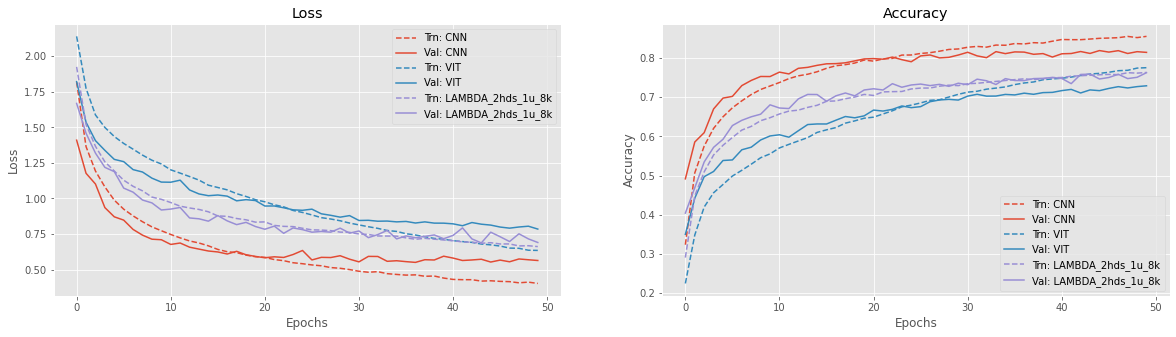

In [20]:
legends = ['CNN', 'VIT', 'LAMBDA_2hds_1u_8k']
histories = [history['CNN'], history['VIT'], history['LAMBDA'][2][1][8]]

plot([(i['loss'], i['val_loss']) for i in histories], 
     [(i['sparse_categorical_accuracy'],
       i['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

X heads, 1 udim, Y kdim

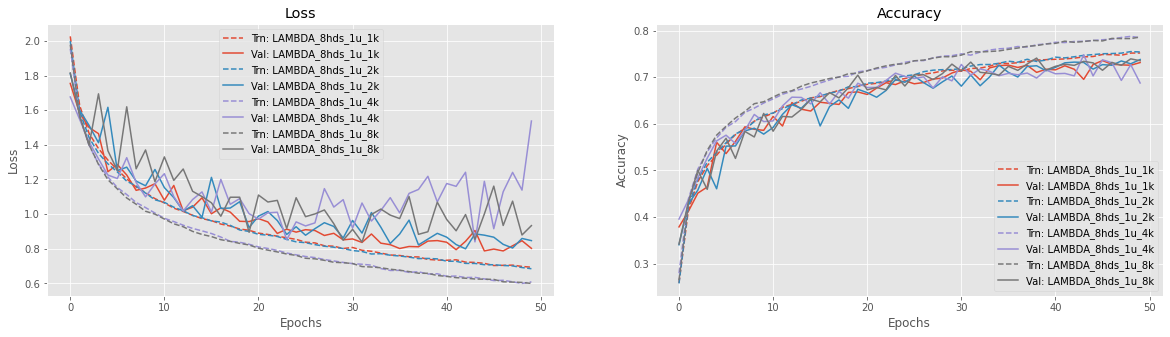

In [21]:
for hds in [1,2,4,8]:
  legends = [f'LAMBDA_{hds}hds_1u_{i}k' for i in [1,2,4,8]]
  histories = [history['LAMBDA'][hds][1][i] for i in [1,2,4,8]]

plot([(i['loss'], i['val_loss']) for i in histories], 
     [(i['sparse_categorical_accuracy'],
       i['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

2 heads, X udim, Y kdim



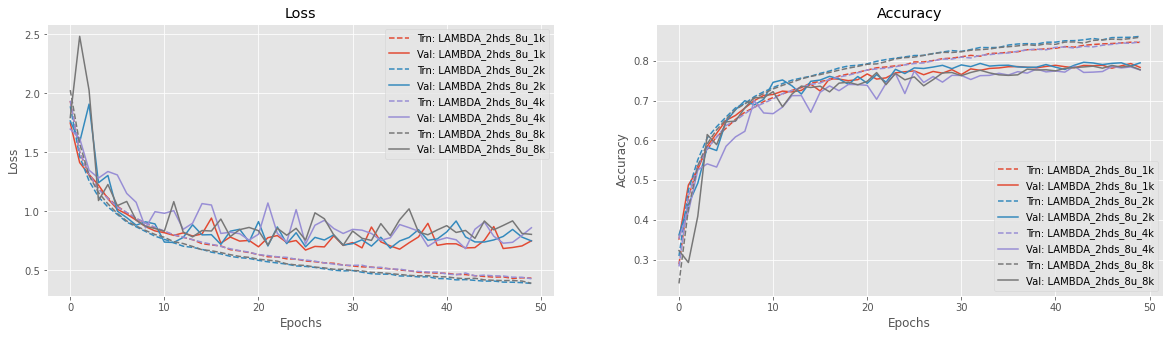

In [22]:
for u in [1,2,4,8]:
  legends = [f'LAMBDA_2hds_{u}u_{i}k' for i in [1,2,4,8]]
  histories = [history['LAMBDA'][2][u][i] for i in [1,2,4,8]]

plot([(i['loss'], i['val_loss']) for i in histories], 
     [(i['sparse_categorical_accuracy'],
       i['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

1 heads, 1 udim, X kdim

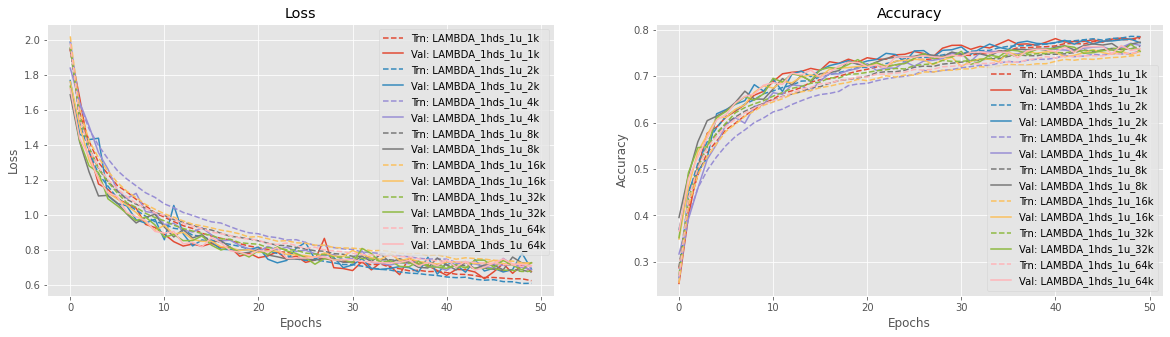

In [23]:
u = 1
hds = 1
legends = [f'LAMBDA_{hds}hds_{u}u_{i}k' for i in [1,2,4,8,16,32,64]]
histories = [history['LAMBDA'][hds][u][i] for i in [1,2,4,8,16,32,64]]

plot([(i['loss'], i['val_loss']) for i in histories], 
     [(i['sparse_categorical_accuracy'],
       i['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])